In [1]:
# imports
import sys  
sys.path.insert(0, '../../../TwitterCoordinatedInorganicAgents')

import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import AutoModel
from transformers import AutoTokenizer
import numpy as np
from tweetcore.tasks.postgres_target import download_data
from tweetcore.tasks.classification_task.classification_utils import make_report, bagging_models  
from data_builders.tasks import collapse_embeddings
import credentials_refactor
import global_settings as gs
import gc

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier
import tensorflow as tf

# model utils
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import fbeta_score, make_scorer, accuracy_score, f1_score, roc_auc_score, accuracy_score, precision_score, recall_score, classification_report, roc_curve, auc, confusion_matrix, precision_recall_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from category_encoders import leave_one_out, cat_boost, target_encoder
from scipy.special import softmax

In [2]:
# personalized metrics
def precision_th(y_true, y_proba, th):
    y_pred = y_proba.copy()
    y_pred[y_pred>=th]=1
    y_pred[y_pred<th]=0
    
    return precision_score(y_true, y_pred)

def recall_th(y_true, y_proba, th):
    y_pred = y_proba.copy()
    y_pred[y_pred>=th]=1
    y_pred[y_pred<th]=0
    
    return recall_score(y_true, y_pred)

def accuracy_th(y_true, y_proba, th):
    y_pred = y_proba.copy()
    y_pred[y_pred>=th]=1
    y_pred[y_pred<th]=0
    
    return recall_score(y_true, y_pred)

def fbeta_score_th(y_true, y_proba, th, beta):
    y_pred = y_proba.copy()
    y_pred[y_pred>=th]=1
    y_pred[y_pred<th]=0
    
    return fbeta_score(y_true, y_pred, beta=beta)

# Getting data

In [3]:
# data
conf = credentials_refactor.return_credentials()
data = download_data.pandas_df_from_postgre_query(configuration = conf ,
                                                  query = '''
                                                          select *
                                                          from redacted_tables.features_user_classification
                                                          ''')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 66 columns):
 #   Column                                             Non-Null Count    Dtype  
---  ------                                             --------------    -----  
 0   user_id_anon                                       1000000 non-null  int64  
 1   uuu_year_joined                                    1000000 non-null  int64  
 2   uuu_month_joined                                   1000000 non-null  int64  
 3   uuu_day_of_month_joined                            1000000 non-null  int64  
 4   uuu_day_of_week_joined                             1000000 non-null  int64  
 5   uuu_joined_weekend                                 1000000 non-null  int64  
 6   uuu_hour_joined                                    1000000 non-null  int64  
 7   uuu_username_length                                1000000 non-null  int64  
 8   uuu_fraction_numbers_username                      1000000 non-

# User-based classifier

## Getting data ready

In [5]:
user_based_features = [i for i in data.columns if 'uuu' in i]

In [6]:
df_user = data[user_based_features + ["target"]].copy()

In [7]:
df_user.fillna(-1,inplace=True)


In [8]:
df_user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 35 columns):
 #   Column                                 Non-Null Count    Dtype  
---  ------                                 --------------    -----  
 0   uuu_year_joined                        1000000 non-null  int64  
 1   uuu_month_joined                       1000000 non-null  int64  
 2   uuu_day_of_month_joined                1000000 non-null  int64  
 3   uuu_day_of_week_joined                 1000000 non-null  int64  
 4   uuu_joined_weekend                     1000000 non-null  int64  
 5   uuu_hour_joined                        1000000 non-null  int64  
 6   uuu_username_length                    1000000 non-null  int64  
 7   uuu_fraction_numbers_username          1000000 non-null  float64
 8   uuu_fraction_emojis_username           1000000 non-null  float64
 9   uuu_fraction_capital_letters_username  1000000 non-null  float64
 10  uuu_fraction_special_char_username     1000

## Benchmarking

In [9]:
X = df_user.drop(columns="target").copy()
y = df_user.target.copy()

X_train_user, X_test_user, y_train_user, y_test_user = train_test_split(
                                                                         X, 
                                                                         y, 
                                                                         test_size=0.35, 
                                                                         random_state=12
                                                                        )

In [11]:
# benchmark

rf = RandomForestClassifier()
xgb = XGBClassifier()
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
all_models = {"RandomForest":rf,"XGBoost":xgb}

for name, model in zip(all_models.keys(),all_models.values()):
    cv_results = cross_validate(model, 
                            X_train_user, 
                            y_train_user, 
                            cv=5,
                            scoring=fpointfive_scorer)
    print(name + " with mean f0.5 over 5 folds of: " + str(round(np.mean(cv_results["test_score"]),4)) + " and sigma accross test metrics of: " + str(round(np.std(cv_results["test_score"]),4)))

RandomForest with mean f0.5 over 5 folds of: 0.3873 and sigma accross test metrics of: 0.0032
XGBoost with mean f0.5 over 5 folds of: 0.4123 and sigma accross test metrics of: 0.0023


## Balancing classes

In [11]:
ideal = len(y[y==0])/len(y[y==1])
print(ideal)

6.145766490642619


6.145766490642619
Imbalance compensation of 0.1:1


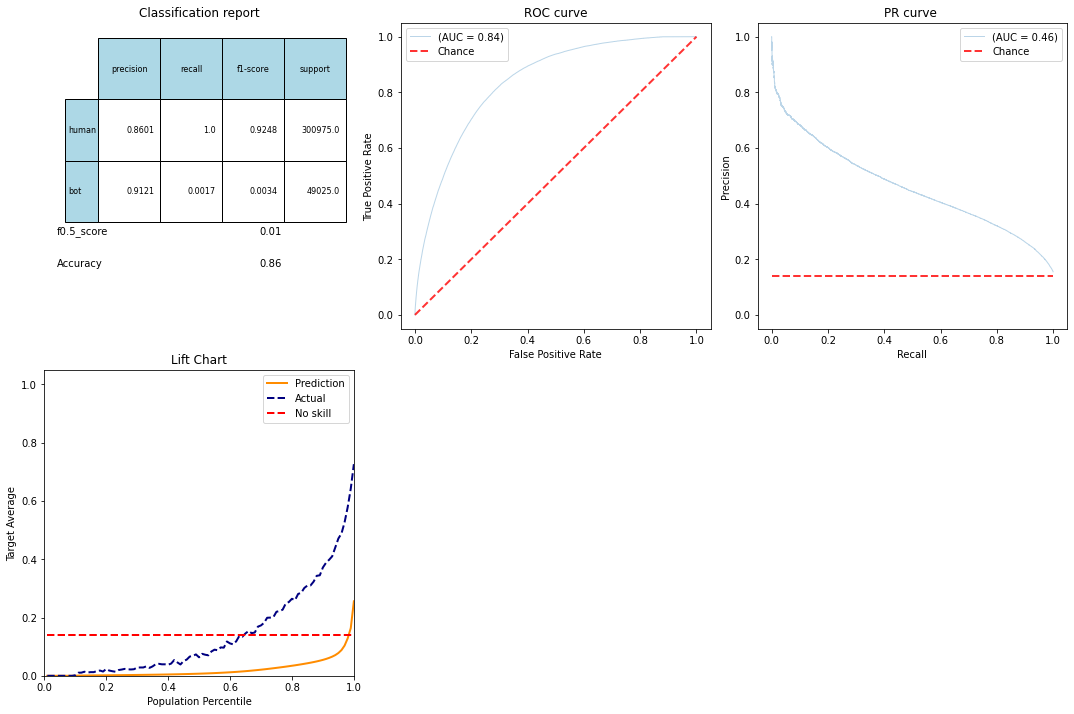

Imbalance compensation of 0.6:1


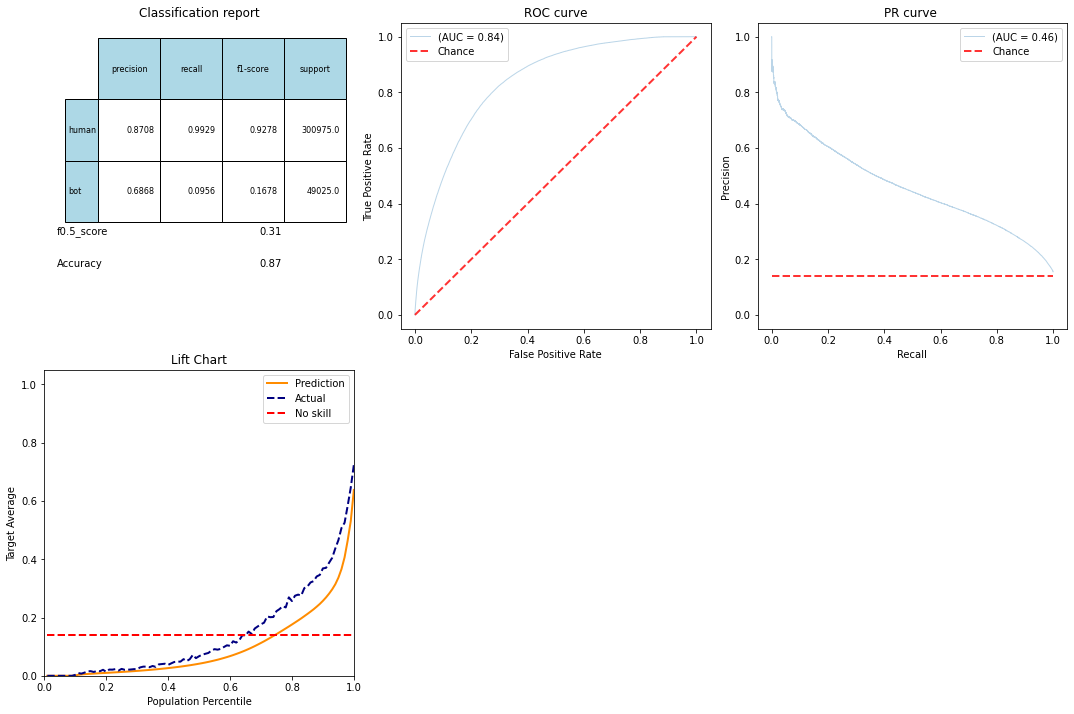

Imbalance compensation of 1.1:1


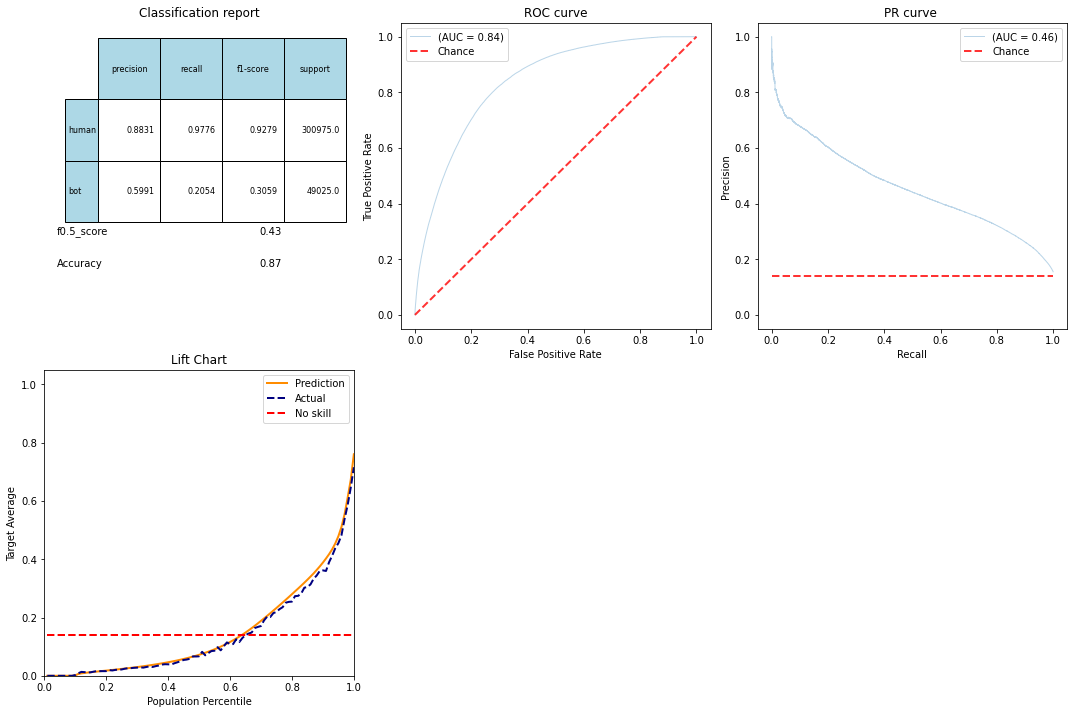

Imbalance compensation of 1.6:1


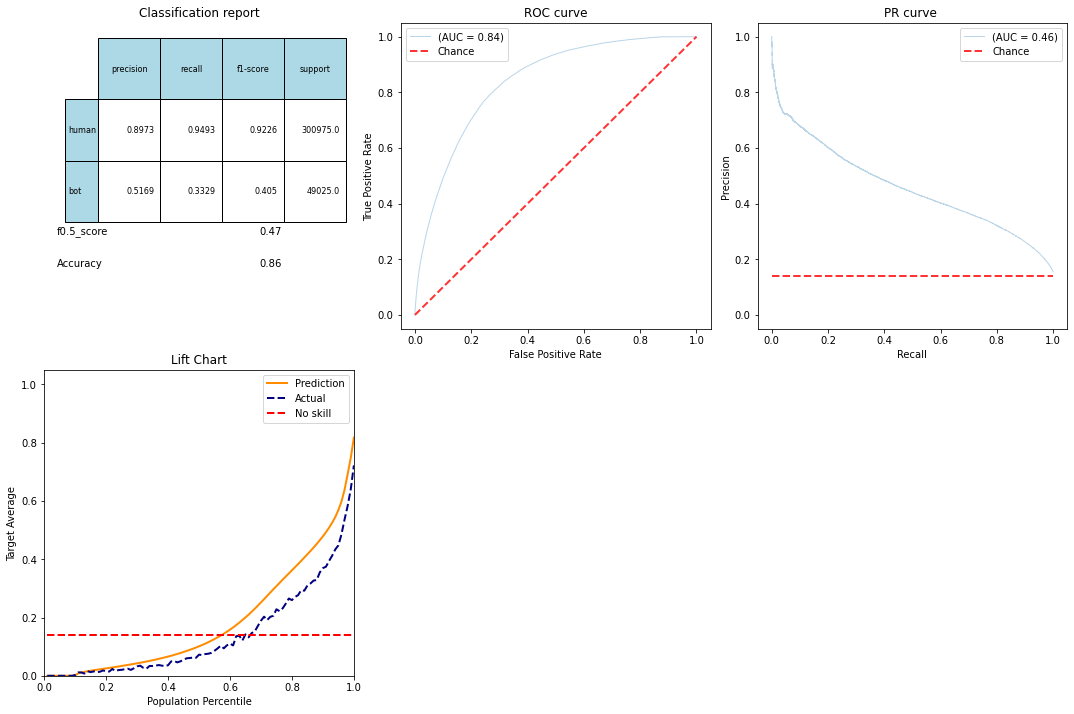

Imbalance compensation of 2.1:1


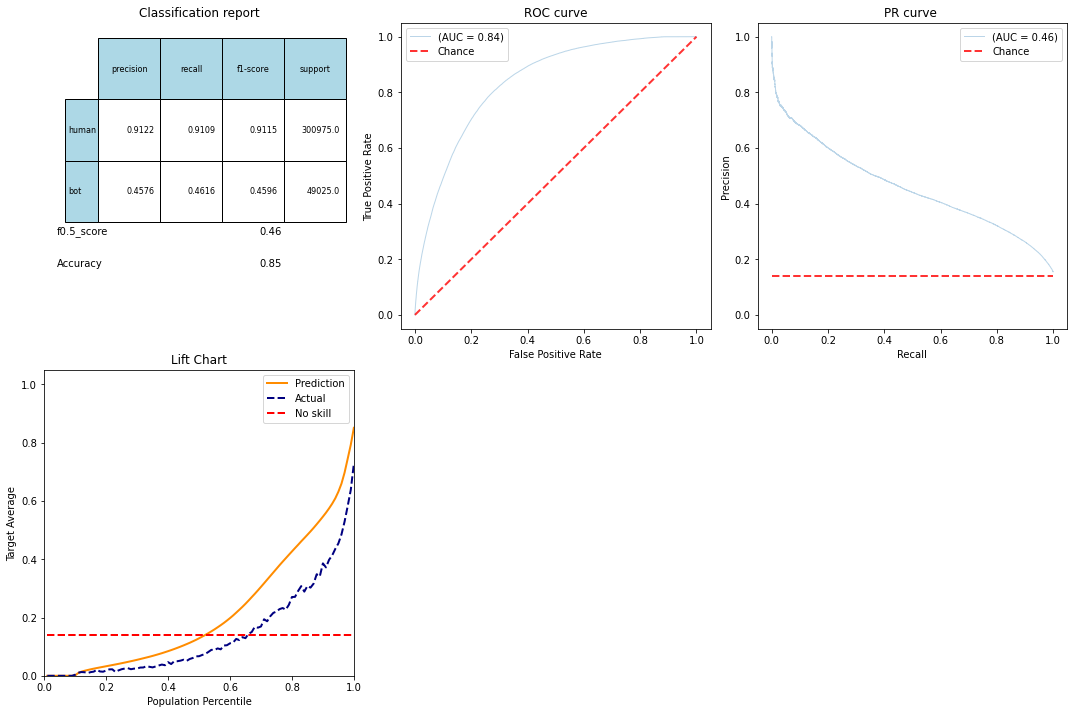

Imbalance compensation of 2.6:1


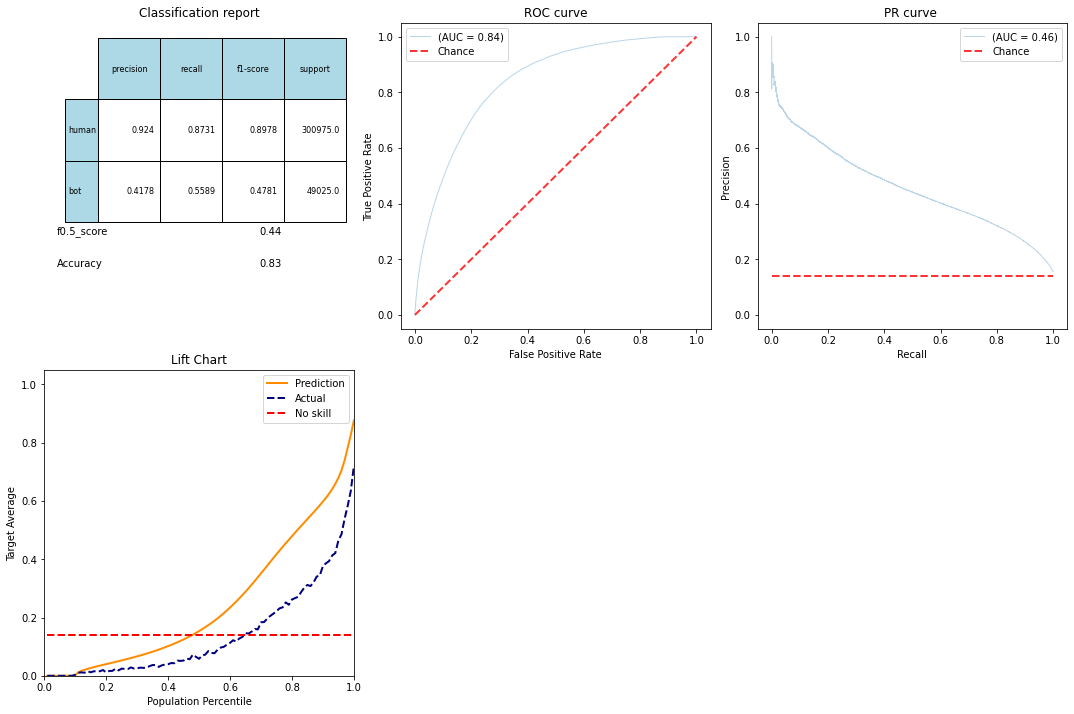

Imbalance compensation of 3.1:1


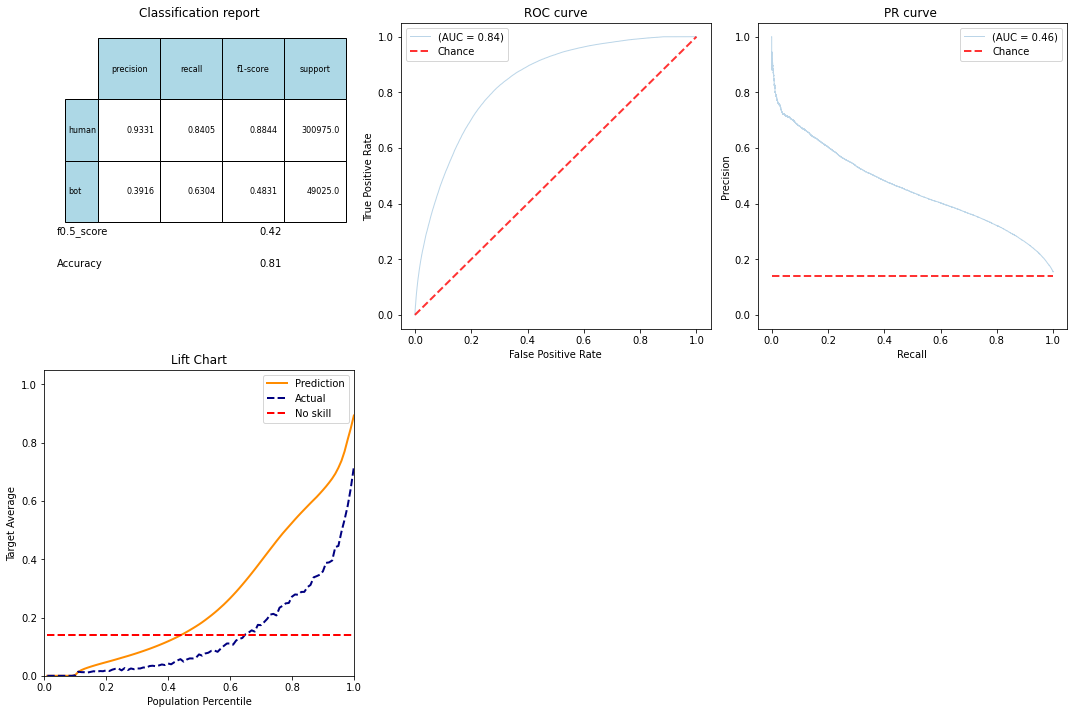

Imbalance compensation of 3.6:1


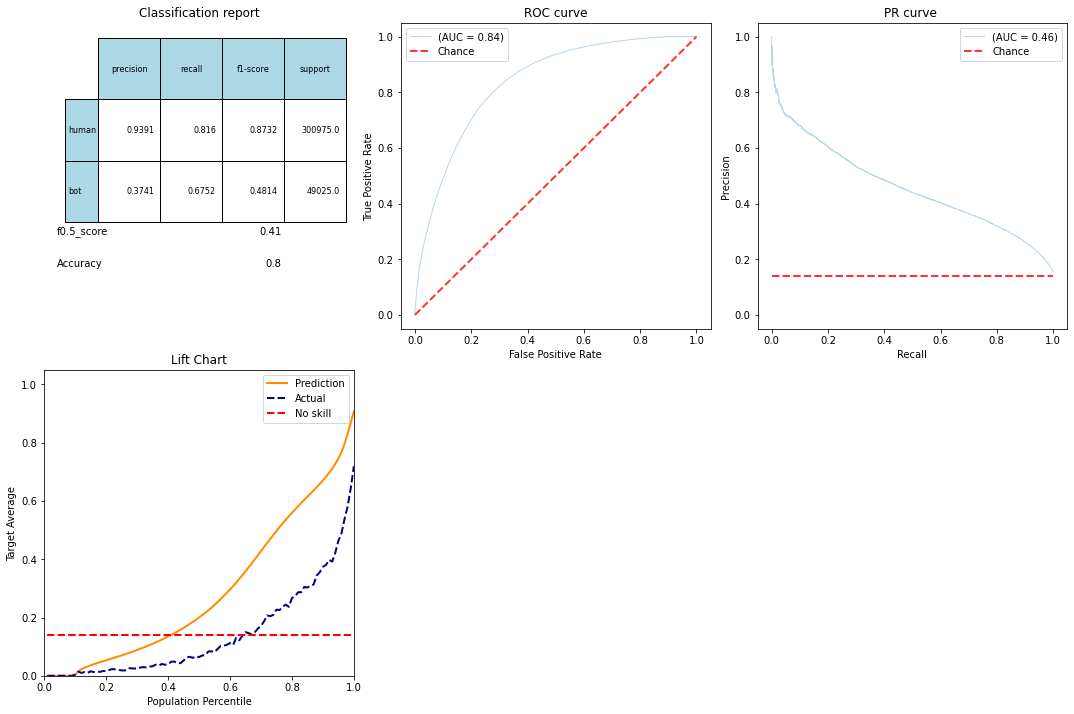

Imbalance compensation of 4.1:1


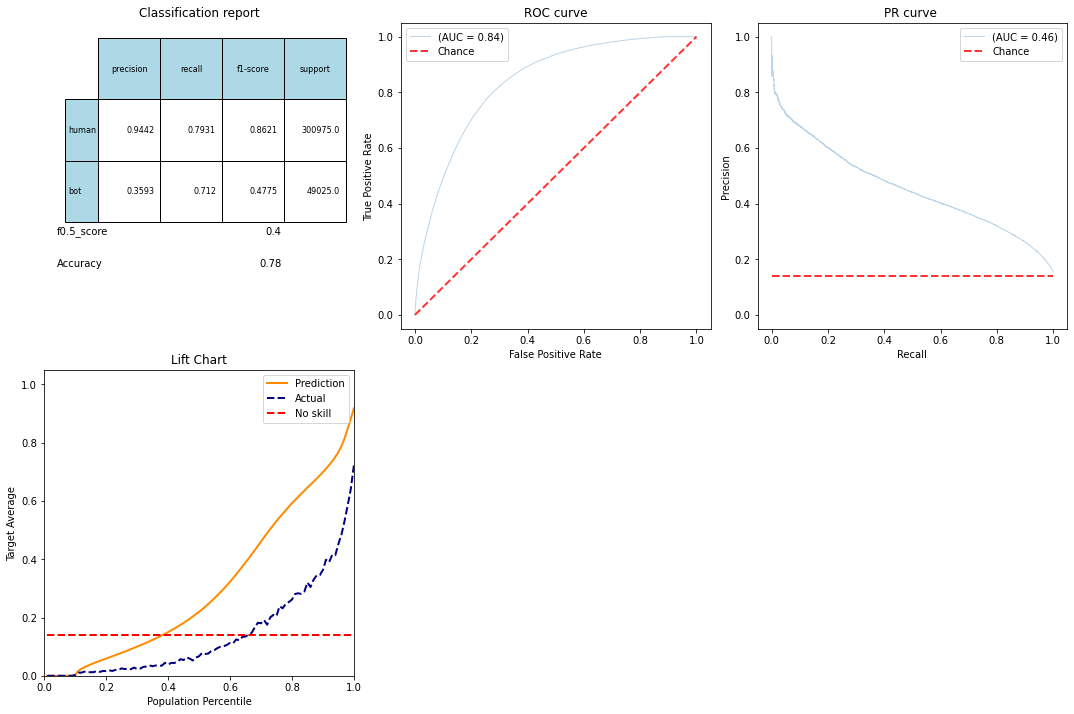

Imbalance compensation of 4.6:1


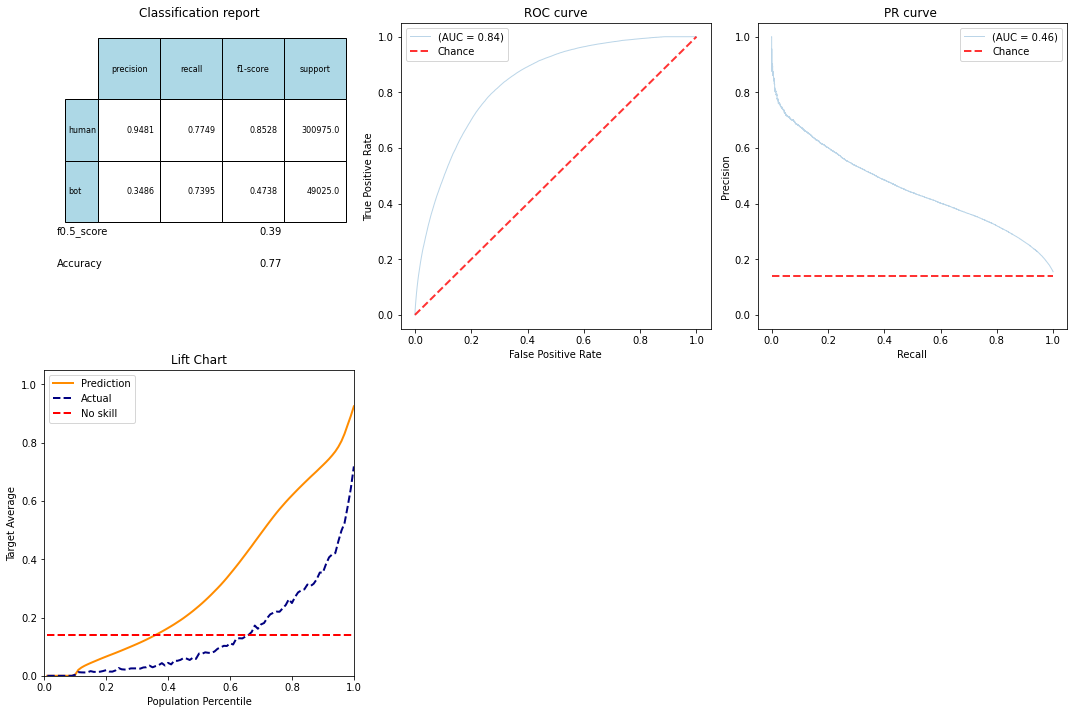

Imbalance compensation of 5.1:1


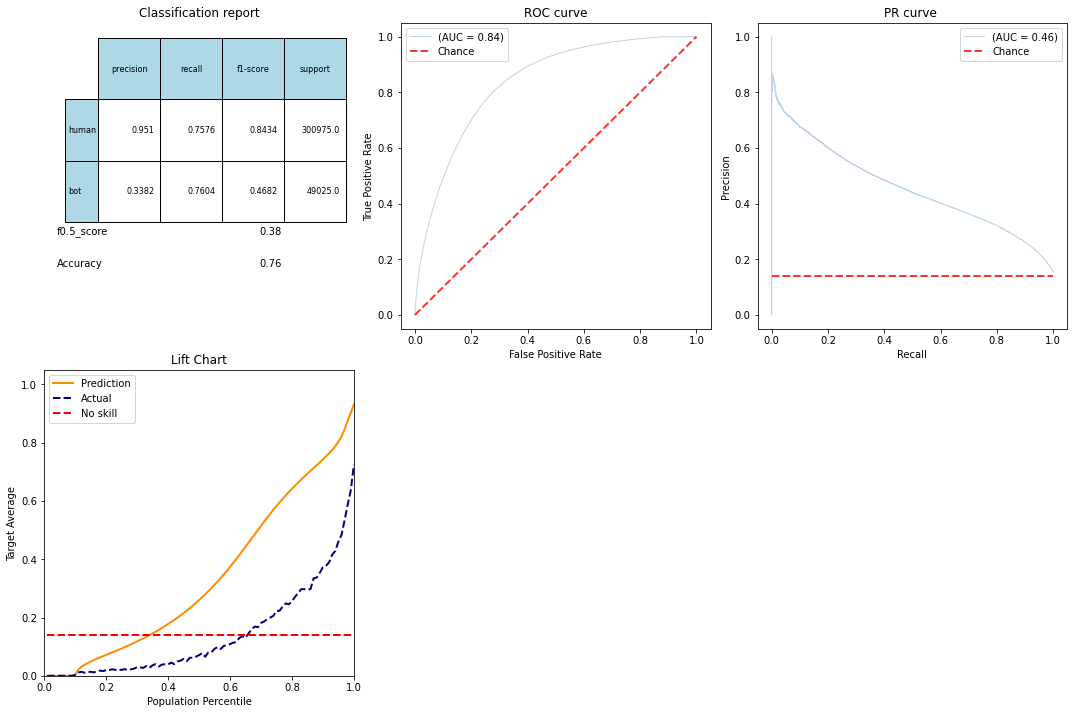

Imbalance compensation of 5.6:1


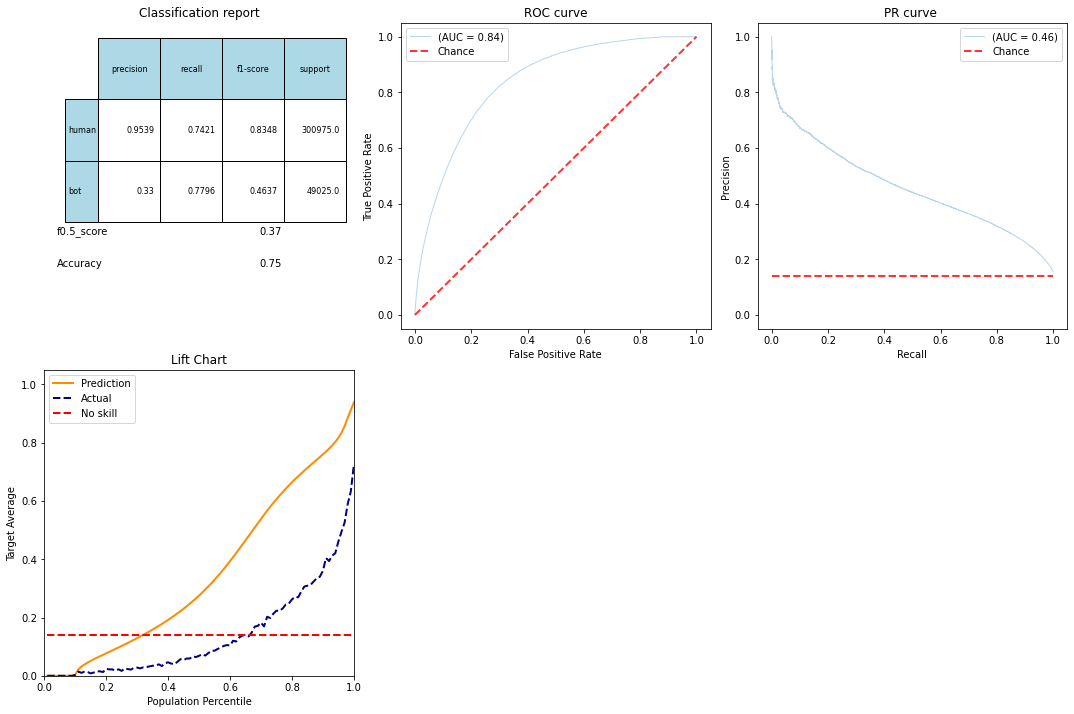

Imbalance compensation of 6.1:1


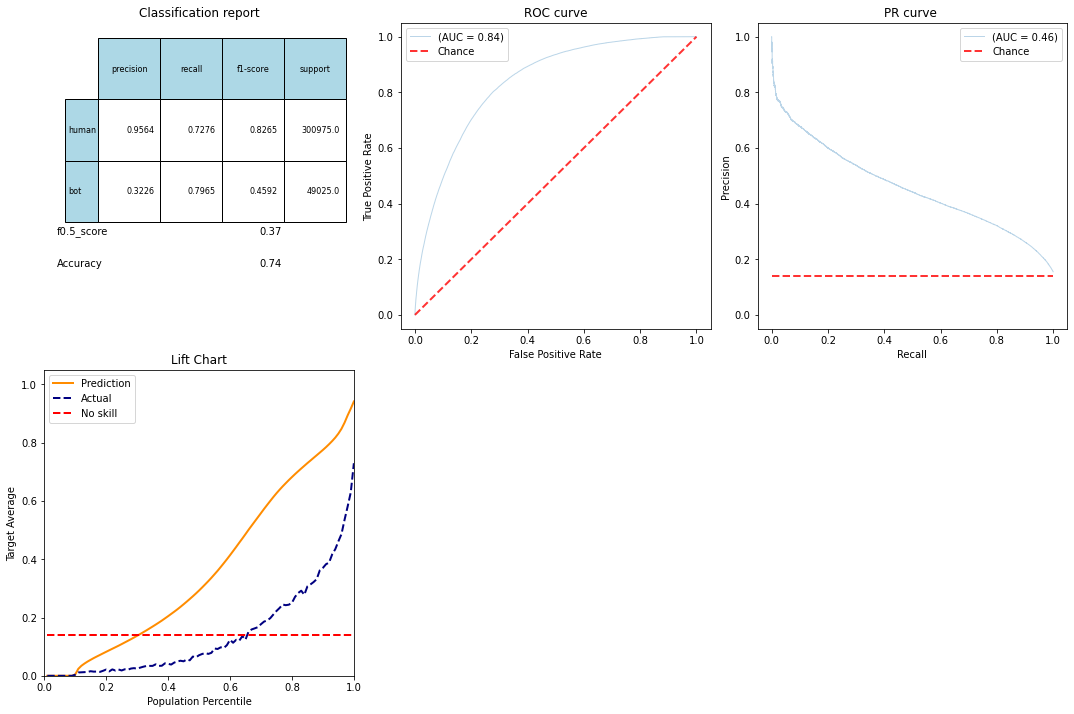

Imbalance compensation of 6.6:1


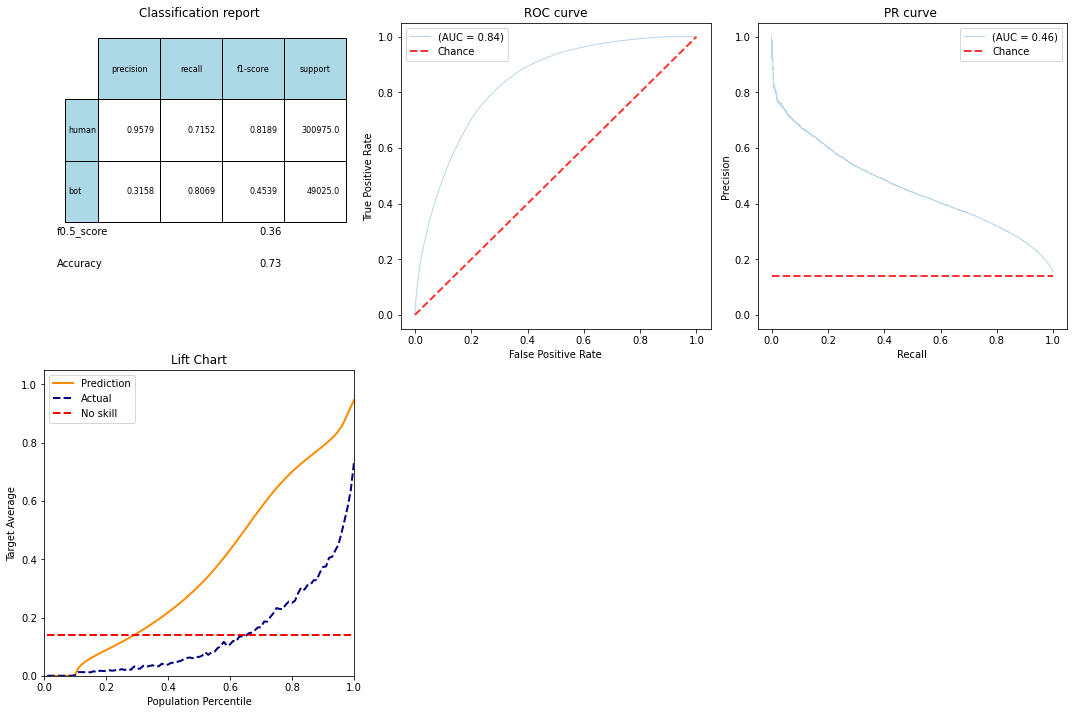

Imbalance compensation of 7.1:1


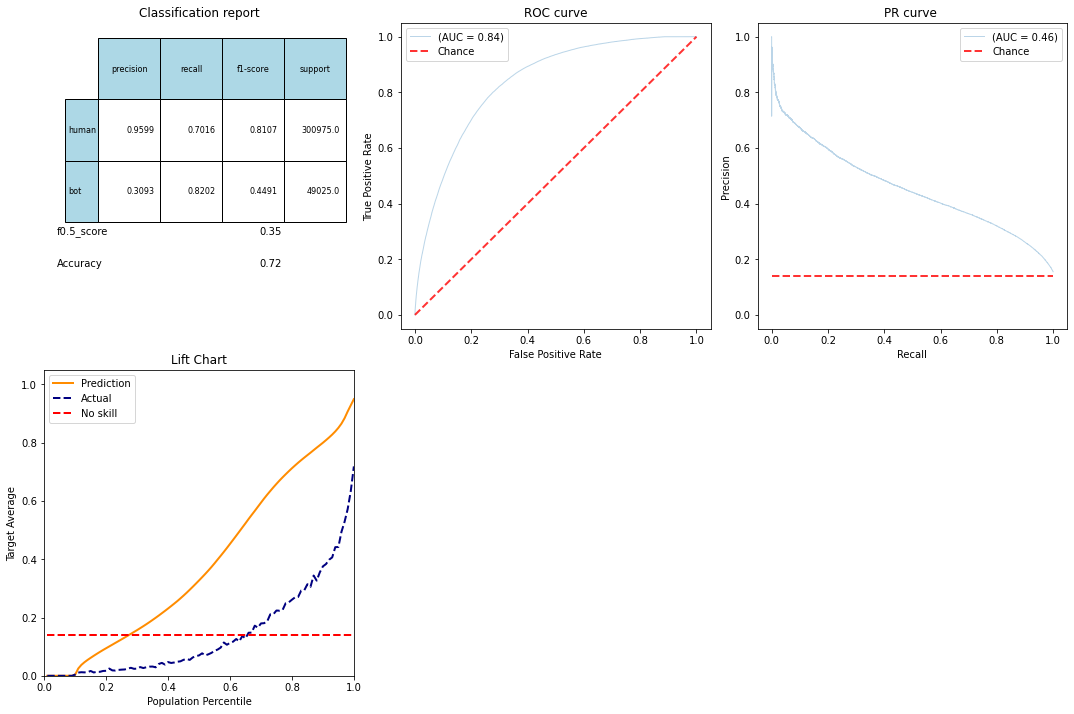

Imbalance compensation of 7.6:1


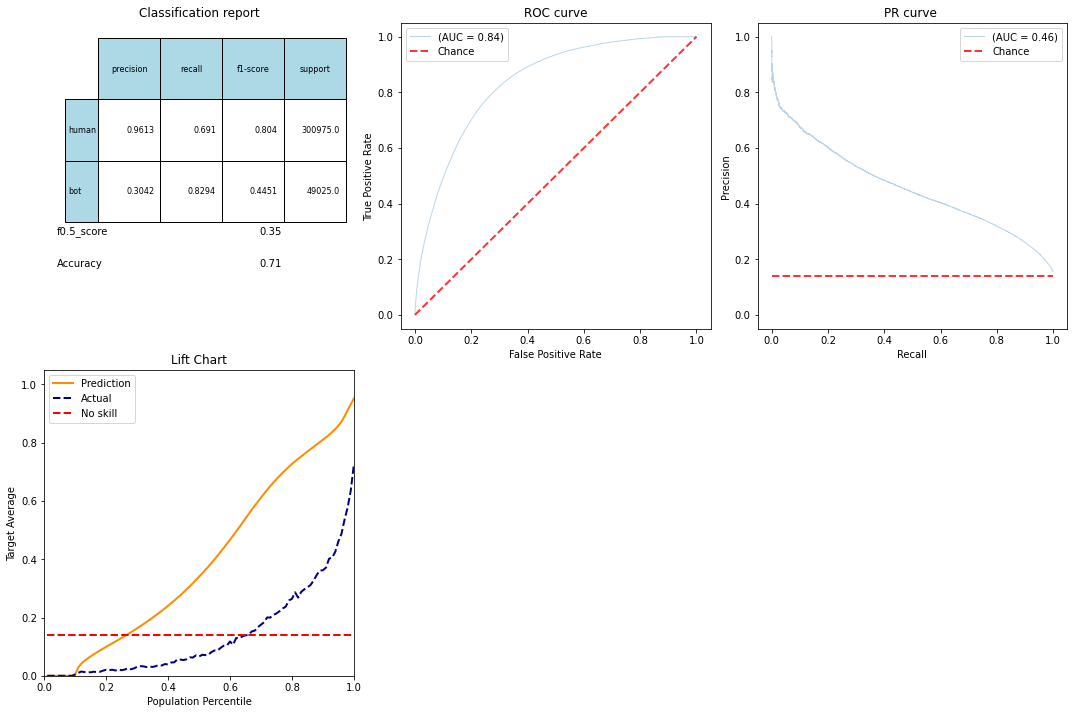

Imbalance compensation of 8.1:1


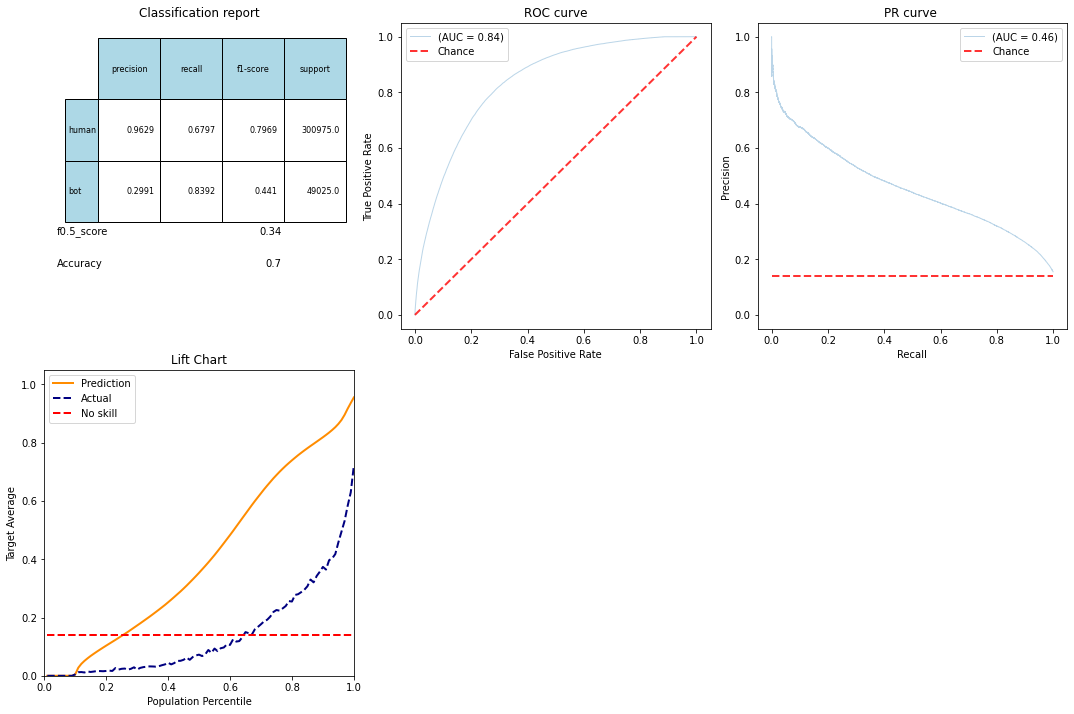

Imbalance compensation of 8.6:1


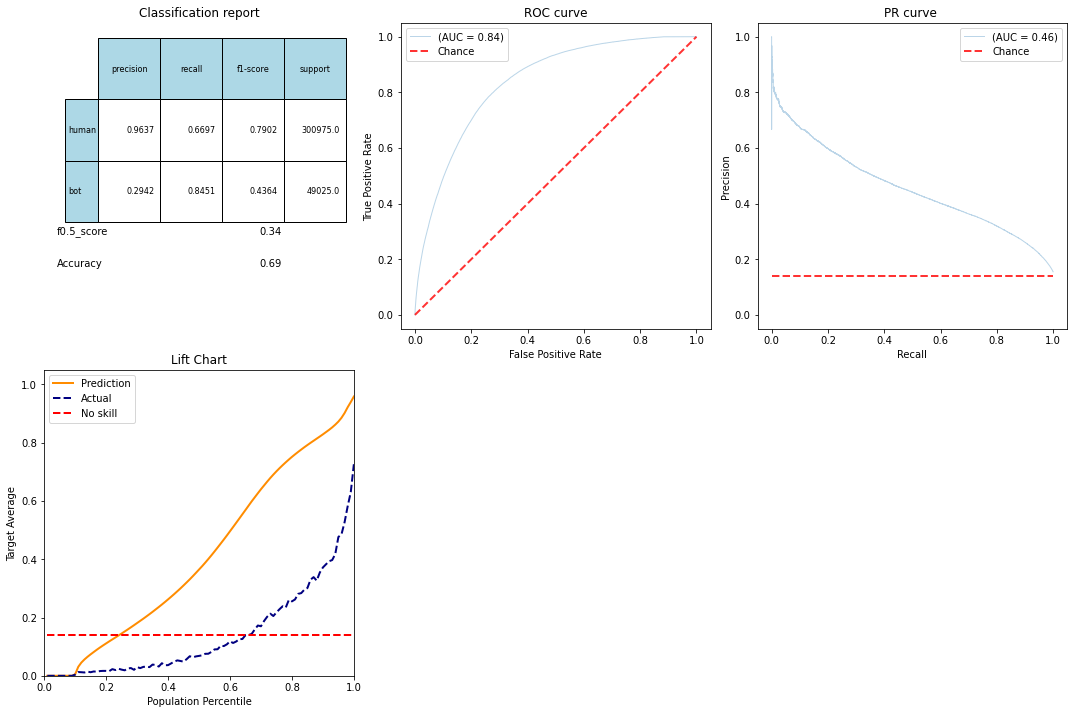

Imbalance compensation of 9.1:1


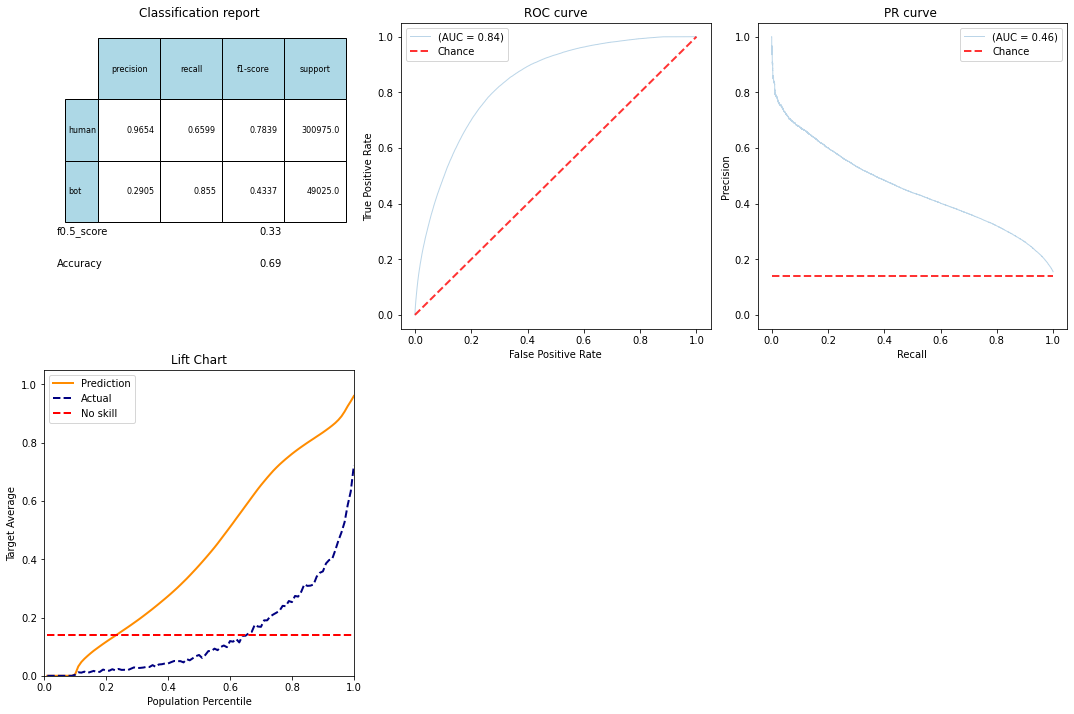

In [11]:
# scale fine-tuning
results_scale = {}
beta=0.5
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    print(f'Imbalance compensation of {scaling}:1')
    xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=scaling
                        )
    xgb.fit(X_train_user, y_train_user)
    
    roc_auc, pr_auc, report, personalized_metrics = make_report(model = xgb,
                                                                y_test = y_test_user, 
                                                                x_test = X_test_user,  
                                                                include = ['class_report', 'roc', 'pr', 'lift'], 
                                                                pad=1,
                                                                scale=5,
                                                                personalized = {f'f{beta}_score':fbeta_score},
                                                                **{'beta':beta, 'pos_label':1})

    results_scale[scaling] = {'roc_auc':roc_auc, 'pr_auc':pr_auc, 'report':report, 'personalized_metrics':personalized_metrics}
    

In [ ]:
# estimating performance
fpointfive_scorer_th = make_scorer(fbeta_score_th, needs_proba=True, beta=0.5, th=0.5)
roc_auc_scorer_th = make_scorer(roc_auc_score, needs_proba=True)
precision_scorer_th = make_scorer(precision_th, needs_proba=True, th=0.5)
recall_scorer_th = make_scorer(recall_th, needs_proba=True, th=0.5)
accuracy_scorer_th = make_scorer(accuracy_th, needs_proba=True, th=0.5)
scaling_results = None
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=scaling)
    cv_results = cross_validate(xgb, 
                                X_train_user, 
                                y_train_user, 
                                cv=5,
                                scoring={'f0.5_score':fpointfive_scorer_th, 'roc_auc':roc_auc_scorer_th, 'precision':precision_scorer_th, 'recall':recall_scorer_th, 'accuracy':accuracy_scorer_th})
    temp_df = pd.DataFrame(data=cv_results)
    temp_df.loc[:,"scale"] = [scaling]*temp_df.shape[0]
    scaling_results = pd.concat([scaling_results,temp_df])
    del xgb, temp_df
    print(scaling)    
    print(scaling_results)

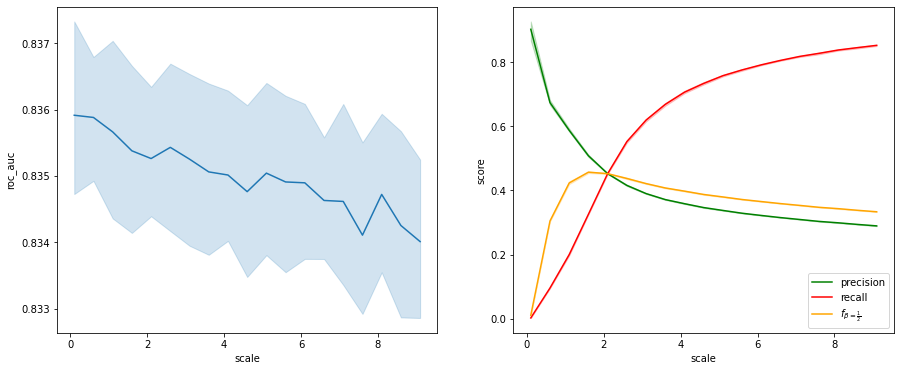

In [16]:
# performance against_sclae
plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax1= plt.subplot(122)
sns.lineplot(x='scale',
             y='test_roc_auc',
             data=scaling_results,
             ax=ax)
sns.lineplot(x='scale',
             y='test_precision',
             data=scaling_results,
             label='precision',
             color='green',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_recall',
             data=scaling_results,
             label='recall',
             color='red',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_f0.5_score',
             data=scaling_results,
             label=r'$f_{\beta = \frac{1}{2}}$',
             color='orange',
             ax=ax1)
ax1.legend()
ax1.set_ylabel('score')
ax.set_ylabel('roc_auc')
plt.show()

## Finding a threshold

In [21]:
# th vs. scale
scales = [6]
ths = np.arange(0.01,1.00,0.05)
resp=None
for scaling in scales:
    print(scaling)
    xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=scaling)
    xgb.fit(X_train_user, y_train_user)
    y_pred = xgb.predict_proba(X_test_user)[:,1]
    for th in ths:
        y_proba = y_pred.copy()
        y_proba[y_proba>=th]=1
        y_proba[y_proba<th]=0
        data = {'test_f0.5_score':[fbeta_score(y_test_user, y_proba, beta=0.5)],
                'test_precision':[precision_score(y_test_user, y_proba,zero_division=0)], 
                'test_recall':[recall_score(y_test_user, y_proba,zero_division=0)],
                'th':[th],
                'scaling':[scaling]}
        df_temp = pd.DataFrame(data=data)
        resp = pd.concat([resp, df_temp])
    del xgb

6


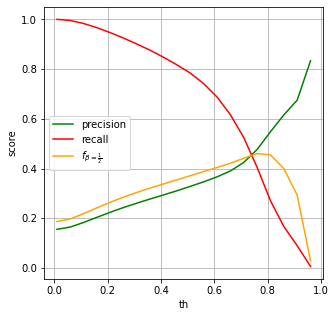

In [113]:
# performance against_scale
# I'm missing here the loop where I run the model for different ths
# Here scale is = 6
plt.figure(figsize=(11,5))
ax1= plt.subplot(121)
sns.lineplot(x='th',
             y='test_precision',
             data=resp,
             label='precision',
             color='green',
             ax=ax1)
sns.lineplot(x='th',
             y='test_recall',
             data=resp,
             label='recall',
             color='red',
             ax=ax1)
sns.lineplot(x='th',
             y='test_f0.5_score',
             data=resp,
             label=r'$f_{\beta = \frac{1}{2}}$',
             color='orange',
             ax=ax1)
ax1.legend()
ax1.set_ylabel('score')
ax1.grid()
plt.show()

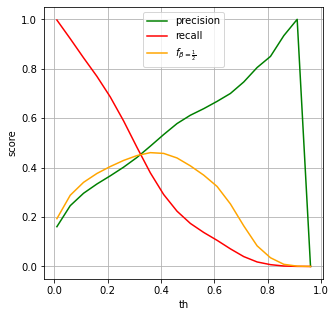

In [116]:
# performance against_scale
# I'm missing here the loop where I run the model for different ths
# Here scale is = 1
plt.figure(figsize=(11,5))
ax1= plt.subplot(121)
sns.lineplot(x='th',
             y='test_precision',
             data=resp,
             label='precision',
             color='green',
             ax=ax1)
sns.lineplot(x='th',
             y='test_recall',
             data=resp,
             label='recall',
             color='red',
             ax=ax1)
sns.lineplot(x='th',
             y='test_f0.5_score',
             data=resp,
             label=r'$f_{\beta = \frac{1}{2}}$',
             color='orange',
             ax=ax1)
ax1.legend()
ax1.set_ylabel('score')
ax1.grid()
plt.show()

In [142]:
# th vs. scale
scales = np.arange(0.1, ideal + ideal*0.6,0.5)
ths = np.arange(0.01,1.00,0.05)
resp=None
for scaling in scales:
    print(scaling)
    xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=scaling)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict_proba(X_test)[:,1]
    for th in ths:
        y_proba = y_pred.copy()
        y_proba[y_proba>=th]=1
        y_proba[y_proba<th]=0
        data = {'test_f0.5_score':[fbeta_score(y_test, y_proba, beta=0.5)],
                'test_precision':[precision_score(y_test, y_proba,zero_division=0)], 
                'test_recall':[recall_score(y_test, y_proba,zero_division=0)],
                'th':[th],
                'scaling':[scaling]}
        df_temp = pd.DataFrame(data=data)
        resp = pd.concat([resp, df_temp])
    del xgb

0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1
9.6


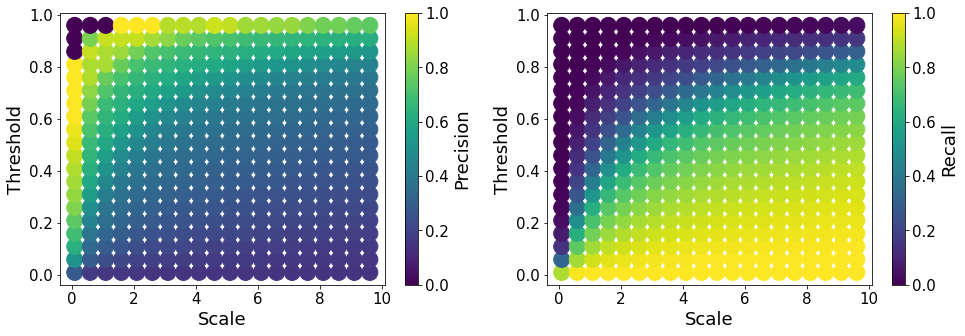

In [153]:
# interacting
plt.figure(figsize=(16,5))
ax=plt.subplot(121)
sc1 = ax.scatter(x = resp.scaling,
                 y = resp.th,
                 c = resp.test_precision,
                 s = 255.5)
cbar = plt.colorbar(sc1)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
for t in ax.get_yticklabels():
     t.set_fontsize(15)
for t in ax.get_xticklabels():
     t.set_fontsize(15)
ax.set_ylabel('Threshold',fontsize=18)
ax.set_xlabel(r'Scale',fontsize=18)
cbar.set_label(r'Precision', rotation=90,fontsize=18)

ax1=plt.subplot(122)
sc2 = ax1.scatter(x = resp.scaling,
                 y = resp.th,
                 c = resp.test_recall,
                 s = 255.5)
cbar2 = plt.colorbar(sc2)
for t in cbar2.ax.get_yticklabels():
     t.set_fontsize(15)
for t in ax1.get_yticklabels():
     t.set_fontsize(15)
for t in ax1.get_xticklabels():
     t.set_fontsize(15)
ax1.set_ylabel('Threshold',fontsize=18)
ax1.set_xlabel(r'Scale',fontsize=18)
cbar2.set_label(r'Recall', rotation=90,fontsize=18)

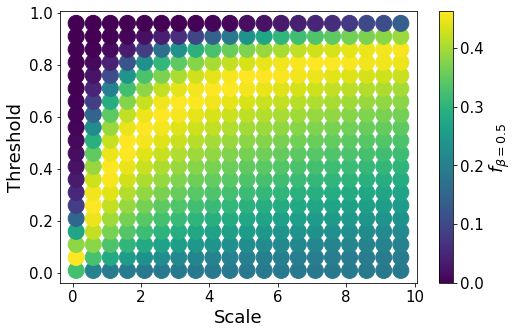

In [156]:
# interaction
plt.figure(figsize=(8,5))
ax=plt.subplot(111)
sc1 = ax.scatter(x = resp.scaling,
                 y = resp.th,
                 c = resp['test_f0.5_score'],
                 s = 255.5)
cbar = plt.colorbar(sc1)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
for t in ax.get_yticklabels():
     t.set_fontsize(15)
for t in ax.get_xticklabels():
     t.set_fontsize(15)
ax.set_ylabel('Threshold',fontsize=18)
ax.set_xlabel(r'Scale',fontsize=18)
cbar.set_label(r'$f_{\beta=0.5}$', rotation=90,fontsize=18)

We are going with scale = 5 and th between 0.6 and 0.8. I need Rebecka's approval, though

In [24]:
xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=5)
xgb.fit(X_train_user, y_train_user)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

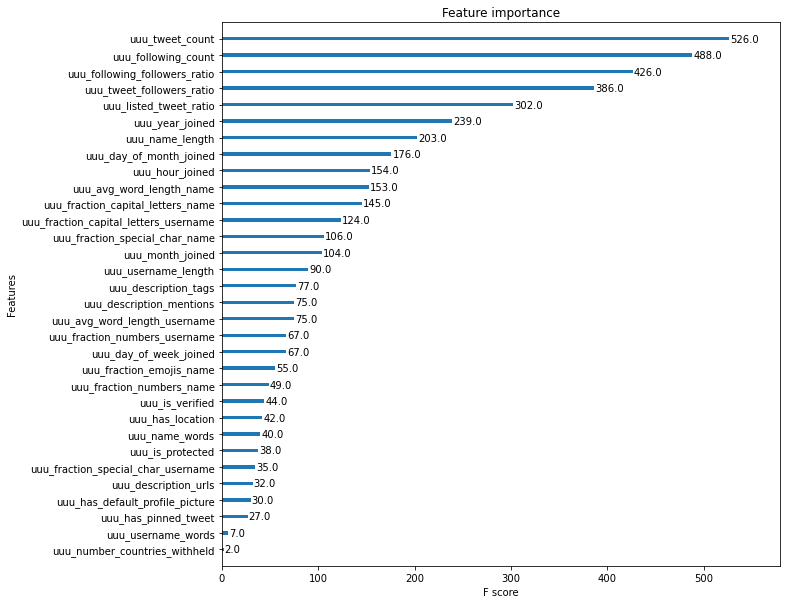

In [25]:
from xgboost import plot_importance
plt.figure(figsize=(10,10))
ax = plt.subplot(111)
plot_importance(xgb, ax=ax, grid=False)
plt.show()

## performance versus feature reduction

In [26]:
xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=5)
xgb.fit(X_train_user, y_train_user)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [27]:
importances = np.unique(xgb.feature_importances_)
importances.sort()

In [28]:
fpointfive_scorer_th = make_scorer(fbeta_score_th, needs_proba=True, beta=0.5, th=0.7)
roc_auc_scorer_th = make_scorer(roc_auc_score, needs_proba=True)
precision_scorer_th = make_scorer(precision_th, needs_proba=True, th=0.7)
recall_scorer_th = make_scorer(recall_th, needs_proba=True, th=0.7)
accuracy_scorer_th = make_scorer(accuracy_th, needs_proba=True, th=0.7)
results=None
for importance_th in importances:
    selection = SelectFromModel(xgb, 
                                threshold=importance_th, 
                                prefit=True)
    selected_X_train = selection.transform(X_train_user)
    print(selected_X_train.shape[1])

    selection_model = XGBClassifier(eval_metric='auc', 
                            scale_pos_weight=5)
    
    cv_results = cross_validate(selection_model, 
                                selected_X_train, 
                                y_train_user, 
                                cv=5,
                                scoring={'f0.5_score_th':fpointfive_scorer_th, 
                                         'roc_auc_th':roc_auc_scorer_th, 
                                         'precision_th':precision_scorer_th, 
                                         'recall_th':recall_scorer_th, 
                                         'accuracy_th':accuracy_scorer_th})
    temp_df = pd.DataFrame(data=cv_results)
    temp_df.loc[:,"num_features"] = [selected_X_train.shape[1]]*temp_df.shape[0]
    results = pd.concat([results,temp_df])
    del selection_model, temp_df
    print(importance_th)   

C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


34
0.0
32


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0013880901
31


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0030726998
30


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0032546662
29


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0035249596
28


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0037550777
27


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0038847348
26


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0039109387
25


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0041172616
24


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0042312522
23


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0044459566
22


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.004455226
21


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0059094
20


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0063124397
19


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0077444785
18


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0077922563
17


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.007886525
16


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.010604706
15


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.012624007
14


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.012726874
13


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.0133702615
12


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.015157343
11


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.015278264
10


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.018917145
9


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.02177503
8


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.02741549
7


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.046229806
6


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.052963186
5


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.053671554
4


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.05554937
3


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.14584972
2


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


0.15376297
1


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

0.26841825


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


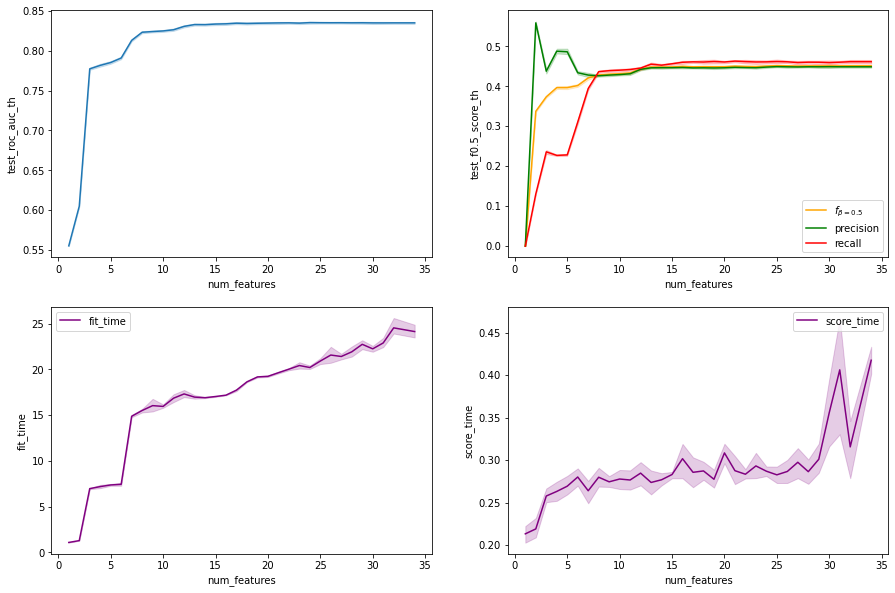

In [29]:
# feature reduction
plt.figure(figsize=(15,10))
ax = plt.subplot(221)
ax1 = plt.subplot(222)
ax2 = plt.subplot(223)
ax3 = plt.subplot(224)
sns.lineplot(x='num_features',
             y='test_roc_auc_th',
             data=results,
             ax=ax)
sns.lineplot(x='num_features',
             y='test_f0.5_score_th',
             color='orange',
             label=r'$f_{\beta=0.5}$',
             data=results,
             ax=ax1)
sns.lineplot(x='num_features',
             y='test_precision_th',
             color='green',
             label='precision',
             data=results,
             ax=ax1)
sns.lineplot(x='num_features',
             y='test_recall_th',
             label='recall',
             color='red',
             data=results,
             ax=ax1)
sns.lineplot(x='num_features',
             y='fit_time',
             label='fit_time',
             color='purple',
             data=results,
             ax=ax2)
sns.lineplot(x='num_features',
             y='score_time',
             label='score_time',
             color='purple',
             data=results,
             ax=ax3)
ax1.legend()

# Activity-based classifier

## Getting data ready

In [5]:
exclude = ['aaa_core_number_tweets', 'aaa_user_id_anon']

activity_based_features = [i for i in data.columns if 'aaa' in i and i not in exclude]

categorical_features = ['aaa_less_used_language', 'aaa_mode_language', 'aaa_mode_type_corrected']

cast_to_float = ['aaa_mode_month_activity', 'aaa_mode_day_activity', 'aaa_mode_day_of_week_activity', 'aaa_mode_hour_activity', 'aaa_max_actv_freq_minutes', 'aaa_min_actv_freq_minutes', 'aaa_avg_actv_freq_minutes', 'aaa_median_actv_freq_minutes']

df_activity = data[activity_based_features + ["target"]].copy()

In [7]:
df_activity.loc[:,'aaa_number_tweets_sample'] = df_activity['aaa_number_tweets_sample'].fillna(0)
df_activity.loc[:,categorical_features] = df_activity[categorical_features].fillna('-1')
df_activity.fillna(-1, inplace=True)

In [8]:
df_activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 31 columns):
 #   Column                                             Non-Null Count    Dtype  
---  ------                                             --------------    -----  
 0   aaa_total_number_mentions                          1000000 non-null  float64
 1   aaa_number_tweets_sample                           1000000 non-null  float64
 2   aaa_number_tweets_with_mention                     1000000 non-null  float64
 3   aaa_unique_number_mentions                         1000000 non-null  float64
 4   aaa_avg_number_mentions_tweet                      1000000 non-null  float64
 5   aaa_avg_number_mentions_tweet_with_mention         1000000 non-null  float64
 6   aaa_avg_number_unique_mentions_tweet               1000000 non-null  float64
 7   aaa_avg_number_unique_mentions_tweet_with_mention  1000000 non-null  float64
 8   aaa_rate_tweets_with_mention                       1000000 non-

In [14]:
X = df_activity.drop(columns="target").copy()
y = df_activity.target.copy()

X_train_activity, X_test_activity, y_train_activity, y_test_activity = train_test_split(
                                                                                         X, 
                                                                                         y, 
                                                                                         test_size=0.35, 
                                                                                         random_state=12
                                                                                        )

In [15]:
categorical_features = ['aaa_less_used_language', 'aaa_mode_language', 'aaa_mode_type_corrected']

target_catencoder = target_encoder.TargetEncoder(cols=categorical_features)
target_catencoder.fit(X_train_activity, y_train_activity)

TargetEncoder(cols=['aaa_less_used_language', 'aaa_mode_language',
                    'aaa_mode_type_corrected'])

In [16]:
X_train_activity_encode = target_catencoder.transform(X_train_activity)
X_test_activity_encode = target_catencoder.transform(X_test_activity)


## Benchmarking

In [ ]:
# benchmark

rf = RandomForestClassifier()
xgb = XGBClassifier()
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
svc = SVC()
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
roc_auc_scorer = make_scorer(roc_auc_score)
all_models = {"RandomForest":rf, "XGBoost":xgb, "LogisticRegression":lr, "SupportVectorMachine":svc, "KNeighbors":knn}

result = {}
for name, model in zip(all_models.keys(),all_models.values()):
    cv_results = cross_validate(
                                model, 
                                X_train_encode, 
                                y_train, 
                                cv=5,
                                scoring={'f0.5':fpointfive_scorer, 'roc_auc':roc_auc_scorer}
                                )
    result[name] = cv_results
    mean_fb = round(np.mean(cv_results['test_f0.5']),4)
    sigma_fb = round(np.std(cv_results['test_f0.5']),4)
    
    mean_roc_auc = round(np.mean(cv_results['test_roc_auc']),4)
    sigma_roc_auc = round(np.std(cv_results['test_roc_auc']),4)
    
    print(f'Model: {name}')
    print(f'fbeta: {mean_fb} +- {sigma_fb}')
    print(f'roc_auc: {mean_roc_auc} +- {sigma_roc_auc}\n')

Model: RandomForest
fbeta: 0.0931 +- 0.0025
roc_auc: 0.5089 +- 0.0003

Model: XGBoost
fbeta: 0.0924 +- 0.0031
roc_auc: 0.5089 +- 0.0004

Model: LogisticRegression
fbeta: 0.3076 +- 0.0033
roc_auc: 0.5655 +- 0.0014



## Balancing classes

In [9]:
ideal = len(y[y==0])/len(y[y==1])
print(ideal)

6.145766490642619


### Logistic Regression

#### Numerical scaling

In [5]:
pd.options.display.max_columns = None

In [6]:
exclude = ['aaa_core_number_tweets', 'aaa_user_id_anon']

activity_based_features = [i for i in data.columns if 'aaa' in i and i not in exclude]

categorical_features = ['aaa_less_used_language', 'aaa_mode_language', 'aaa_mode_type_corrected']

cast_to_float = ['aaa_mode_month_activity', 'aaa_mode_day_activity', 'aaa_mode_day_of_week_activity', 'aaa_mode_hour_activity', 'aaa_max_actv_freq_minutes', 'aaa_min_actv_freq_minutes', 'aaa_avg_actv_freq_minutes', 'aaa_median_actv_freq_minutes']

df_activity = data[activity_based_features + ["target"]].copy()

In [7]:
df_activity.loc[:,'aaa_number_tweets_sample'] = df_activity['aaa_number_tweets_sample'].fillna(0)
df_activity.loc[:,categorical_features] = df_activity[categorical_features].fillna('-1')

In [8]:
X = df_activity.drop(columns="target").copy()
y = df_activity.target.copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                     X, 
                                                     y, 
                                                     test_size=0.35, 
                                                     random_state=12
                                                    )

In [10]:
categorical_features = ['aaa_less_used_language', 'aaa_mode_language', 'aaa_mode_type_corrected']

target_catencoder = target_encoder.TargetEncoder(cols=categorical_features)
target_catencoder.fit(X_train, y_train)

TargetEncoder(cols=['aaa_less_used_language', 'aaa_mode_language',
                    'aaa_mode_type_corrected'])

In [11]:
X_train_encode = target_catencoder.transform(X_train)
X_test_encode = target_catencoder.transform(X_test)

In [12]:
fill_with_mean = [i for i in X_train_encode.columns if i not in ['aaa_number_tweets_sample', 'target'] + categorical_features]

In [14]:
for i in fill_with_mean:
    mean = -1#X_train_encode[i].mean()
    
    X_train_encode.loc[X_train_encode[i]==-1,i] = None
    X_train_encode.loc[:,i] = X_train_encode[i].fillna(mean)
    
    X_test_encode.loc[X_test_encode[i]==-1,i] = None
    X_test_encode.loc[:,i] = X_test_encode[i].fillna(mean)

In [20]:
transformed_log = ['aaa_total_number_mentions', 'aaa_number_tweets_sample',
                   'aaa_number_tweets_with_mention','aaa_unique_number_mentions',
                   'aaa_avg_number_mentions_tweet', 'aaa_avg_number_mentions_tweet_with_mention',
                   'aaa_avg_number_unique_mentions_tweet', 'aaa_avg_number_unique_mentions_tweet_with_mention',
                   'aaa_max_actv_freq_minutes','aaa_min_actv_freq_minutes',
                   'aaa_avg_actv_freq_minutes','aaa_median_actv_freq_minutes',
                   'aaa_rate_media_tweets','aaa_rate_geo_tweets',
                   'aaa_rate_post_tweets','aaa_rate_retweeted_tweets',
                   'aaa_rate_replied_to_tweets','aaa_rate_dominant_language_tweets',
                   'aaa_rate_sensitive_tweets']

standard_scaling = ['aaa_rate_tweets_with_mention', 'aaa_rate_unique_total_mentions',
                    'aaa_max_number_mentions_tweet', 'aaa_mode_month_activity',
                    'aaa_mode_day_activity','aaa_mode_day_of_week_activity',
                    'aaa_mode_hour_activity','aaa_mode_type_corrected', 
                    'aaa_mode_language','aaa_number_languages',
                    'aaa_less_used_language']

In [21]:
for i in transformed_log:
    X_train_encode.loc[:,i] = X_train_encode[i].map(lambda x: np.log10(x+0.00001) if x==0 else np.log10(x))
    X_test_encode.loc[:,i] = X_test_encode[i].map(lambda x: np.log10(x+0.00001) if x==0 else np.log10(x))

In [22]:
sc = StandardScaler()
sc.fit(X_train_encode[transformed_log+standard_scaling])
X_train_encode_scaled = X_train_encode.copy()
X_train_encode_scaled.loc[:,transformed_log+standard_scaling] = sc.transform(X_train_encode[transformed_log+standard_scaling])

X_test_encode_scaled = X_test_encode.copy()
X_test_encode_scaled.loc[:,transformed_log+standard_scaling] = sc.transform(X_test_encode[transformed_log+standard_scaling])

Imbalance compensation of 0.1:1


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


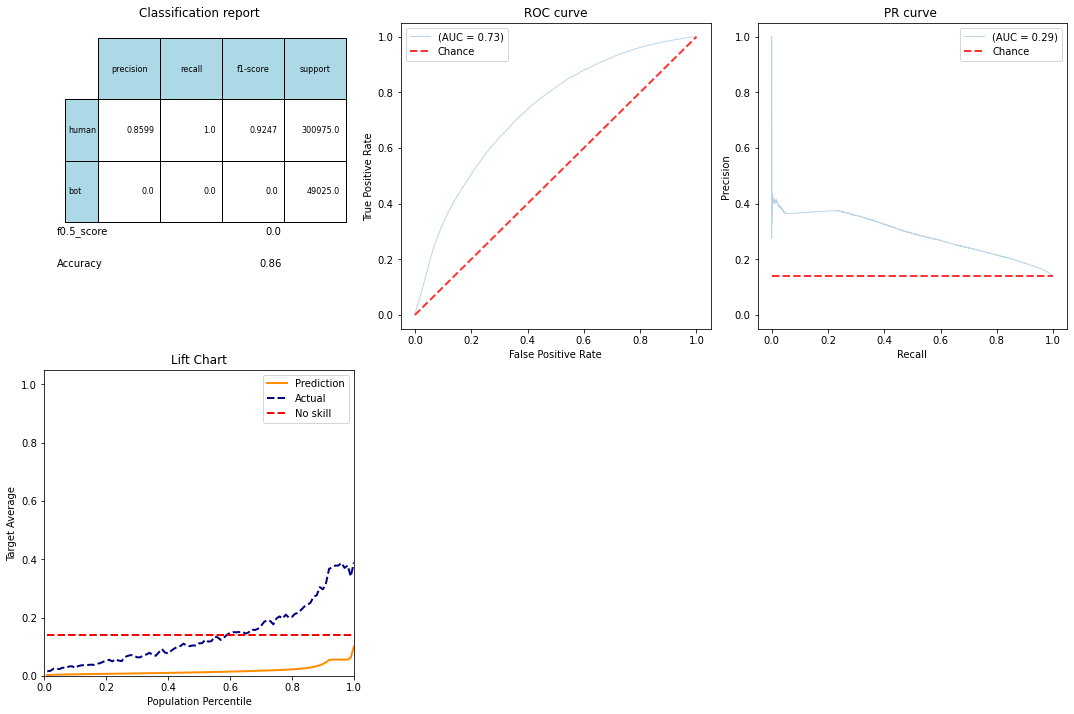

Imbalance compensation of 0.6:1


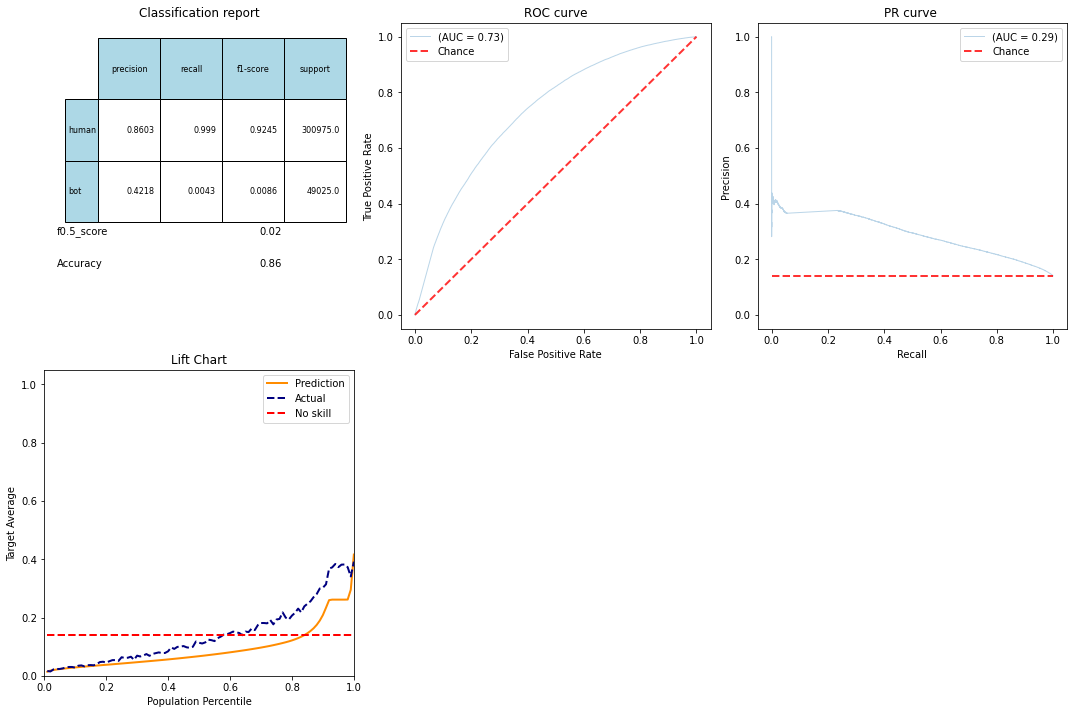

Imbalance compensation of 1.1:1


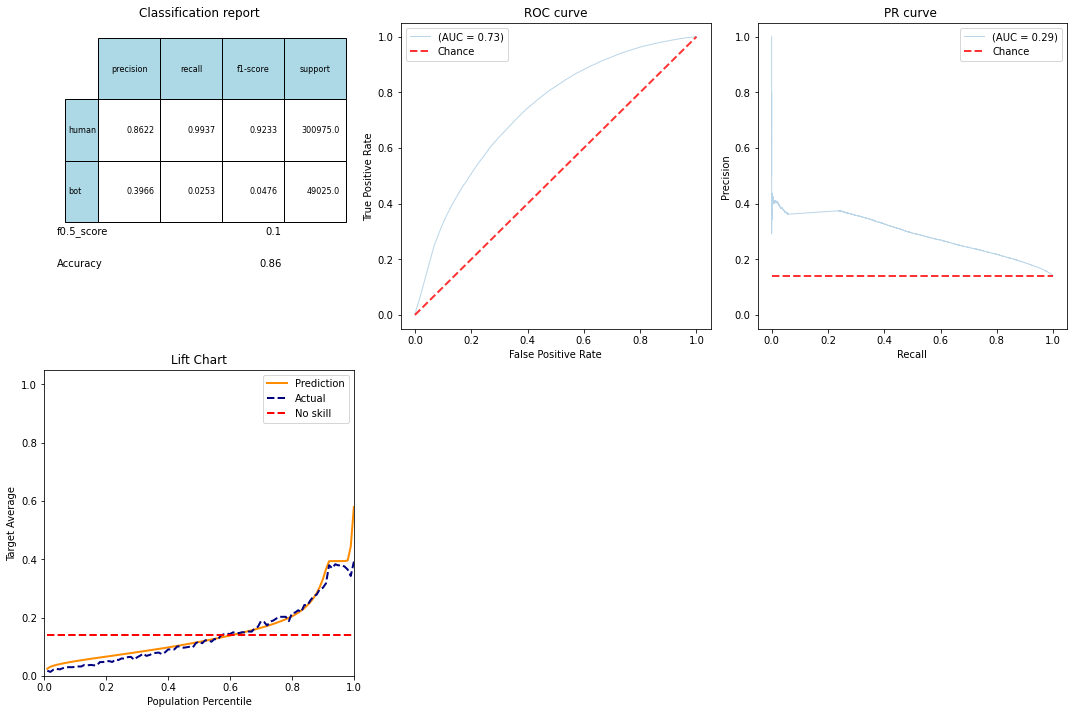

Imbalance compensation of 1.6:1


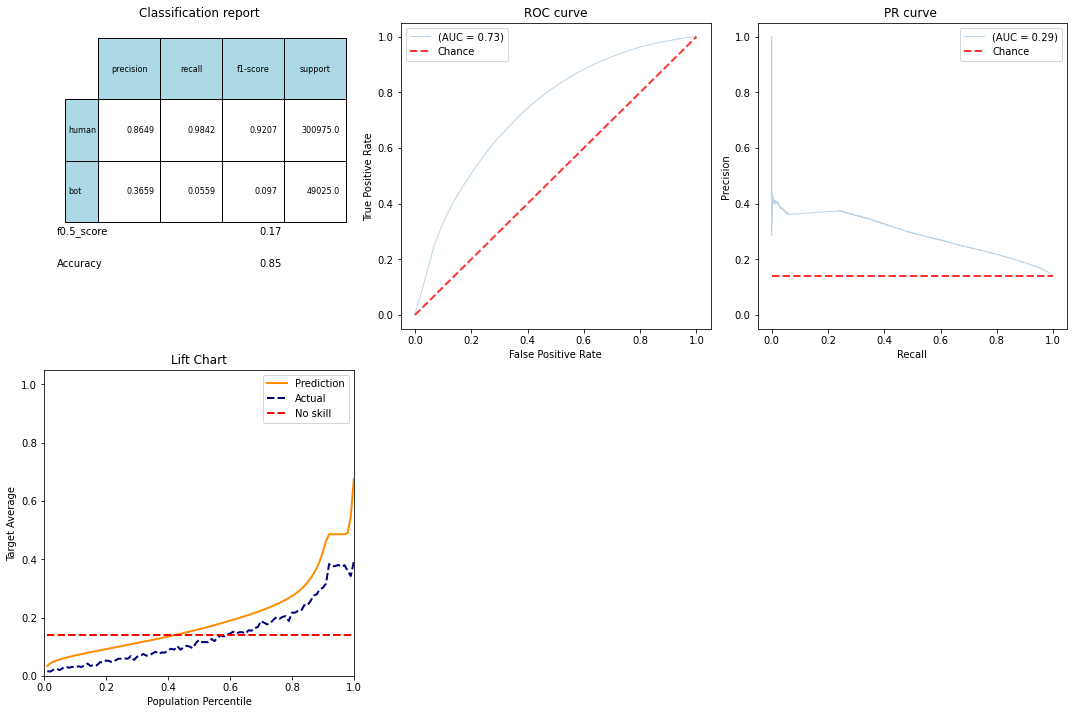

Imbalance compensation of 2.1:1


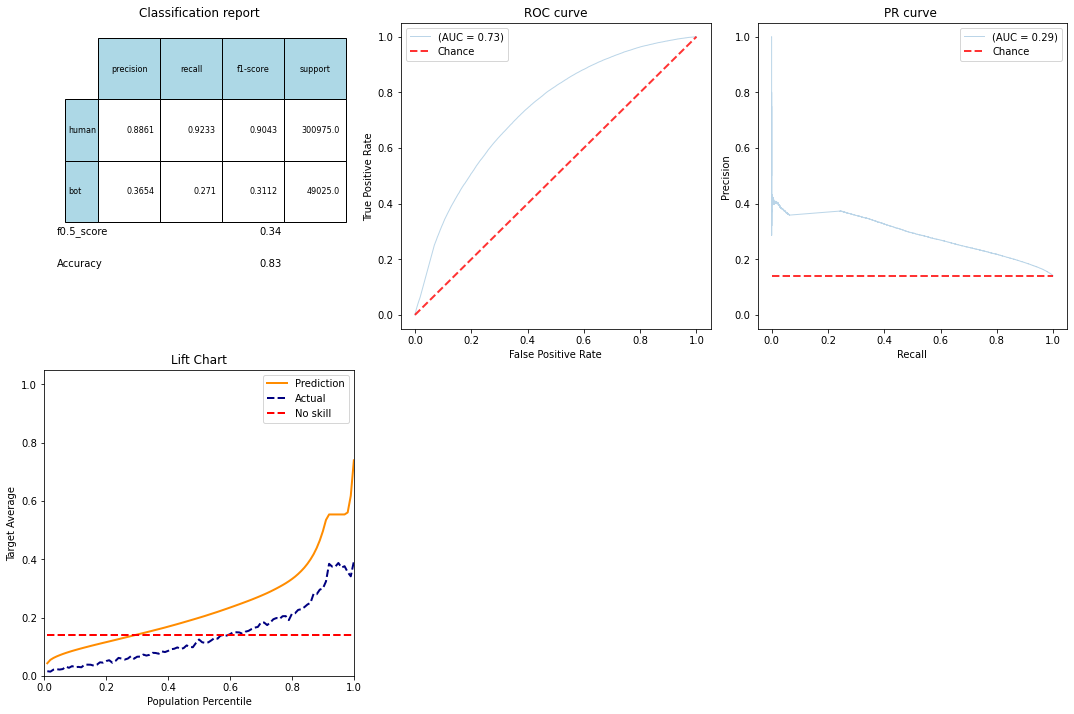

Imbalance compensation of 2.6:1


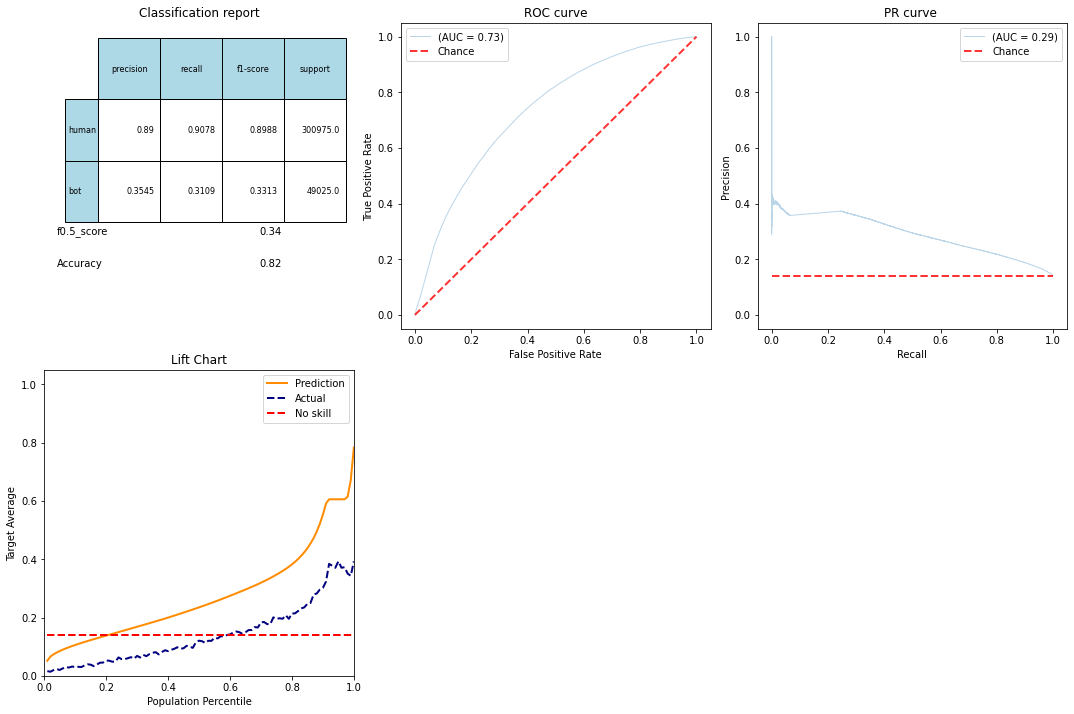

Imbalance compensation of 3.1:1


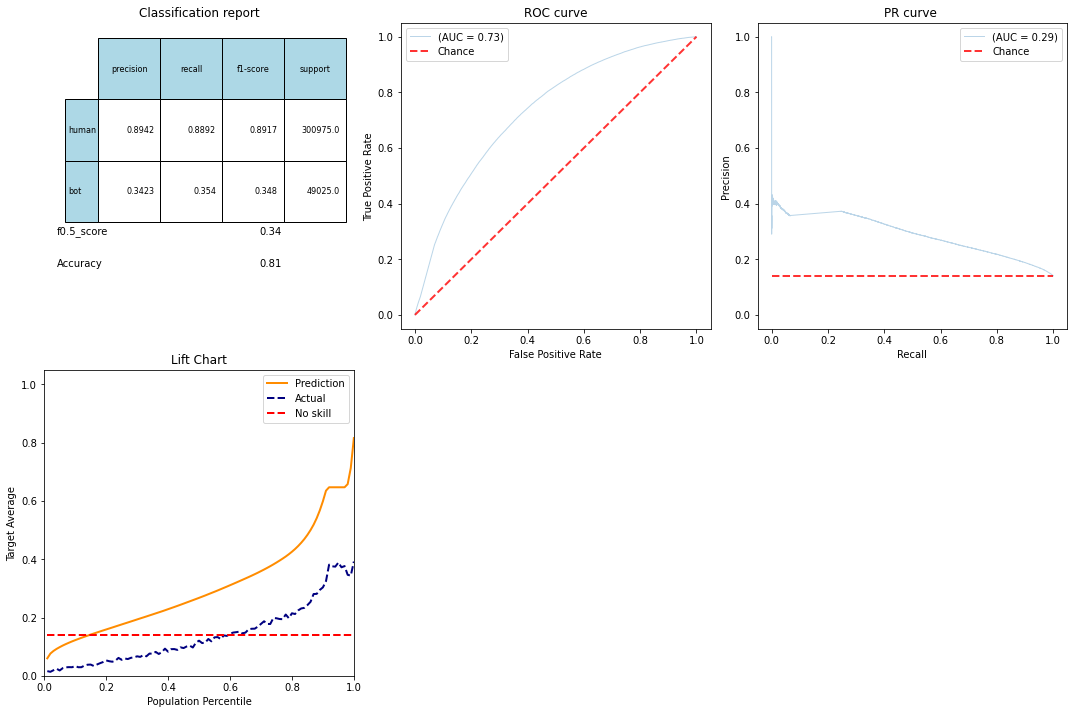

Imbalance compensation of 3.6:1


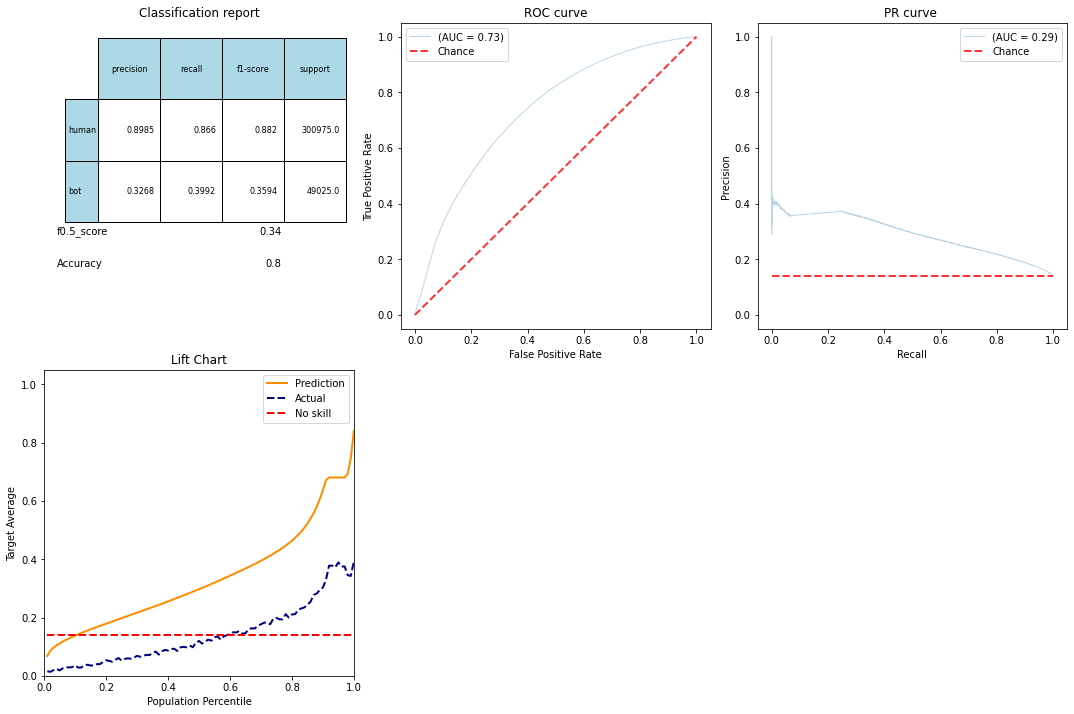

Imbalance compensation of 4.1:1


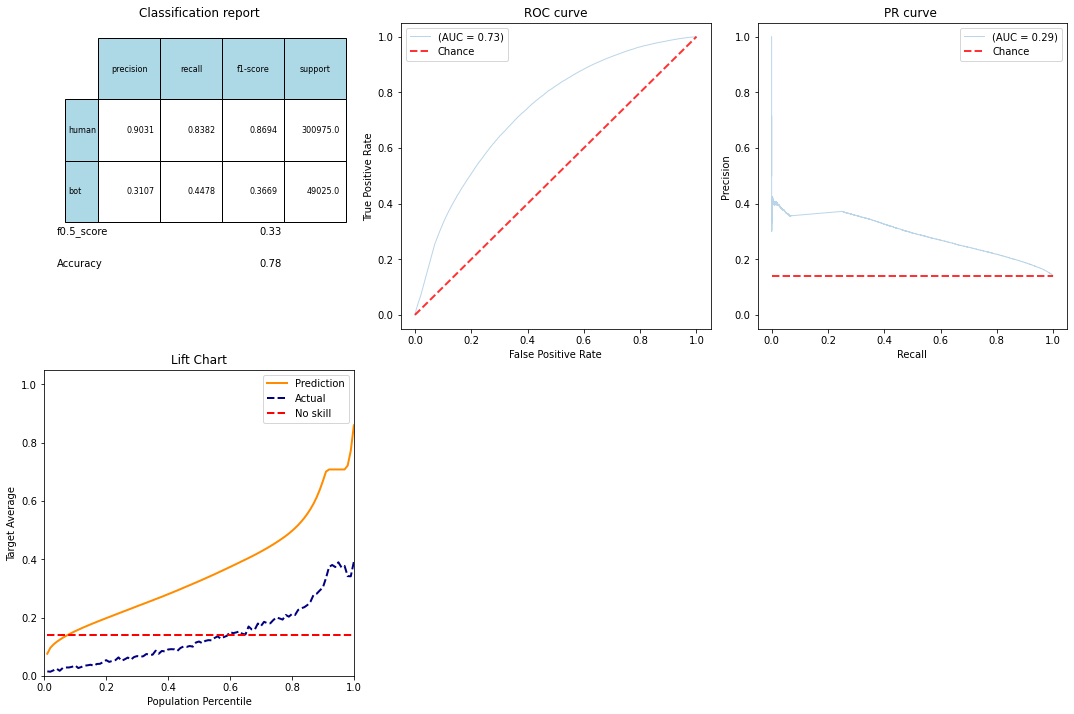

Imbalance compensation of 4.6:1


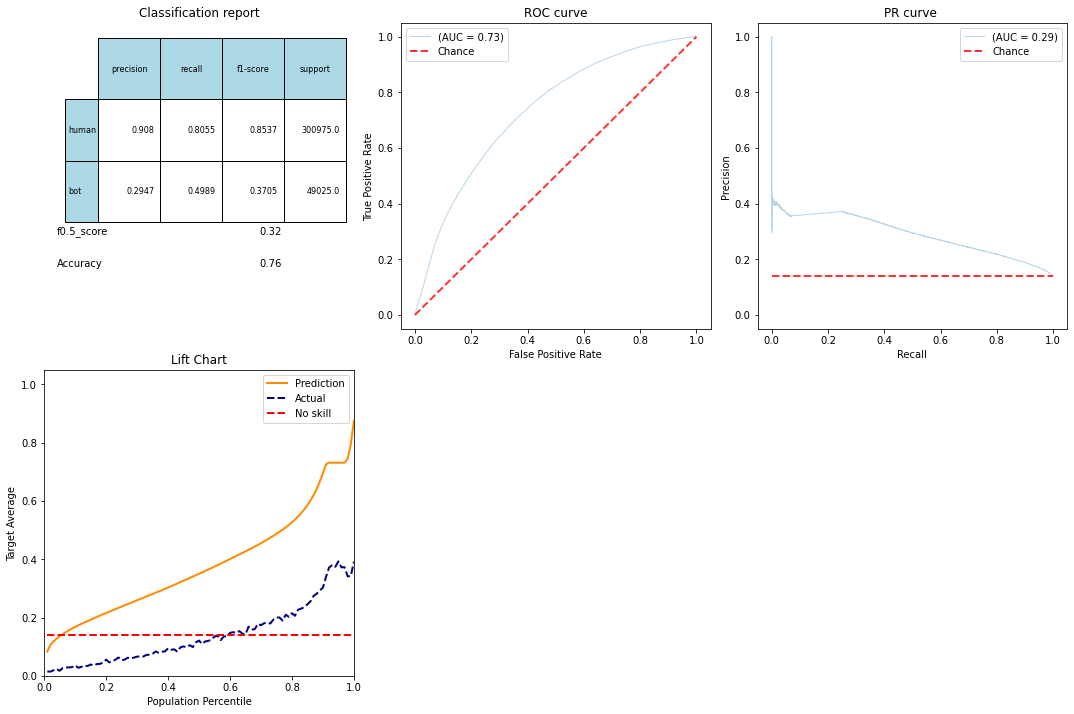

Imbalance compensation of 5.1:1


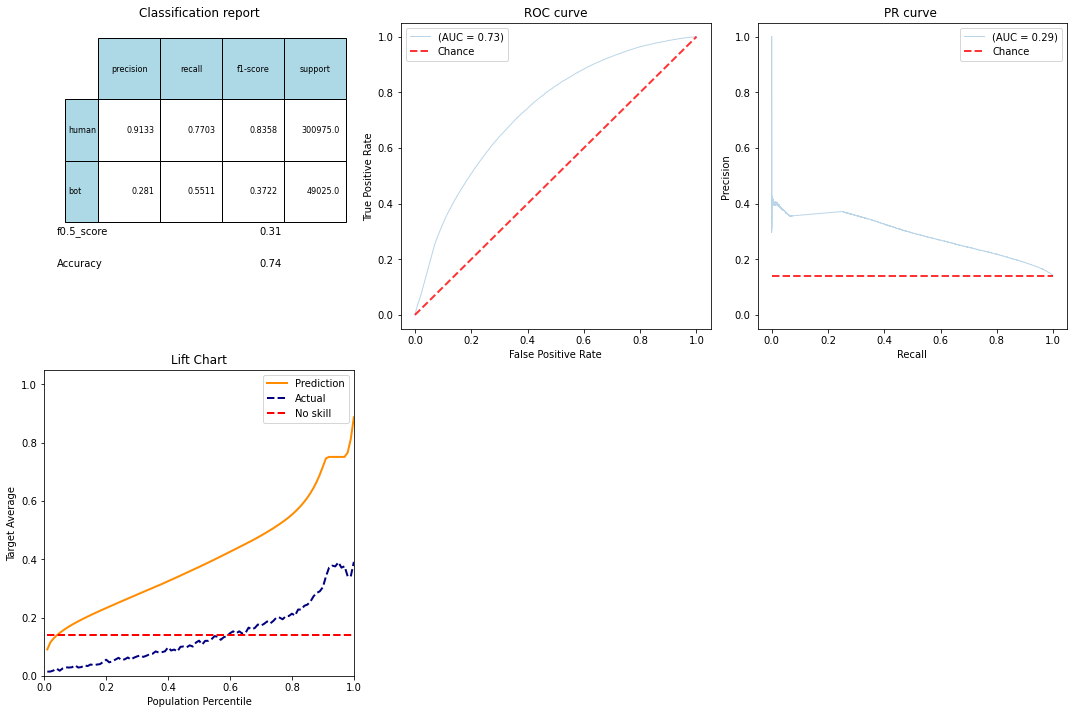

Imbalance compensation of 5.6:1


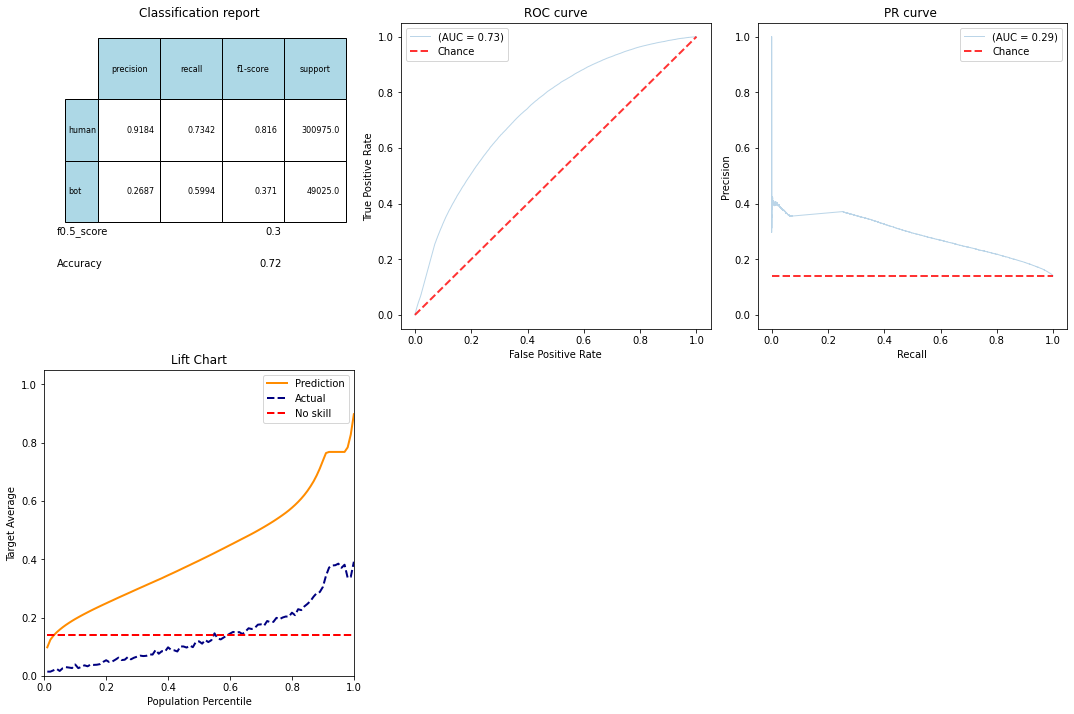

Imbalance compensation of 6.1:1


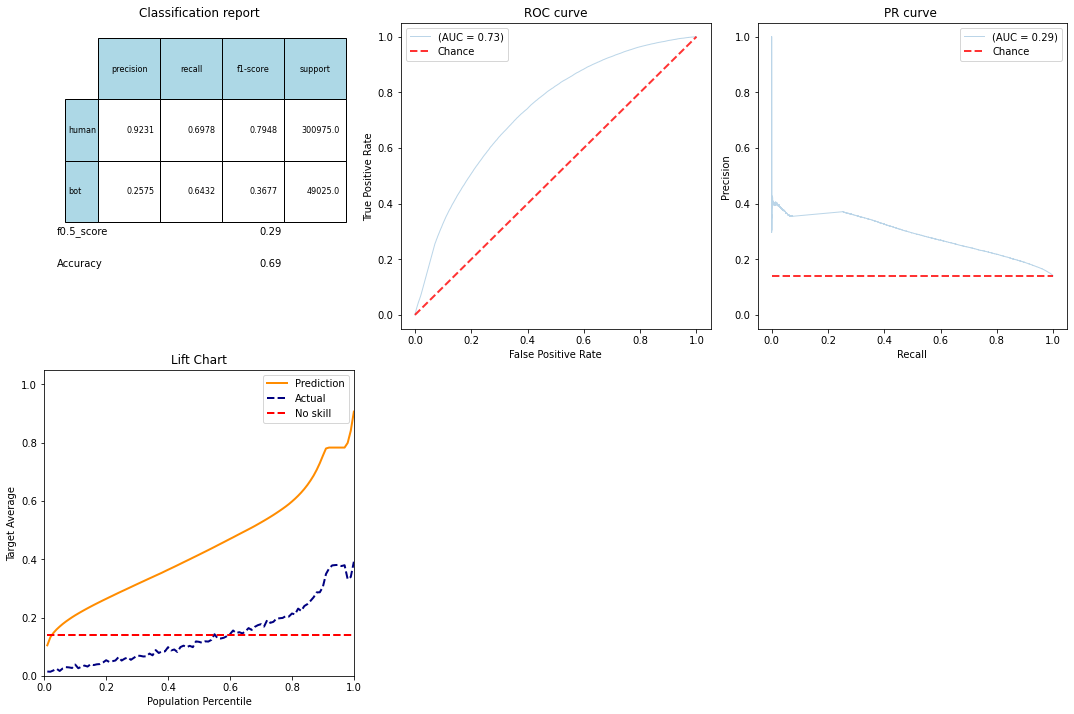

Imbalance compensation of 6.6:1


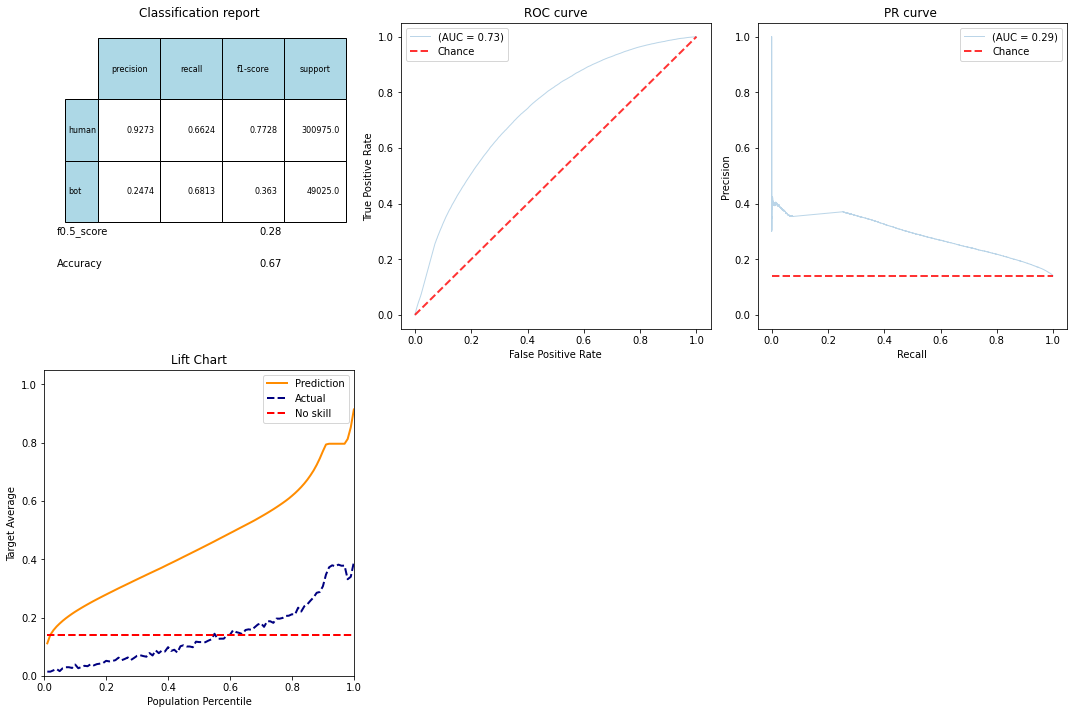

Imbalance compensation of 7.1:1


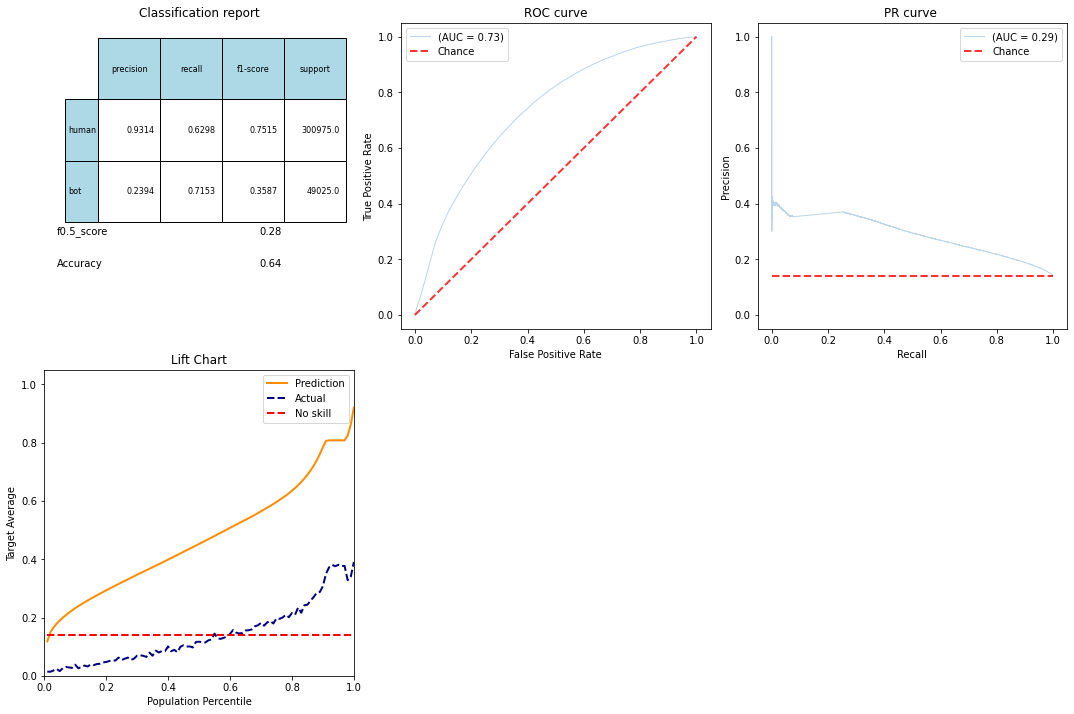

Imbalance compensation of 7.6:1


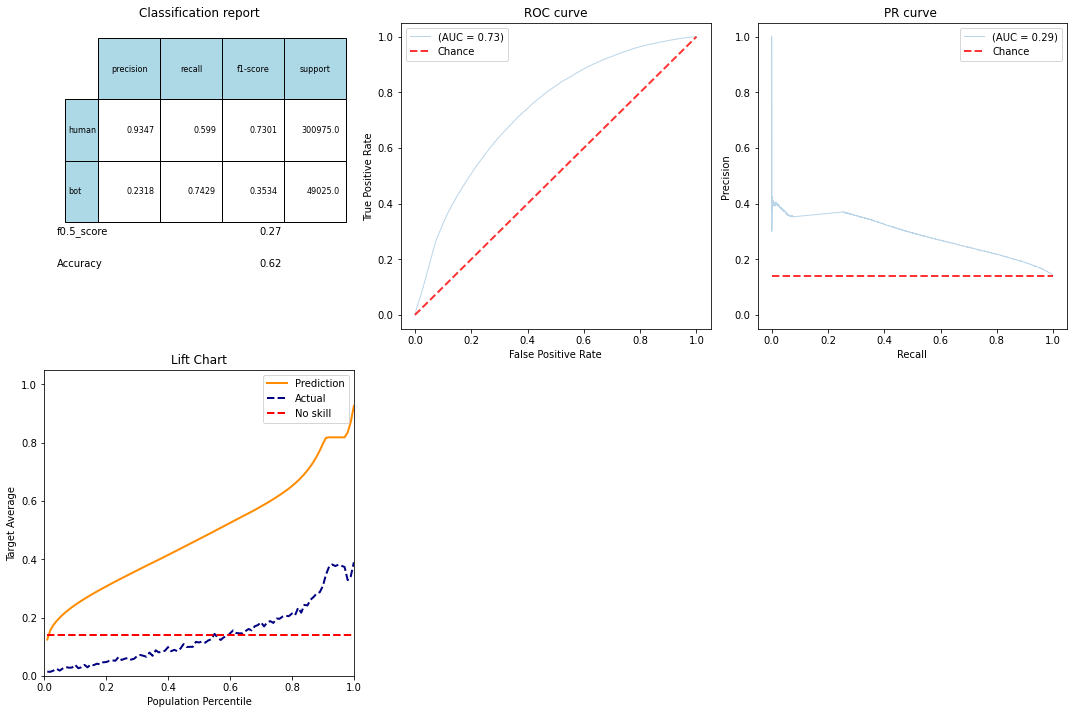

Imbalance compensation of 8.1:1


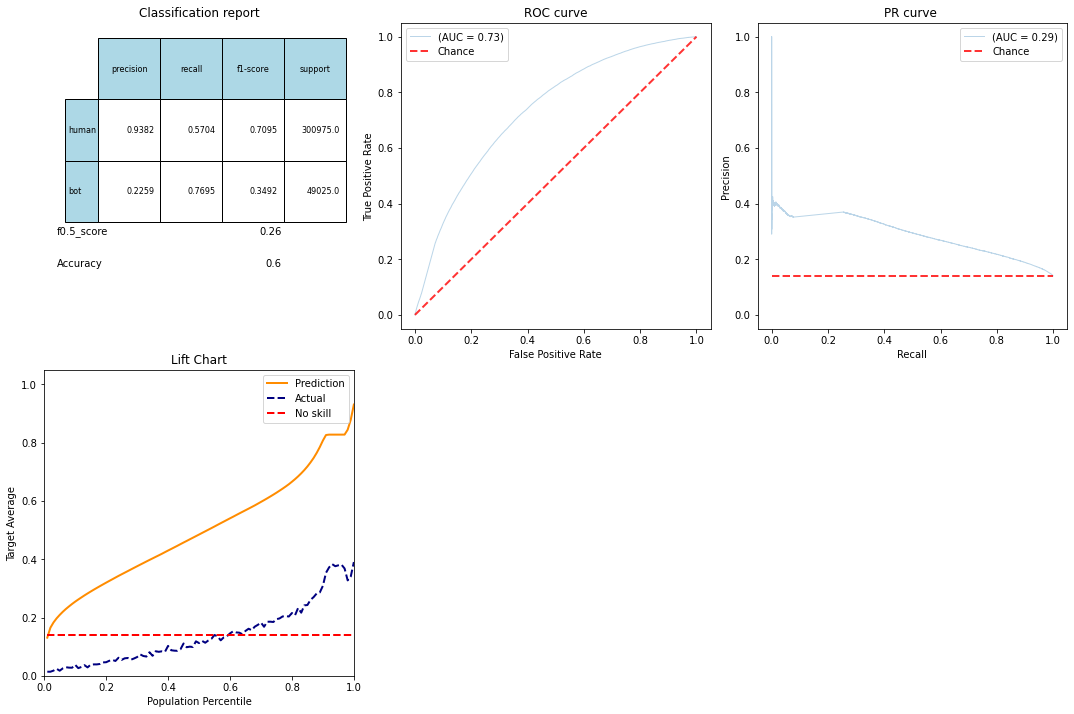

Imbalance compensation of 8.6:1


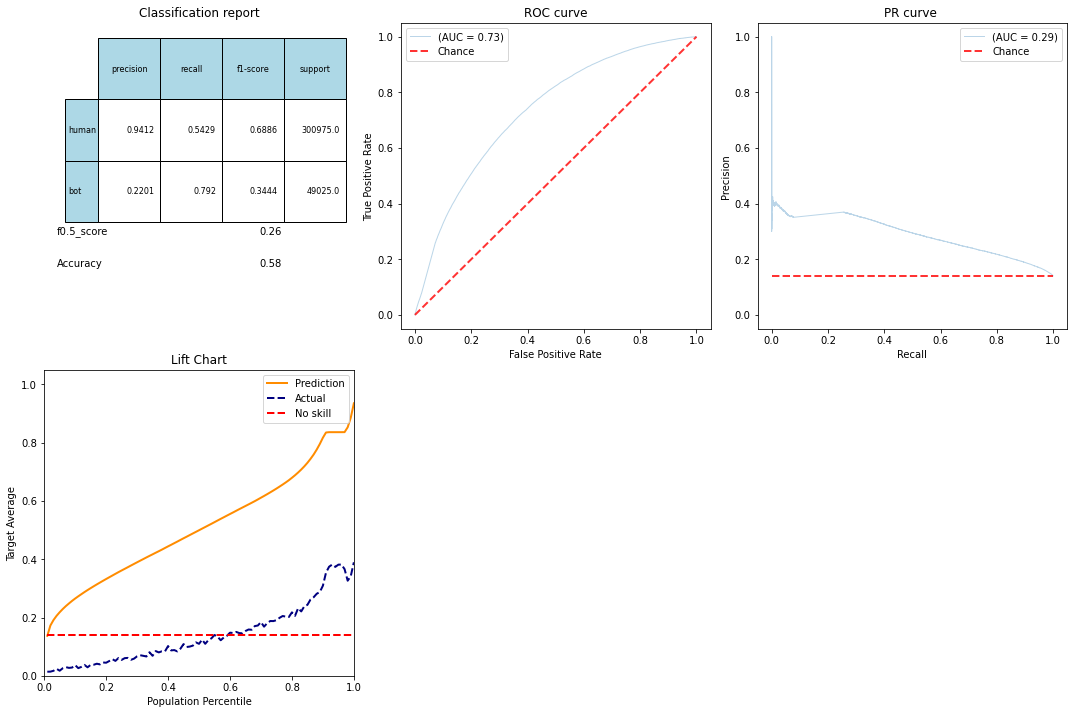

Imbalance compensation of 9.1:1


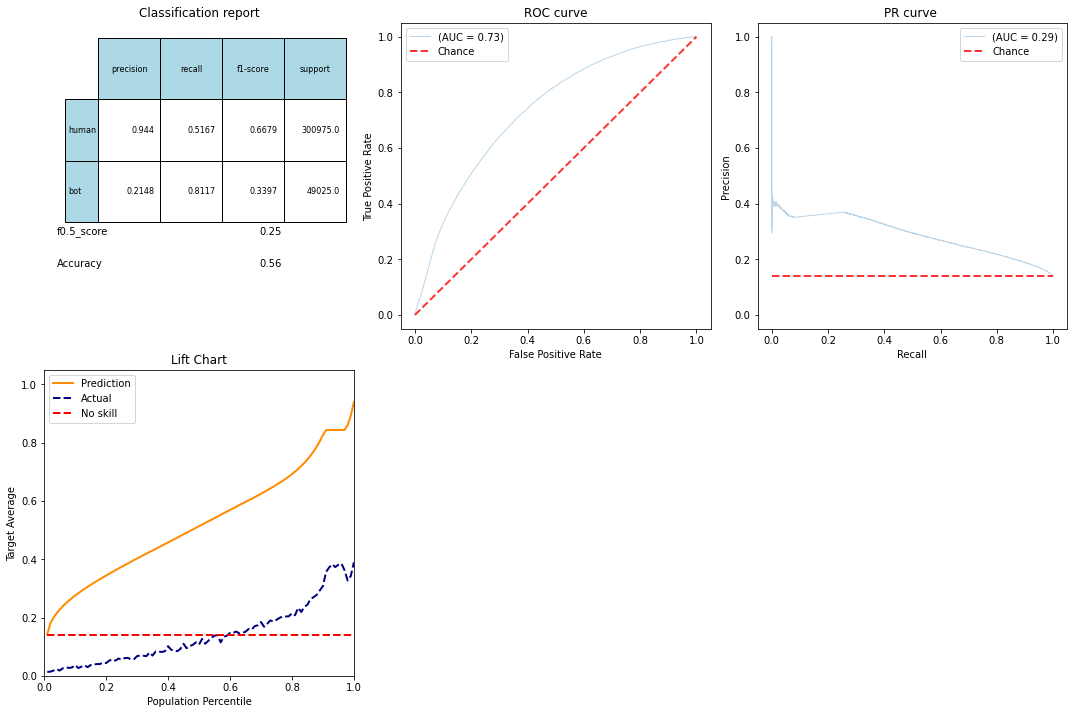

In [25]:
# scale fine-tuning
results_scale = {}
beta=0.5
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    print(f'Imbalance compensation of {scaling}:1')
    lr = LogisticRegression(
                             max_iter=1000, 
                             class_weight={1:scaling,0:1}
                            )
    lr.fit(X_train_encode_scaled, y_train)
    
    roc_auc, pr_auc, report, personalized_metrics = make_report(model = lr,
                                                                y_test = y_test, 
                                                                x_test = X_test_encode_scaled,  
                                                                include = ['class_report', 'roc', 'pr', 'lift'], 
                                                                pad=1,
                                                                scale=5,
                                                                personalized = {f'f{beta}_score':fbeta_score},
                                                                **{'beta':beta, 'pos_label':1})

    results_scale[scaling] = {'roc_auc':roc_auc, 'pr_auc':pr_auc, 'report':report, 'personalized_metrics':personalized_metrics}
    

In [27]:
# estimating performance
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba = True)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
accuracy_scorer = make_scorer(accuracy_score)
scaling_results = None
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    lr = LogisticRegression(
                             max_iter=1000, 
                             class_weight={1:scaling,0:1}
                            )
    cv_results = cross_validate(lr, 
                                X_train_encode_scaled, 
                                y_train, 
                                cv=5,
                                scoring={'f0.5_score':fpointfive_scorer, 'roc_auc':roc_auc_scorer, 'precision':precision_scorer, 'recall':recall_scorer, 'accuracy':accuracy_scorer})
    temp_df = pd.DataFrame(data=cv_results)
    temp_df.loc[:,"scale"] = [scaling]*temp_df.shape[0]
    scaling_results = pd.concat([scaling_results,temp_df])
    del lr, temp_df
    print(scaling)    

C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1


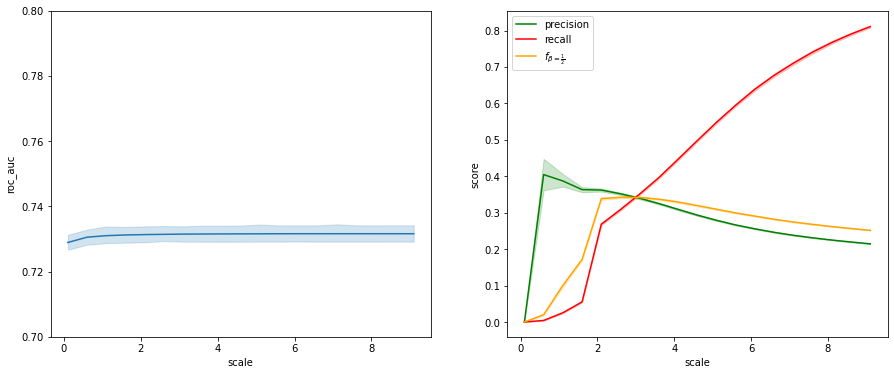

In [31]:
# performance against_sclae
plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax1= plt.subplot(122)
sns.lineplot(x='scale',
             y='test_roc_auc',
             data=scaling_results,
             ax=ax)
sns.lineplot(x='scale',
             y='test_precision',
             data=scaling_results,
             label='precision',
             color='green',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_recall',
             data=scaling_results,
             label='recall',
             color='red',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_f0.5_score',
             data=scaling_results,
             label=r'$f_{\beta = \frac{1}{2}}$',
             color='orange',
             ax=ax1)
ax1.legend()
ax1.set_ylabel('score')
ax.set_ylabel('roc_auc')
ax.set_ylim(0.7,0.8)
plt.show()

In [16]:
# estimating performance without log nor scaling
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba = True)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
accuracy_scorer = make_scorer(accuracy_score)
scaling_results = None
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    lr = LogisticRegression(
                             max_iter=1000, 
                             class_weight={1:scaling,0:1}
                            )
    cv_results = cross_validate(lr, 
                                X_train_encode, 
                                y_train, 
                                cv=5,
                                scoring={'f0.5_score':fpointfive_scorer, 'roc_auc':roc_auc_scorer, 'precision':precision_scorer, 'recall':recall_scorer, 'accuracy':accuracy_scorer})
    temp_df = pd.DataFrame(data=cv_results)
    temp_df.loc[:,"scale"] = [scaling]*temp_df.shape[0]
    scaling_results = pd.concat([scaling_results,temp_df])
    del lr, temp_df
    print(scaling)    

0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1


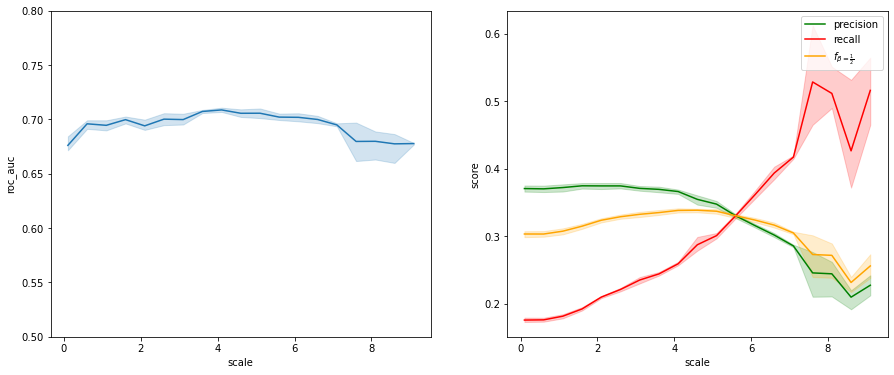

In [18]:
# performance against_sclae without log nor standard scaling
plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax1= plt.subplot(122)
sns.lineplot(x='scale',
             y='test_roc_auc',
             data=scaling_results,
             ax=ax)
sns.lineplot(x='scale',
             y='test_precision',
             data=scaling_results,
             label='precision',
             color='green',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_recall',
             data=scaling_results,
             label='recall',
             color='red',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_f0.5_score',
             data=scaling_results,
             label=r'$f_{\beta = \frac{1}{2}}$',
             color='orange',
             ax=ax1)
ax1.legend()
ax1.set_ylabel('score')
ax.set_ylabel('roc_auc')
ax.set_ylim(0.5,0.8)
plt.show()

### XG Boost

Imbalance compensation of 0.1:1


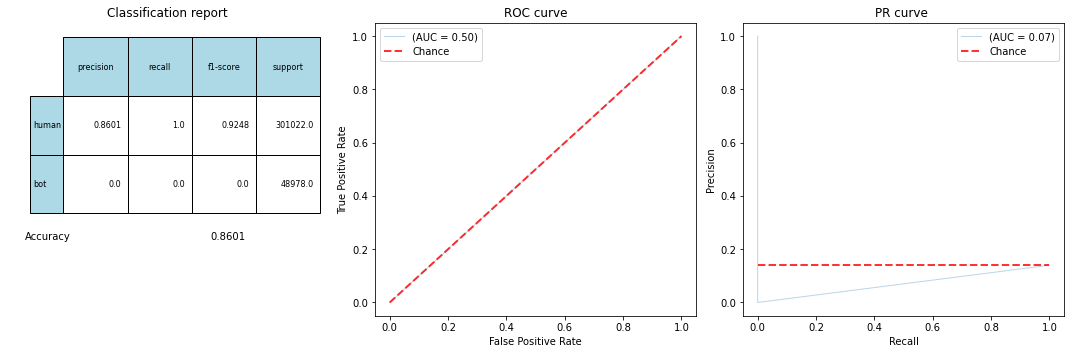

Imbalance compensation of 0.6:1


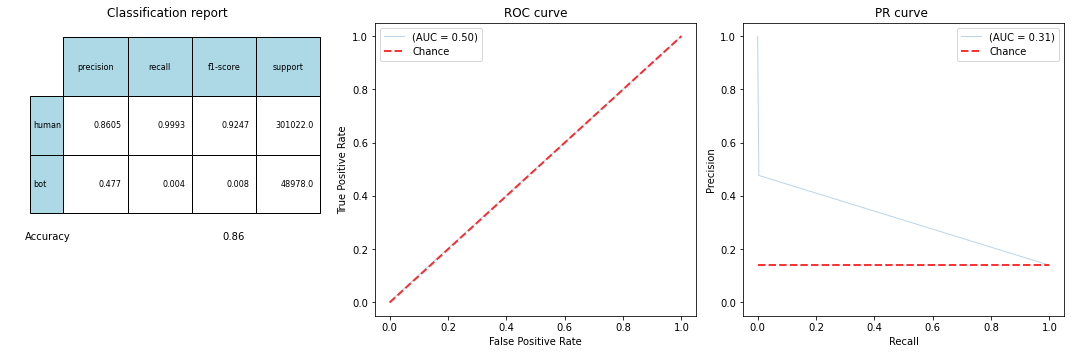

Imbalance compensation of 1.1:1


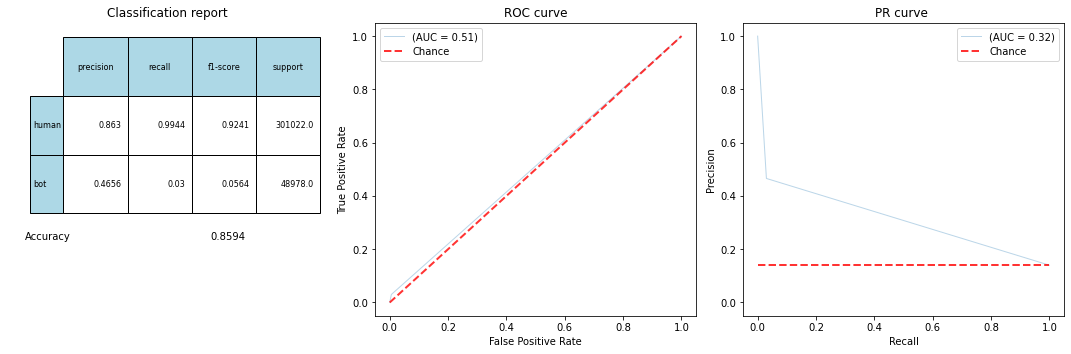

Imbalance compensation of 1.6:1


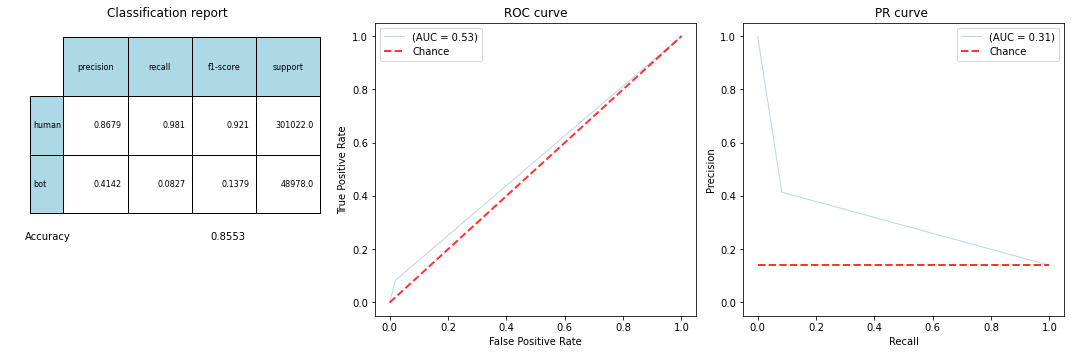

Imbalance compensation of 2.1:1


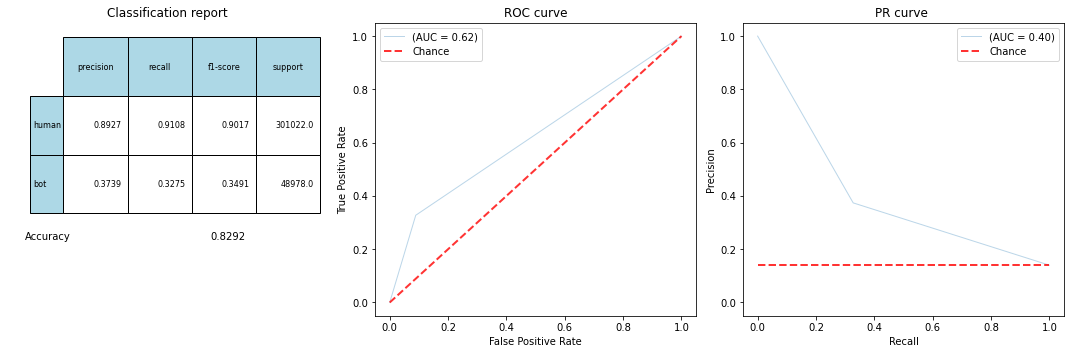

Imbalance compensation of 2.6:1


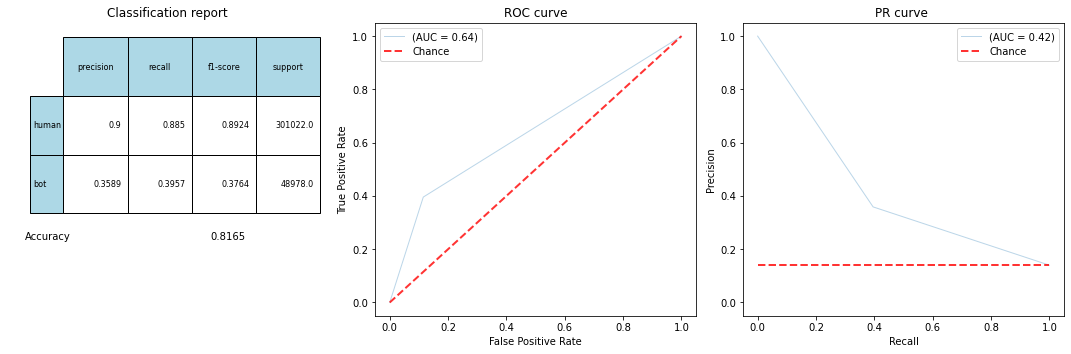

Imbalance compensation of 3.1:1


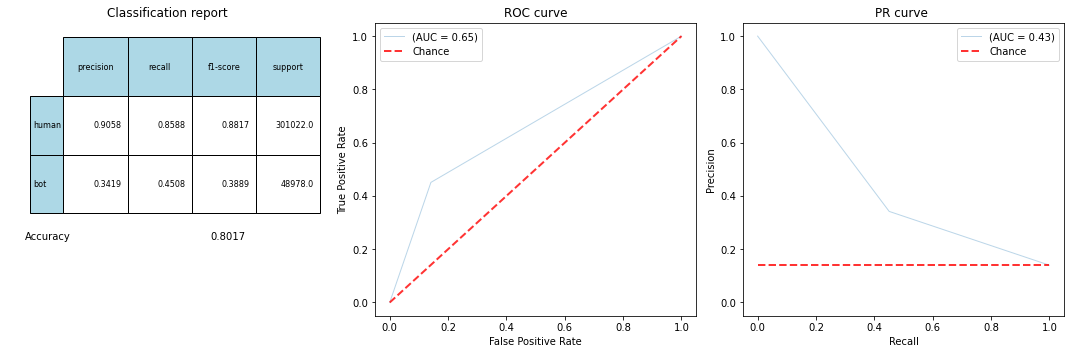

Imbalance compensation of 3.6:1


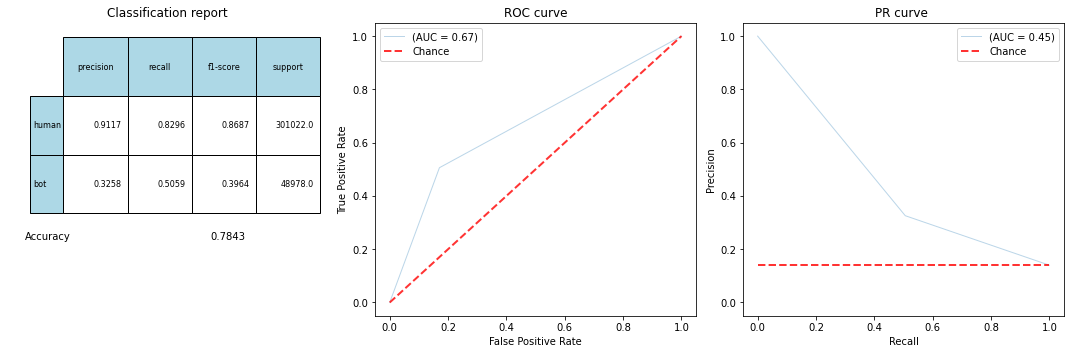

Imbalance compensation of 4.1:1


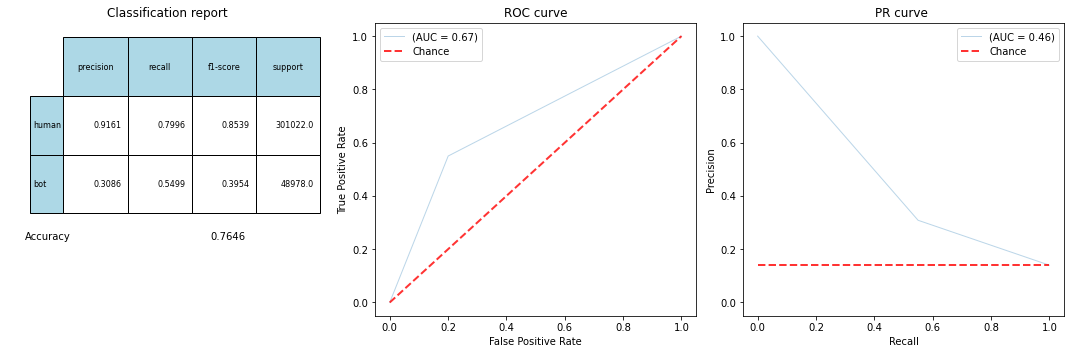

Imbalance compensation of 4.6:1


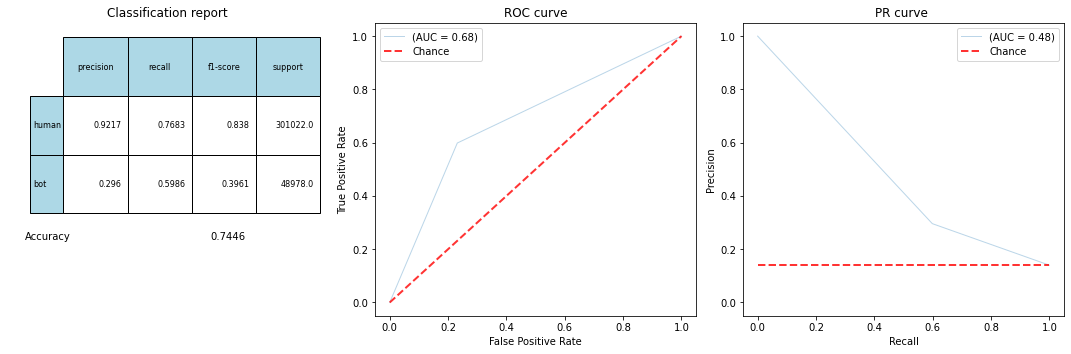

Imbalance compensation of 5.1:1


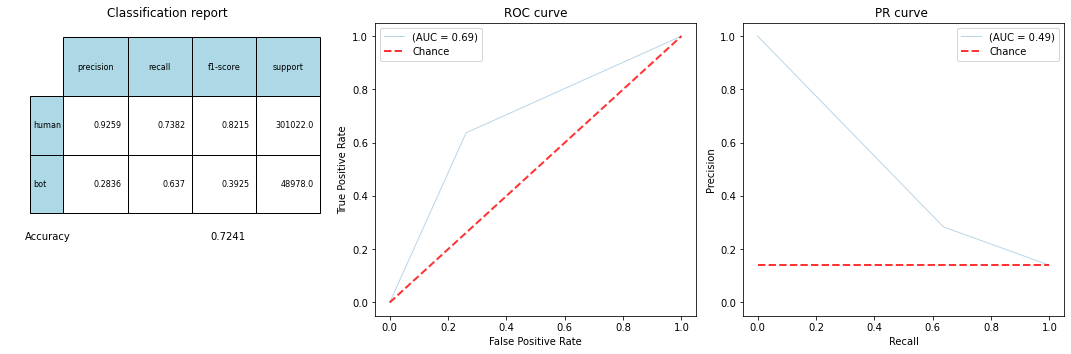

Imbalance compensation of 5.6:1


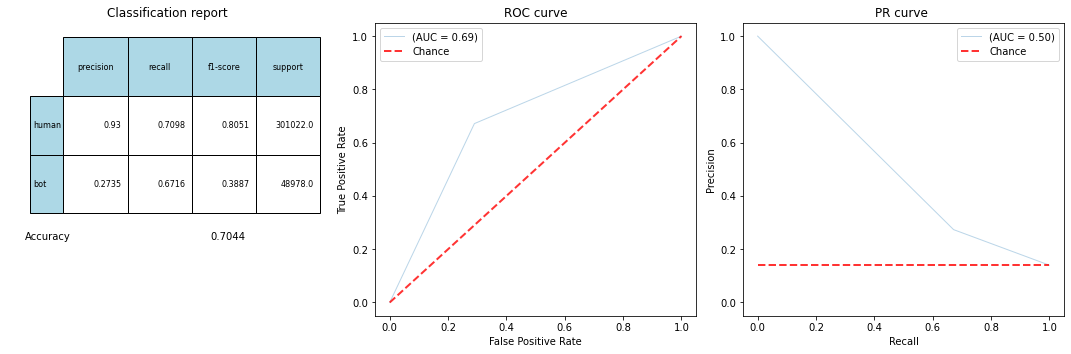

Imbalance compensation of 6.1:1


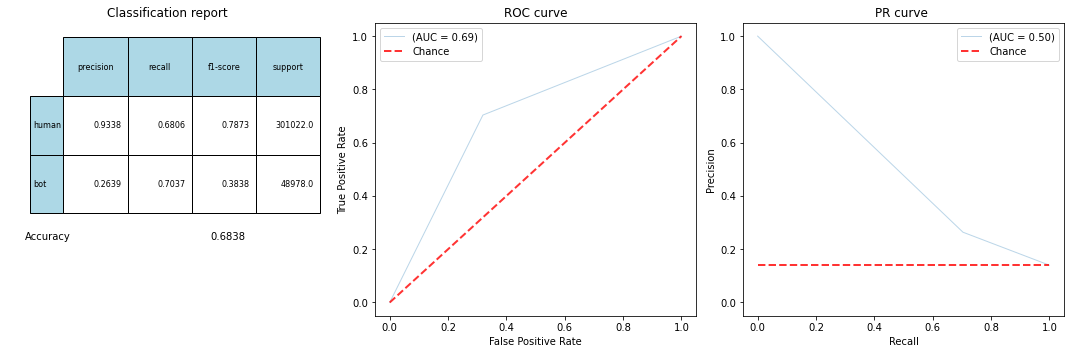

Imbalance compensation of 6.6:1


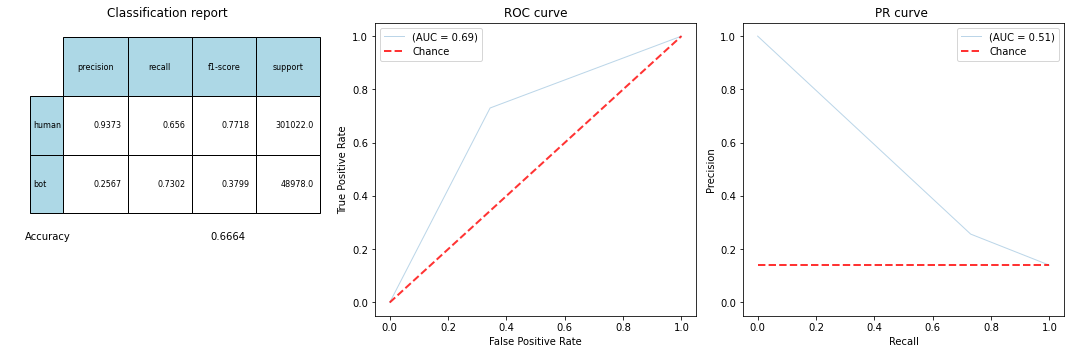

Imbalance compensation of 7.1:1


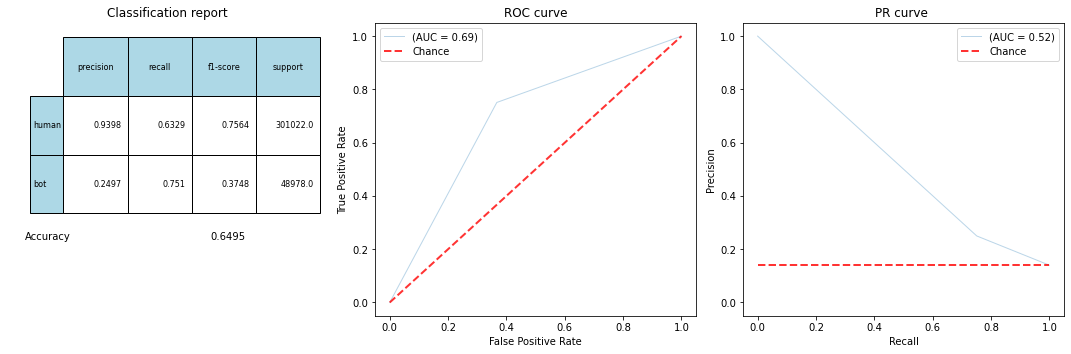

Imbalance compensation of 7.6:1


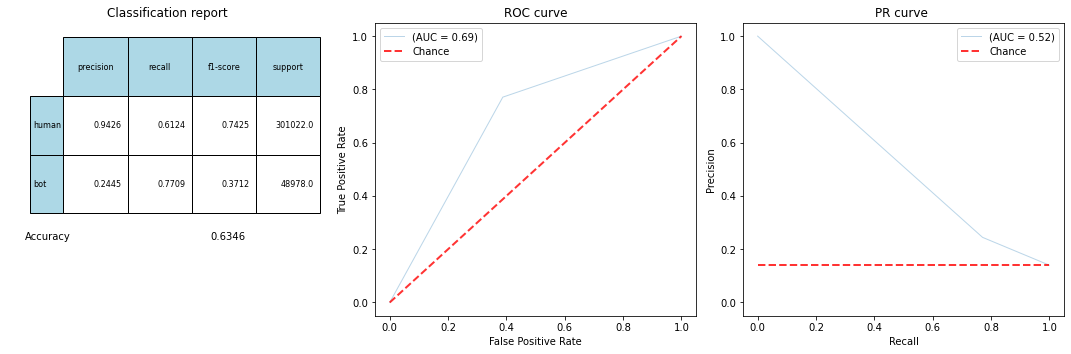

Imbalance compensation of 8.1:1


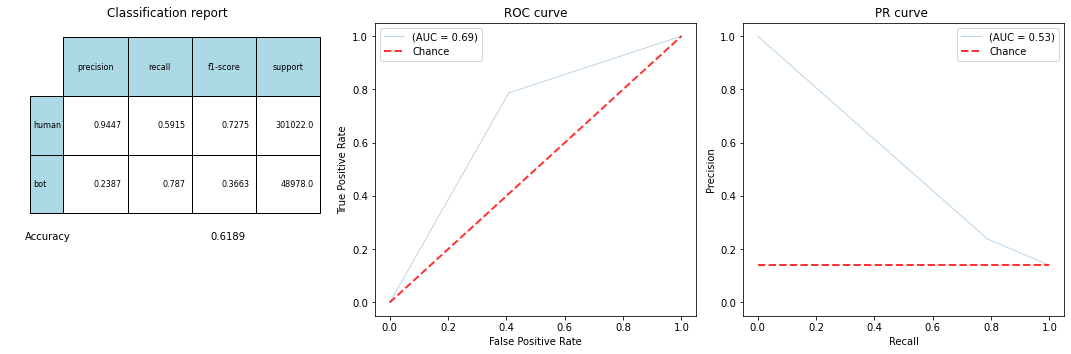

Imbalance compensation of 8.6:1


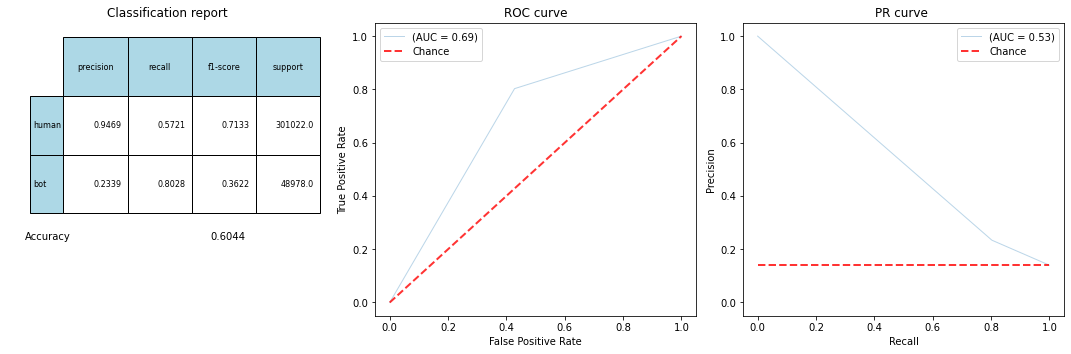

Imbalance compensation of 9.1:1


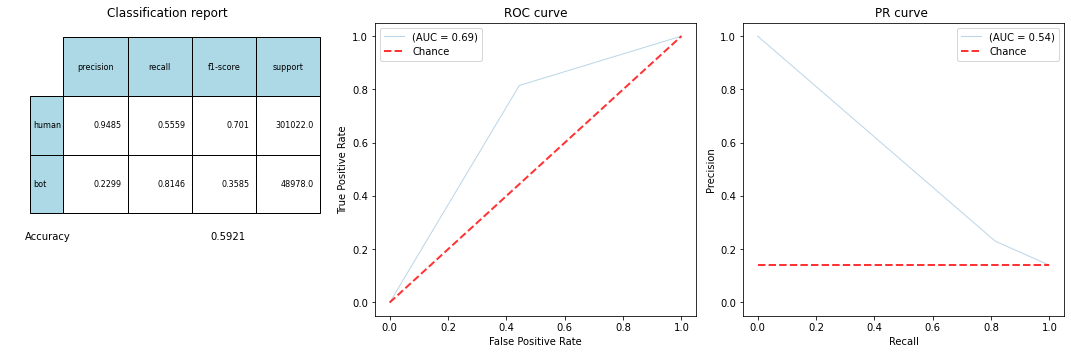

In [13]:
# scale fine-tuning
results_scale = {}
beta=0.5
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    print(f'Imbalance compensation of {scaling}:1')
    xgb = XGBClassifier(
                        max_iter=1000, 
                        class_weight={1:scaling,0:1}
                        )
    xgb.fit(X_train_encode, y_train)
    
    roc_auc, pr_auc, report, personalized_metrics = make_report(model = xgb,
                                                                y_test = y_test, 
                                                                x_test = X_test_encode,  
                                                                include = ['class_report', 'roc', 'pr'], 
                                                                pad=1,
                                                                scale=5,
                                                                personalized = {f'f{beta}_score':fbeta_score},
                                                                **{'beta':beta, 'pos_label':1})

    results_scale[scaling] = {'roc_auc':roc_auc, 'pr_auc':pr_auc, 'report':report, 'personalized_metrics':personalized_metrics}
    

In [21]:
# estimating performance
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
accuracy_scorer = make_scorer(accuracy_score)
scaling_results = None
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=scaling)
    cv_results = cross_validate(xgb, 
                                X_train_encode, 
                                y_train, 
                                cv=5,
                                scoring={'f0.5_score':fpointfive_scorer, 'roc_auc':roc_auc_scorer, 'precision':precision_scorer, 'recall':recall_scorer, 'accuracy':accuracy_scorer})
    temp_df = pd.DataFrame(data=cv_results)
    temp_df.loc[:,"scale"] = [scaling]*temp_df.shape[0]
    scaling_results = pd.concat([scaling_results,temp_df])
    del xgb, temp_df
    print(scaling)    

C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1


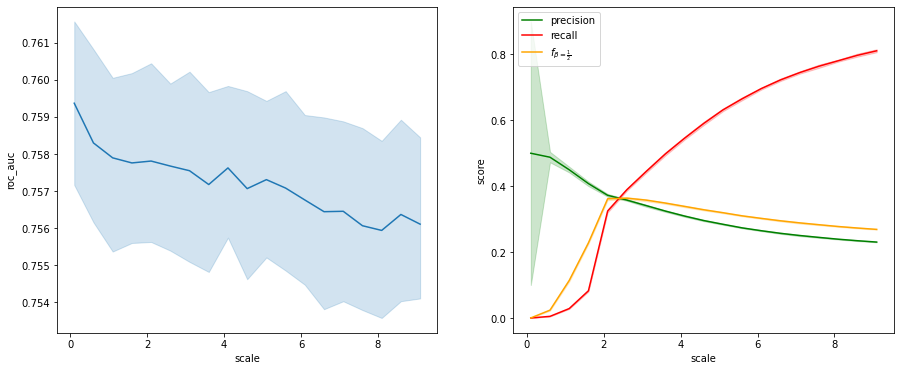

In [22]:
# performance against_sclae
plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax1= plt.subplot(122)
sns.lineplot(x='scale',
             y='test_roc_auc',
             data=scaling_results,
             ax=ax)
sns.lineplot(x='scale',
             y='test_precision',
             data=scaling_results,
             label='precision',
             color='green',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_recall',
             data=scaling_results,
             label='recall',
             color='red',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_f0.5_score',
             data=scaling_results,
             label=r'$f_{\beta = \frac{1}{2}}$',
             color='orange',
             ax=ax1)
ax1.legend()
ax1.set_ylabel('score')
ax.set_ylabel('roc_auc')
plt.show()

### Final model exploring

In [23]:
X_train_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 650000 entries, 400294 to 472907
Data columns (total 30 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   aaa_total_number_mentions                          650000 non-null  float64
 1   aaa_number_tweets_sample                           650000 non-null  float64
 2   aaa_number_tweets_with_mention                     650000 non-null  float64
 3   aaa_unique_number_mentions                         650000 non-null  float64
 4   aaa_avg_number_mentions_tweet                      650000 non-null  float64
 5   aaa_avg_number_mentions_tweet_with_mention         650000 non-null  float64
 6   aaa_avg_number_unique_mentions_tweet               650000 non-null  float64
 7   aaa_avg_number_unique_mentions_tweet_with_mention  650000 non-null  float64
 8   aaa_rate_tweets_with_mention                       650000 non-null  f

# Bagged classifier

## All data classifier

### Getting data ready

In [5]:
# data ready
exclude = ['aaa_core_number_tweets', 'aaa_user_id_anon', 'user_id_anon', 'target']

all_features = [i for i in data.columns if i not in exclude]

categorical_features = ['aaa_less_used_language', 'aaa_mode_language', 'aaa_mode_type_corrected']

cast_to_float = ['aaa_mode_month_activity', 'aaa_mode_day_activity', 'aaa_mode_day_of_week_activity', 'aaa_mode_hour_activity', 'aaa_max_actv_freq_minutes', 'aaa_min_actv_freq_minutes', 'aaa_avg_actv_freq_minutes', 'aaa_median_actv_freq_minutes']

cast_to_int = ['uuu_year_joined', 'uuu_month_joined', 'uuu_day_of_month_joined', 'uuu_day_of_week_joined', 'uuu_hour_joined']

df_all_features = data[all_features + ["target"]].copy()

In [6]:
df_all_features.loc[:,'aaa_number_tweets_sample'] = df_all_features['aaa_number_tweets_sample'].fillna(0)
df_all_features.loc[:,categorical_features] = df_all_features[categorical_features].fillna('-1')
df_all_features.fillna(-1, inplace=True)

In [8]:
X = df_all_features.drop(columns="target").copy()
y = df_all_features.target.copy()

X_train, X_test, y_train, y_test = train_test_split(
                                                     X, 
                                                     y, 
                                                     test_size=0.35, 
                                                     random_state=12
                                                    )

In [9]:
target_catencoder = target_encoder.TargetEncoder(cols=categorical_features)
target_catencoder.fit(X_train, y_train)

X_train_encode = target_catencoder.transform(X_train)
X_test_encode = target_catencoder.transform(X_test)

### Benchmarking

In [11]:
# benchmark

rf = RandomForestClassifier()
xgb = XGBClassifier()
lr = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier()
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
roc_auc_scorer = make_scorer(roc_auc_score)
all_models = {"RandomForest":rf, "XGBoost":xgb, "LogisticRegression":lr, "KNeighbors":knn}

result = {}
for name, model in zip(all_models.keys(),all_models.values()):
    cv_results = cross_validate(
                                model, 
                                X_train_encode, 
                                y_train, 
                                cv=5,
                                scoring={'f0.5':fpointfive_scorer, 'roc_auc':roc_auc_scorer}
                                )
    result[name] = cv_results
    mean_fb = round(np.mean(cv_results['test_f0.5']),4)
    sigma_fb = round(np.std(cv_results['test_f0.5']),4)
    
    mean_roc_auc = round(np.mean(cv_results['test_roc_auc']),4)
    sigma_roc_auc = round(np.std(cv_results['test_roc_auc']),4)
    
    print(f'Model: {name}')
    print(f'fbeta: {mean_fb} +- {sigma_fb}')
    print(f'roc_auc: {mean_roc_auc} +- {sigma_roc_auc}\n')

Model: RandomForest
fbeta: 0.3919 +- 0.0029
roc_auc: 0.5712 +- 0.0009

Model: XGBoost
fbeta: 0.4414 +- 0.0043
roc_auc: 0.5954 +- 0.0012

Model: LogisticRegression
fbeta: 0.025 +- 0.0048
roc_auc: 0.5021 +- 0.0005

Model: KNeighbors
fbeta: 0.291 +- 0.0036
roc_auc: 0.5578 +- 0.0011



### Balancing classes

In [10]:
ideal = len(y[y==0])/len(y[y==1])
print(ideal)

6.145766490642619


Imbalance compensation of 0.1:1


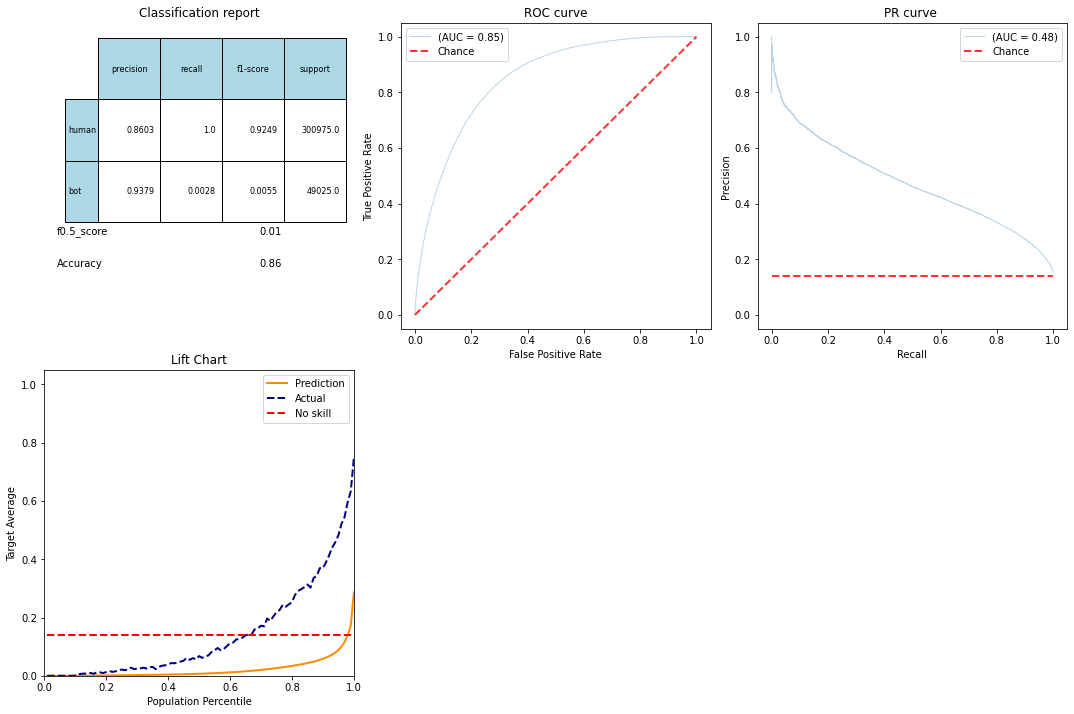

Imbalance compensation of 0.6:1


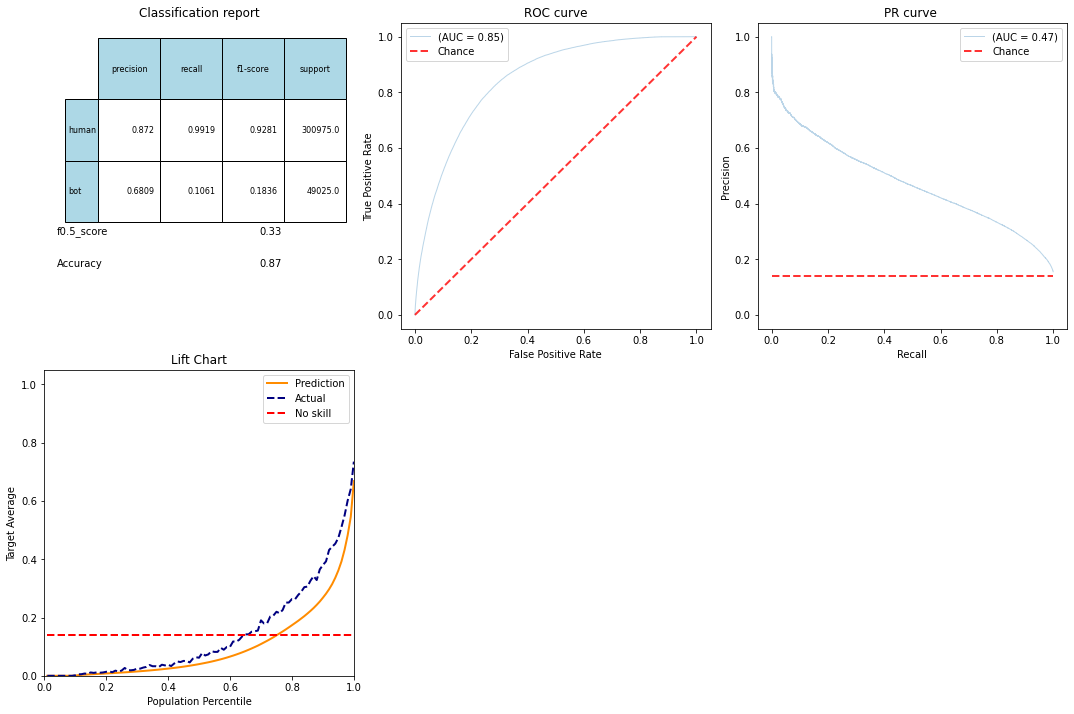

Imbalance compensation of 1.1:1


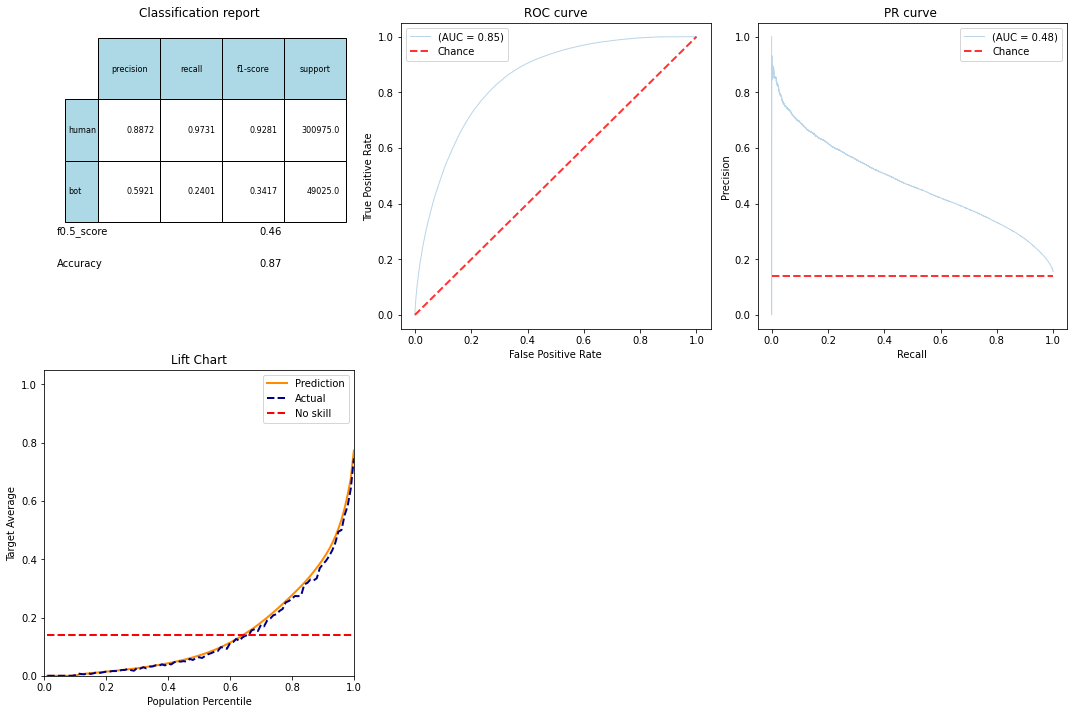

Imbalance compensation of 1.6:1


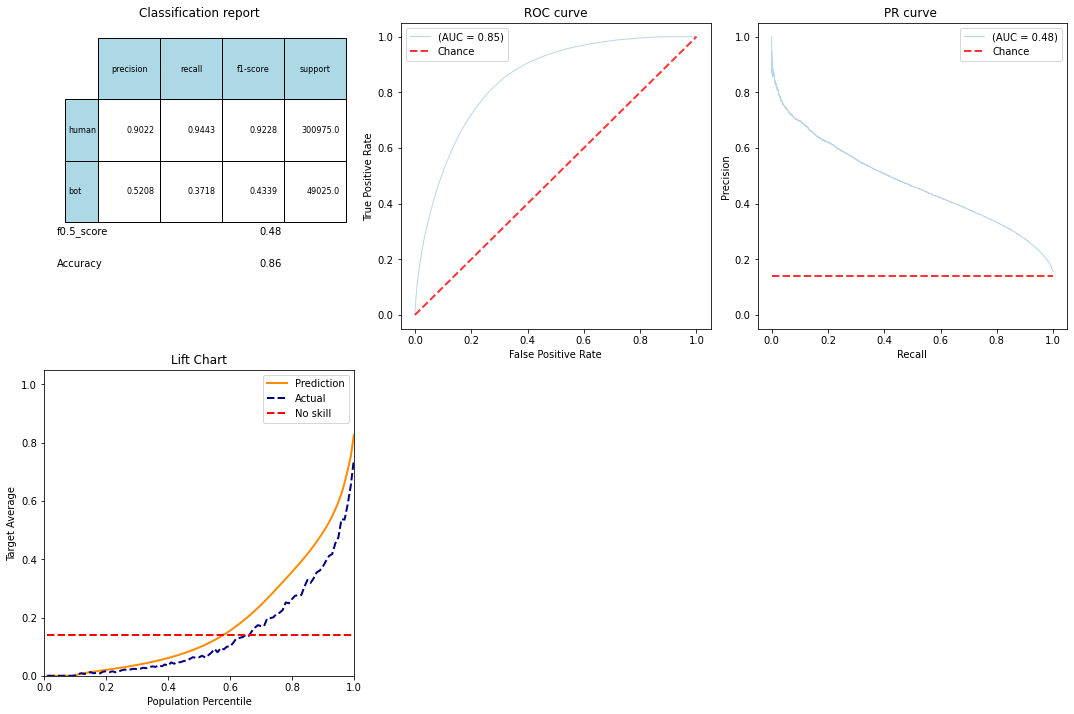

Imbalance compensation of 2.1:1


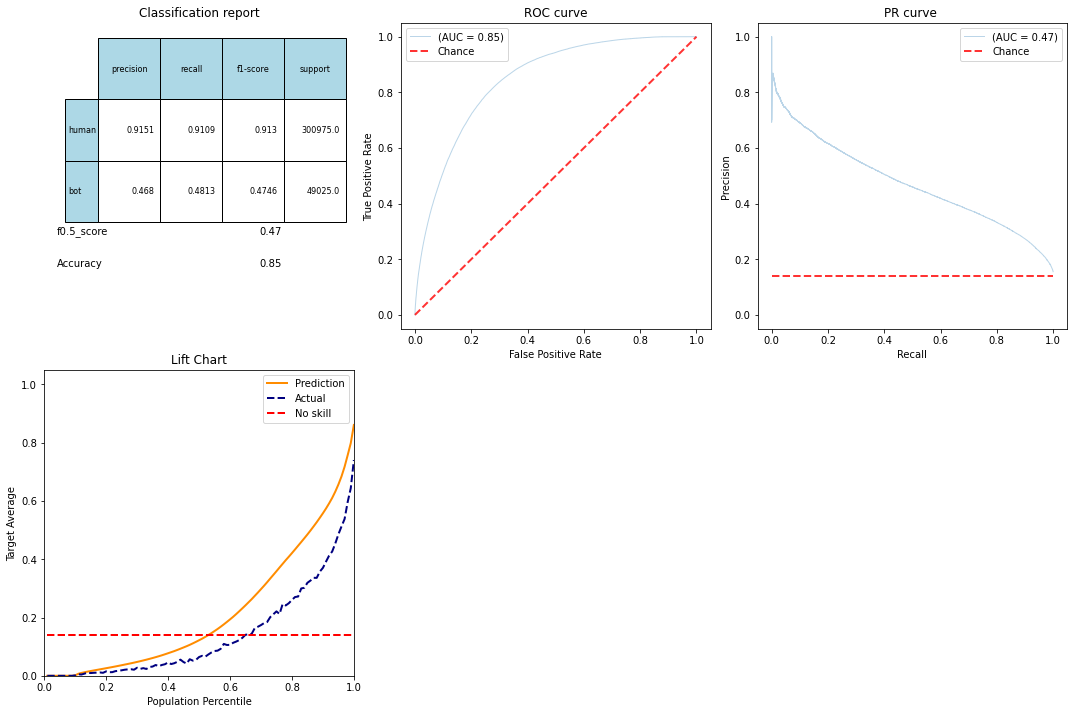

Imbalance compensation of 2.6:1


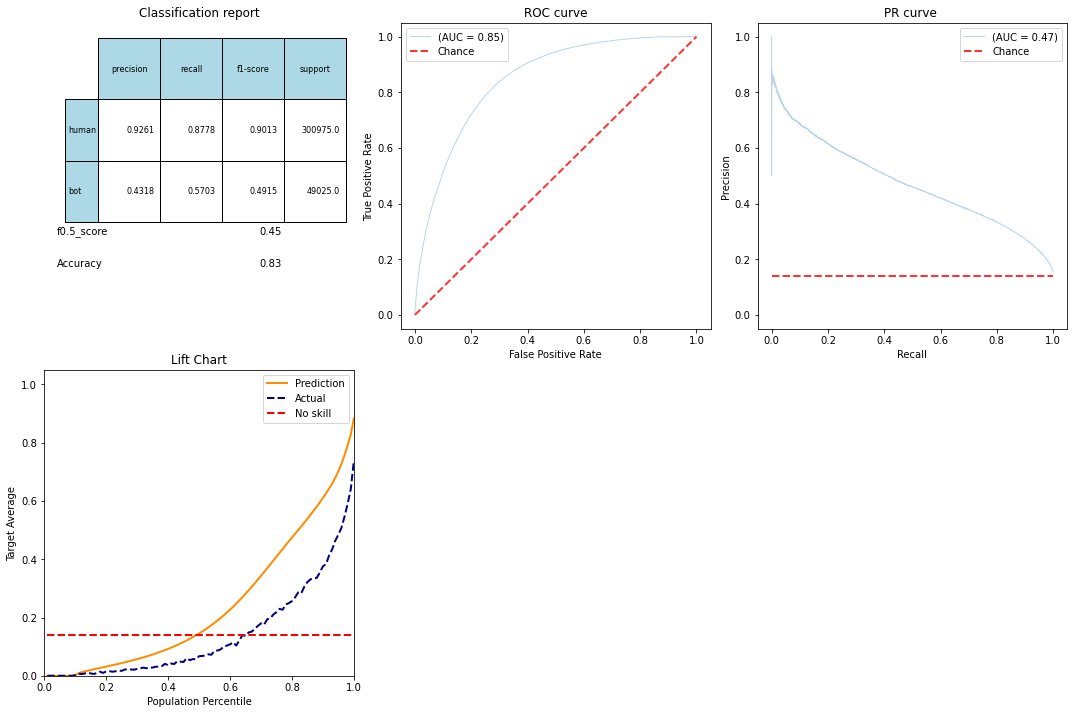

Imbalance compensation of 3.1:1


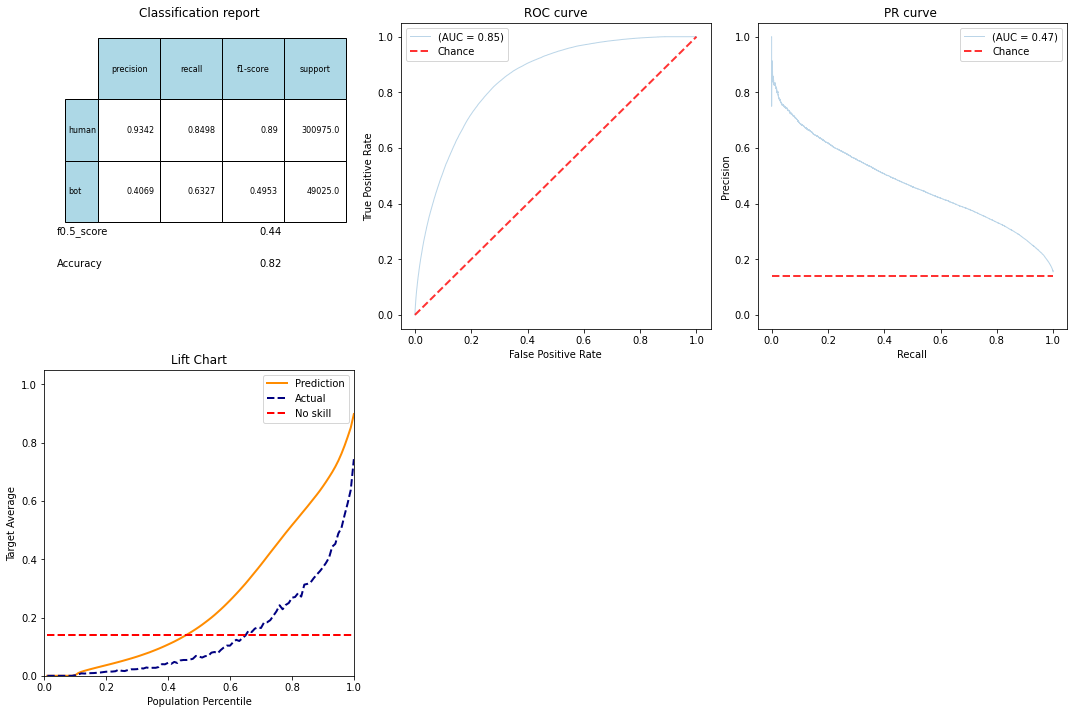

Imbalance compensation of 3.6:1


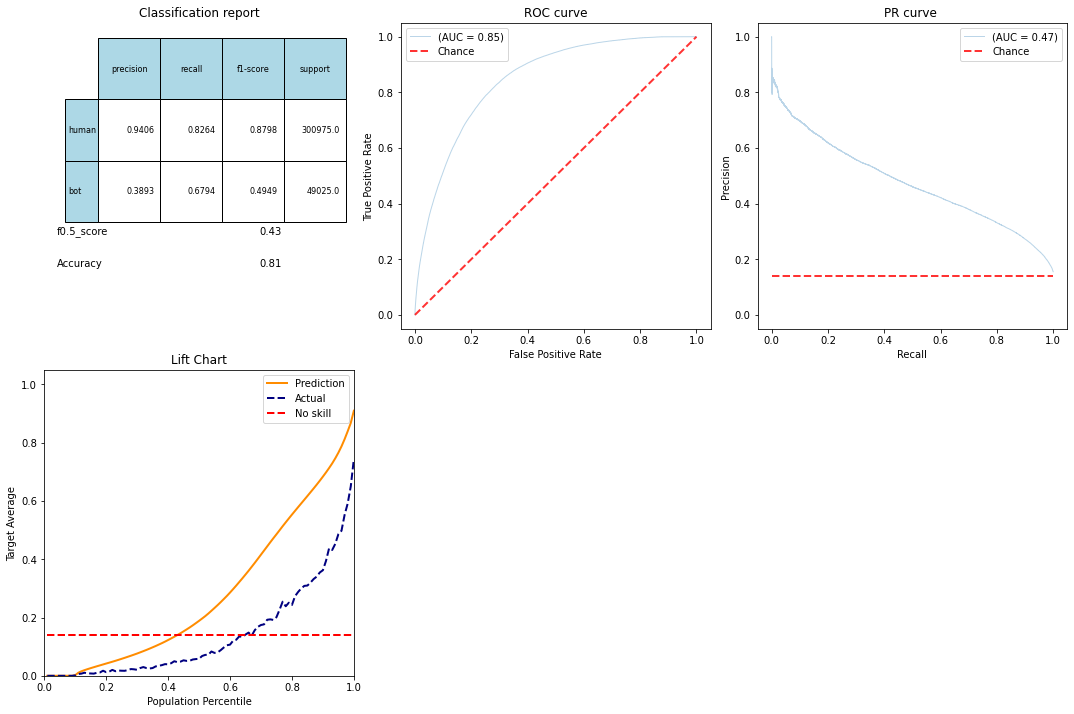

Imbalance compensation of 4.1:1


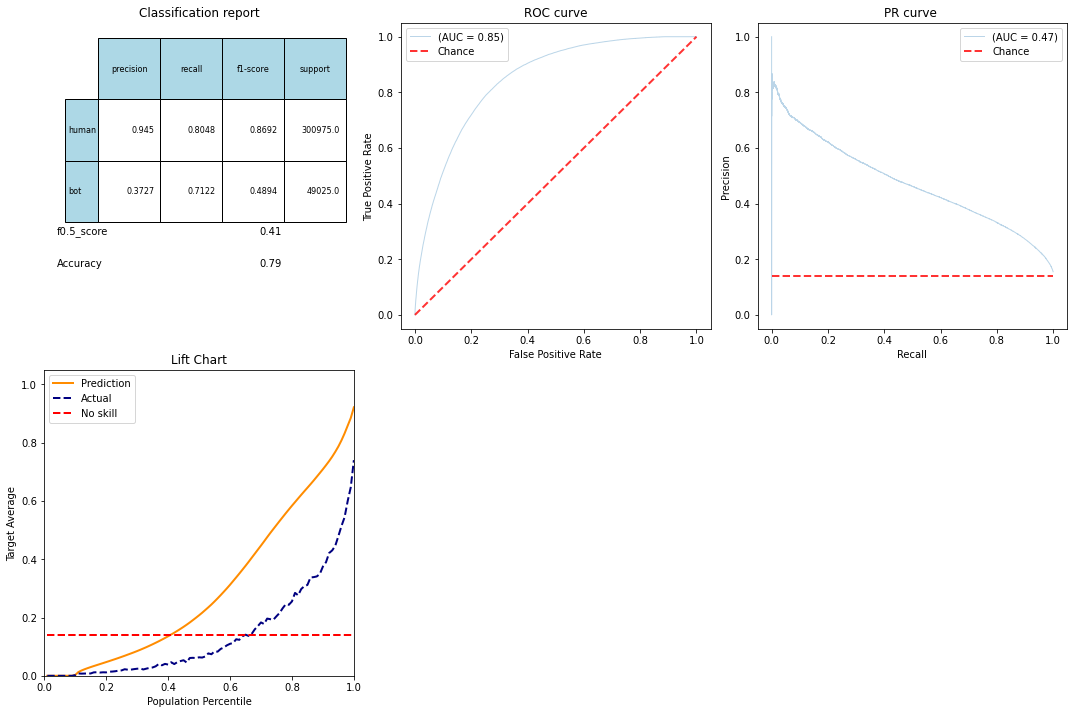

Imbalance compensation of 4.6:1


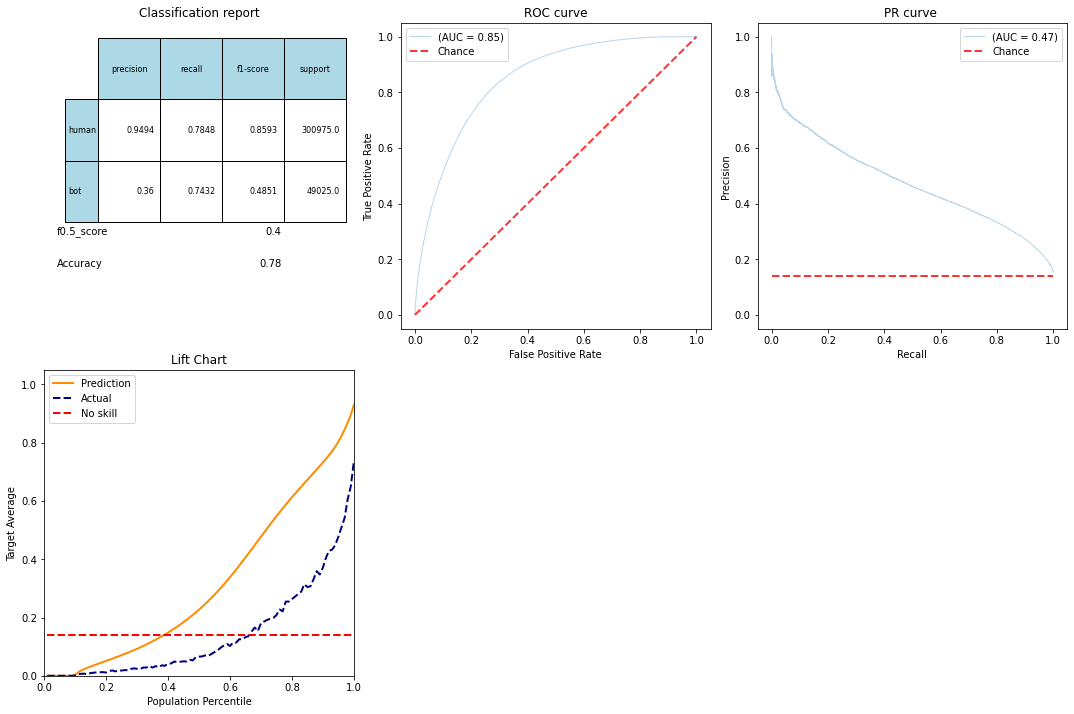

Imbalance compensation of 5.1:1


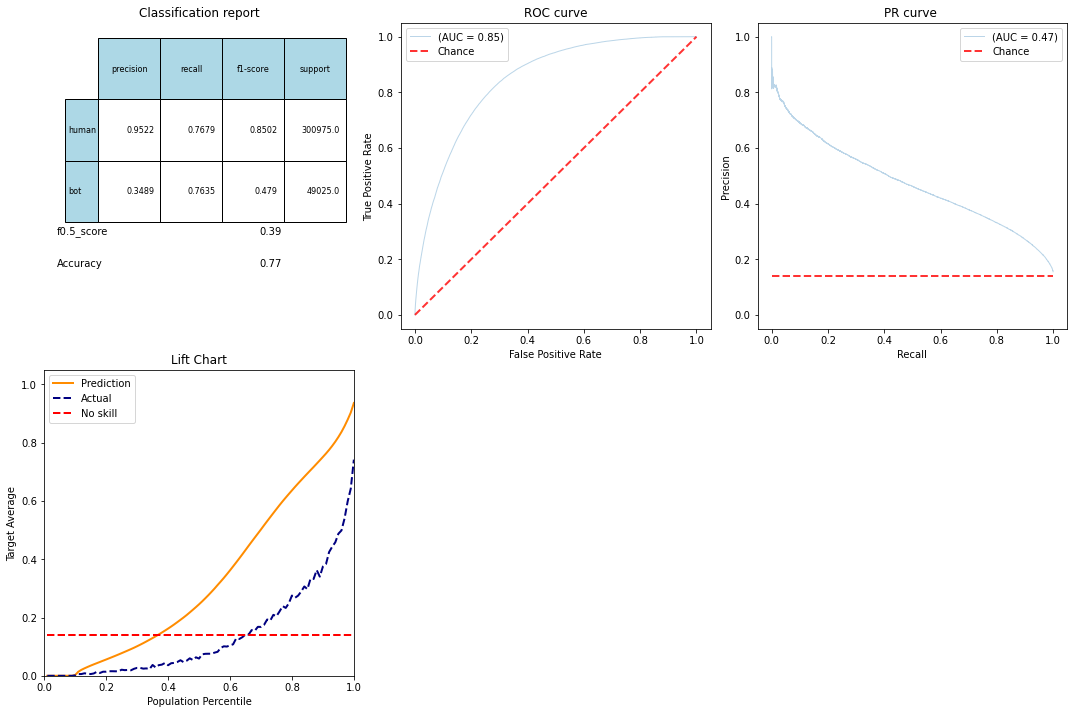

Imbalance compensation of 5.6:1


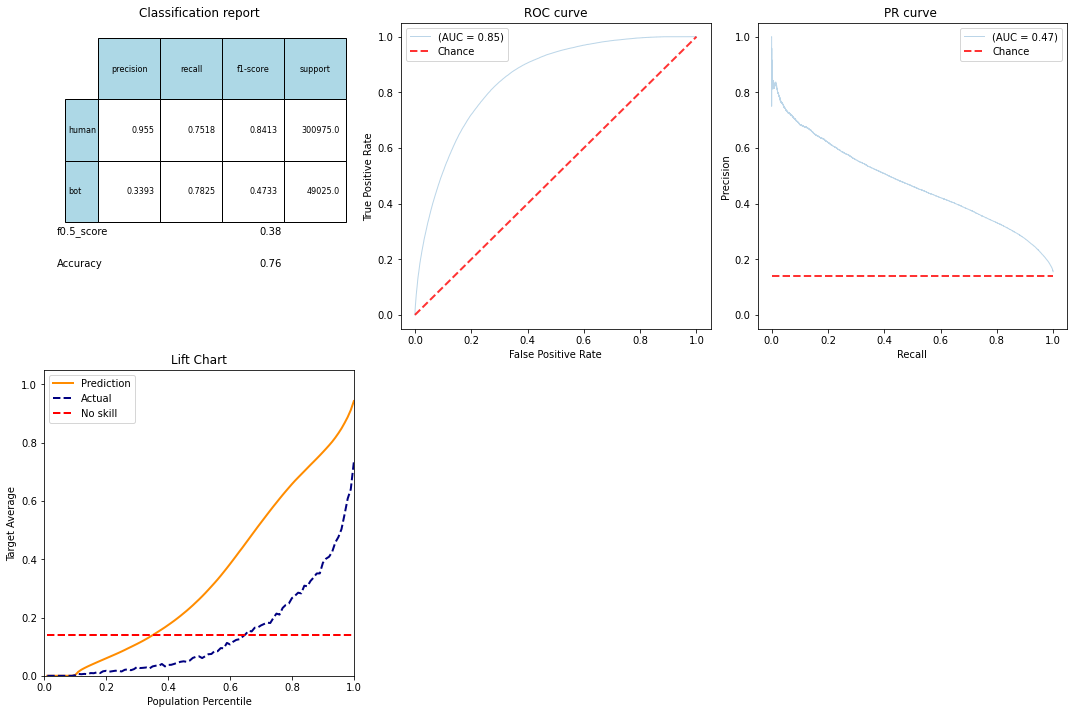

Imbalance compensation of 6.1:1


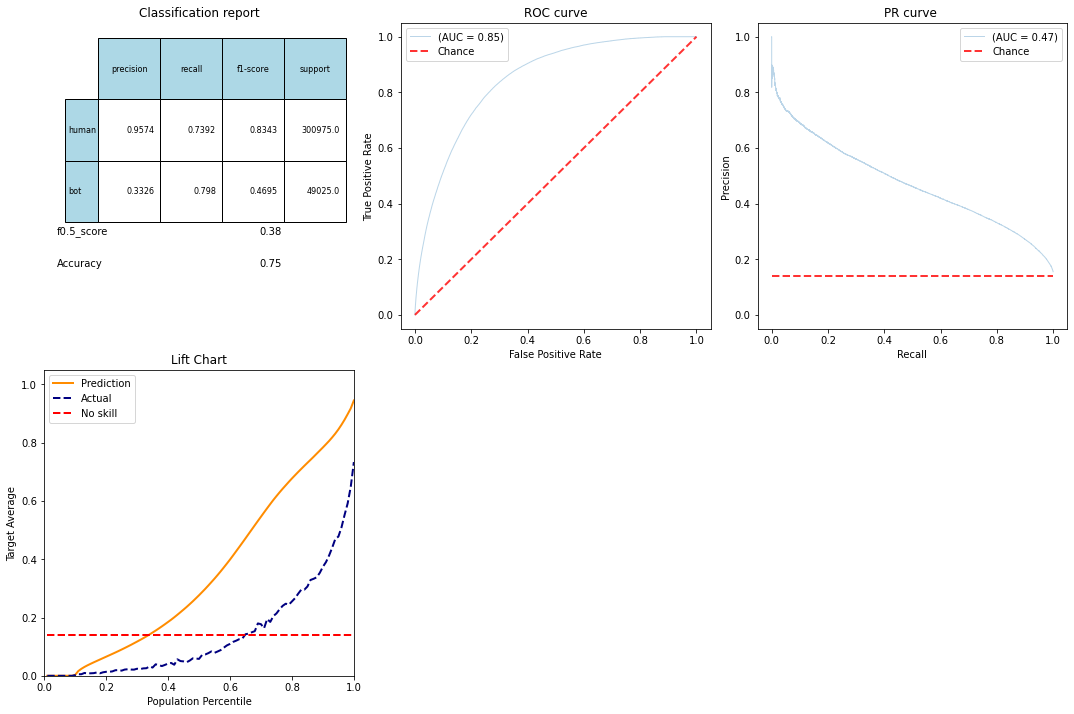

Imbalance compensation of 6.6:1


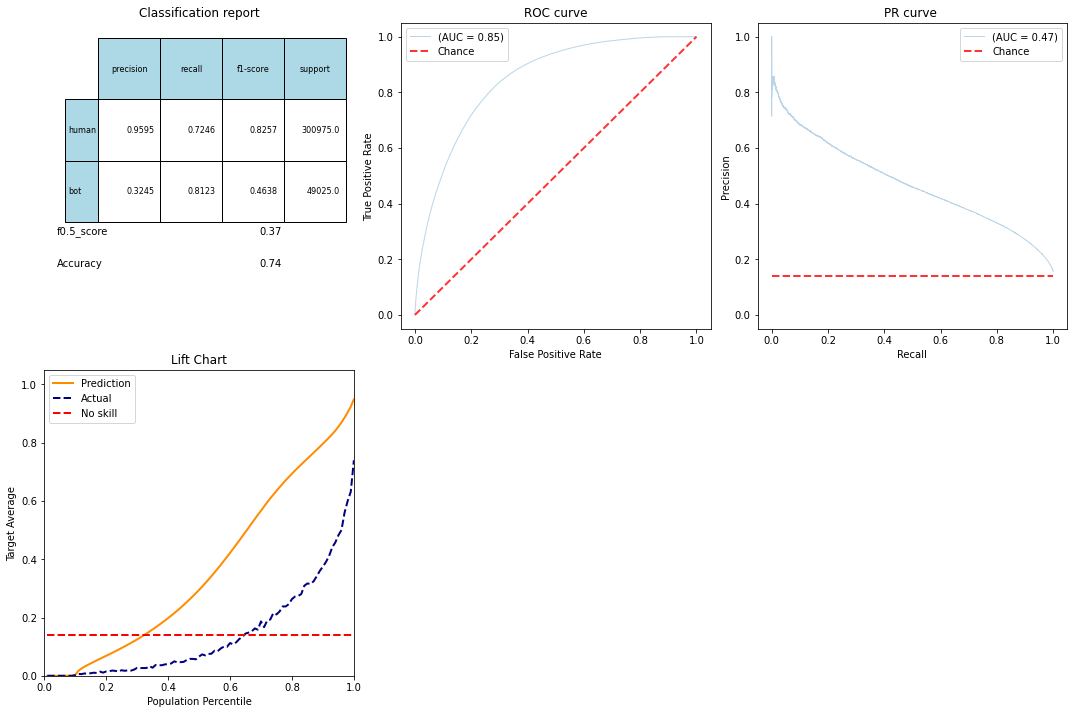

Imbalance compensation of 7.1:1


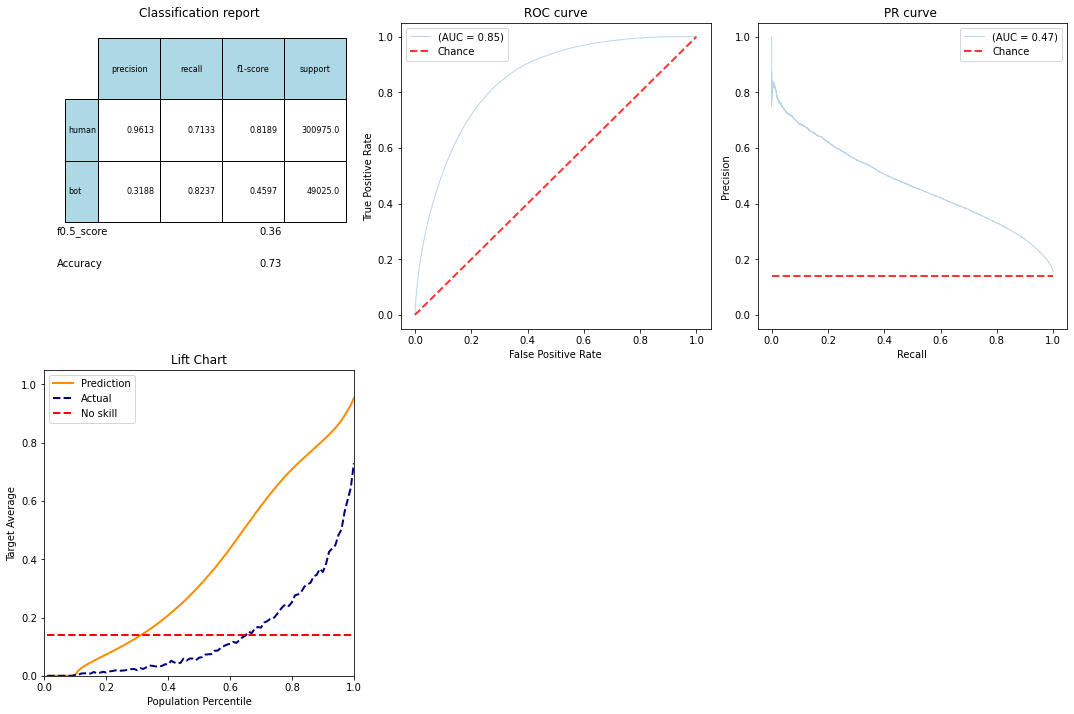

Imbalance compensation of 7.6:1


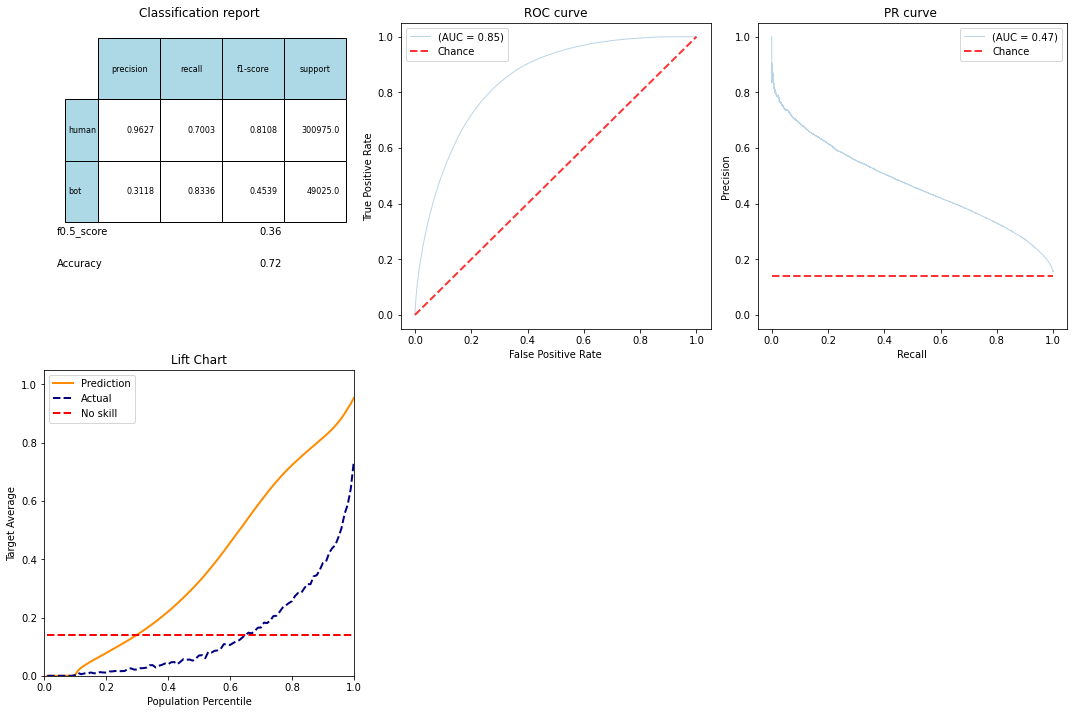

Imbalance compensation of 8.1:1


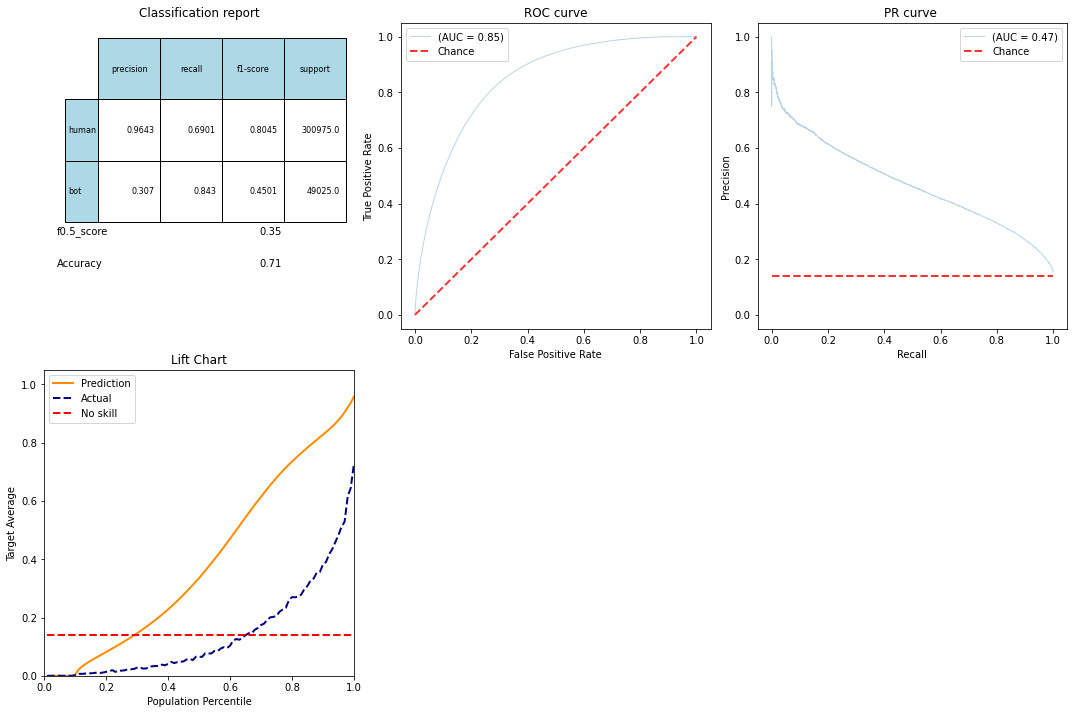

Imbalance compensation of 8.6:1


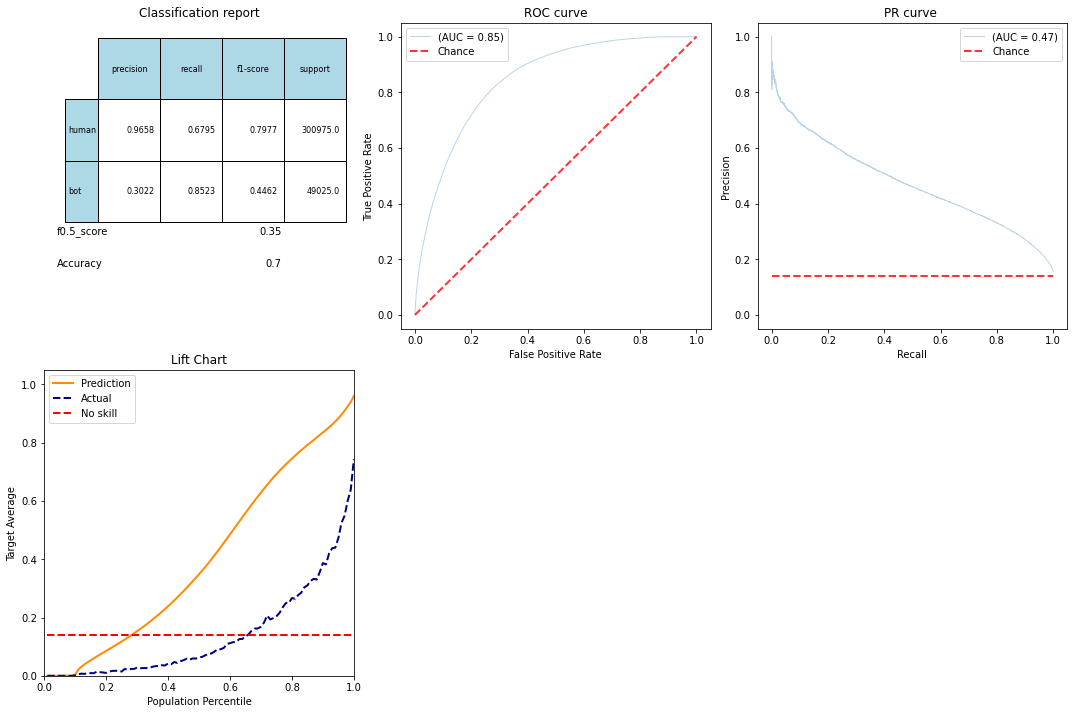

Imbalance compensation of 9.1:1


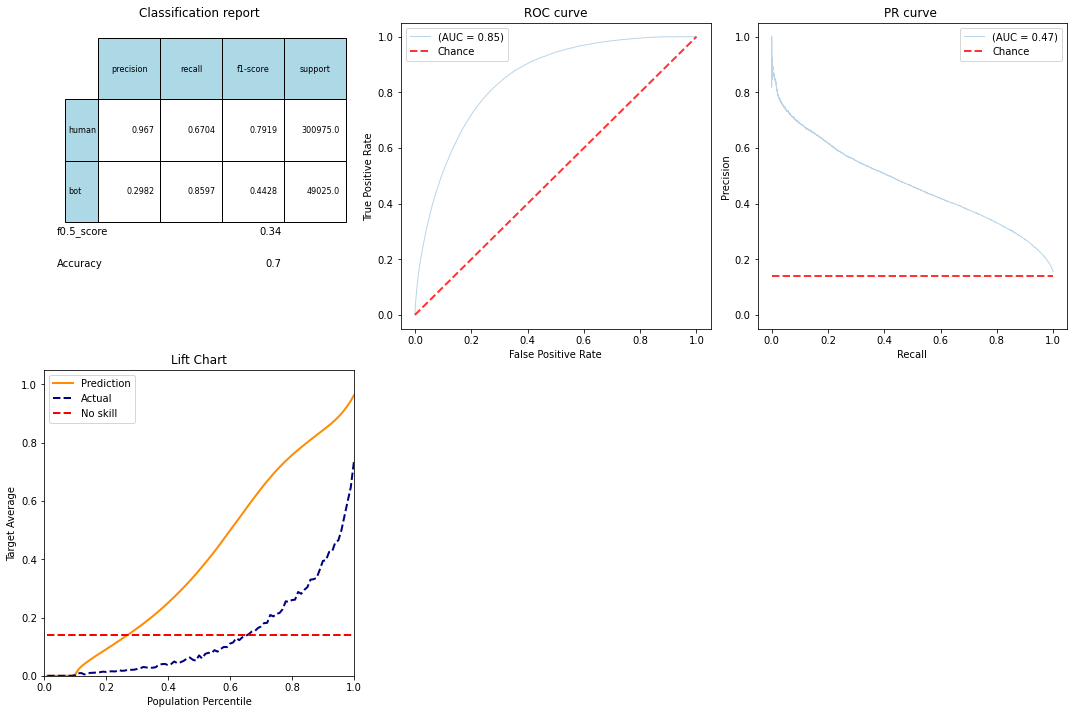

In [12]:
# scale fine-tuning
results_scale = {}
beta=0.5
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    print(f'Imbalance compensation of {scaling}:1')
    xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=scaling
                        )
    xgb.fit(X_train_encode, y_train)
    
    roc_auc, pr_auc, report, personalized_metrics = make_report(model = xgb,
                                                                y_test = y_test, 
                                                                x_test = X_test_encode,  
                                                                include = ['class_report', 'roc', 'pr', 'lift'], 
                                                                pad=1,
                                                                scale=5,
                                                                personalized = {f'f{beta}_score':fbeta_score},
                                                                **{'beta':beta, 'pos_label':1})

    results_scale[scaling] = {'roc_auc':roc_auc, 'pr_auc':pr_auc, 'report':report, 'personalized_metrics':personalized_metrics}
    

In [15]:
# estimating performance
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
roc_auc_scorer = make_scorer(roc_auc_score, needs_proba=True)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
accuracy_scorer = make_scorer(accuracy_score)
scaling_results = None
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=scaling)
    cv_results = cross_validate(xgb, 
                                X_train_encode, 
                                y_train, 
                                cv=5,
                                scoring={'f0.5_score':fpointfive_scorer, 'roc_auc':roc_auc_scorer, 'precision':precision_scorer, 'recall':recall_scorer, 'accuracy':accuracy_scorer})
    temp_df = pd.DataFrame(data=cv_results)
    temp_df.loc[:,"scale"] = [scaling]*temp_df.shape[0]
    scaling_results = pd.concat([scaling_results,temp_df])
    del xgb, temp_df
    print(scaling)    

0.1
0.6
1.1
1.6
2.1
2.6
3.1
3.6
4.1
4.6
5.1
5.6
6.1
6.6
7.1
7.6
8.1
8.6
9.1


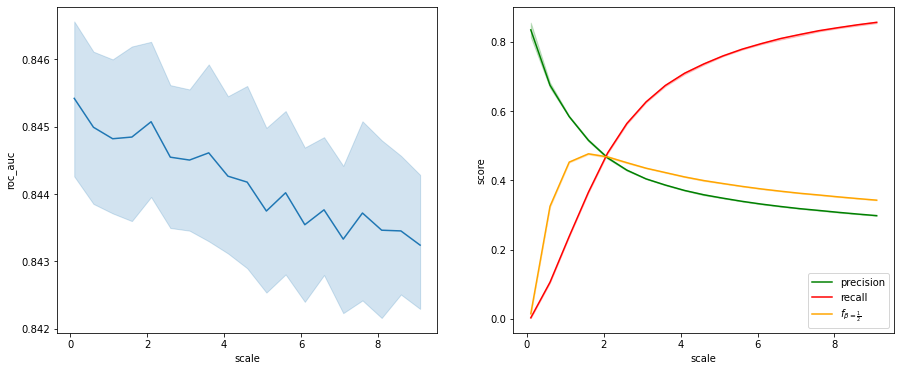

In [16]:
# performance against_sclae
plt.figure(figsize=(15,6))
ax = plt.subplot(121)
ax1= plt.subplot(122)
sns.lineplot(x='scale',
             y='test_roc_auc',
             data=scaling_results,
             ax=ax)
sns.lineplot(x='scale',
             y='test_precision',
             data=scaling_results,
             label='precision',
             color='green',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_recall',
             data=scaling_results,
             label='recall',
             color='red',
             ax=ax1)
sns.lineplot(x='scale',
             y='test_f0.5_score',
             data=scaling_results,
             label=r'$f_{\beta = \frac{1}{2}}$',
             color='orange',
             ax=ax1)
ax1.legend()
ax1.set_ylabel('score')
ax.set_ylabel('roc_auc')
plt.show()

## User-based + Activity-based Bagged classifier

### Strategy 1: Avg. of probabilities for minority class, then th = 0.5

In [5]:
# train - test
user_based_features = [i for i in data.columns if 'uuu' in i]
activity_based_features = [i for i in data.columns if 'aaa' in i]
categorical_features = ['aaa_less_used_language', 'aaa_mode_language', 'aaa_mode_type_corrected']

df_master = data.copy()
df_master.loc[:, categorical_features] = df_master[categorical_features].fillna('-1')
df_master.loc[:, 'aaa_number_tweets_sample'] = df_master['aaa_number_tweets_sample'].fillna(0)
df_master.fillna(-1, inplace=True)
X = df_master.drop(columns="target").copy()
y = df_master.target.copy()

In [6]:
# train - test
cv = 1
i = np.random.choice(X.index, size=(cv,int(round(X.shape[0]/3))), replace=False)

test_indices = X.index.isin(i[0])
X_train = X.iloc[~test_indices].copy()
y_train = y.iloc[~test_indices].copy()
    
X_test = X.iloc[test_indices].copy()
y_test = y.iloc[test_indices].copy()
    
# user model
X_train_user = X_train[user_based_features].copy()
y_train_user = y_train.copy()

X_test_user = X_test[user_based_features].copy()
y_test_user = y_test.copy()
    
# activity model
X_train_activity = X_train[activity_based_features].copy()
y_train_activity = y_train.copy()
X_test_activity = X_test[activity_based_features].copy()
y_test_activity = y_test.copy()

cat_encoder = target_encoder.TargetEncoder(cols=categorical_features)
cat_encoder.fit(X_train_activity, y_train_activity)

X_train_activity_encode = cat_encoder.transform(X_train_activity)
X_test_activity_encode = cat_encoder.transform(X_test_activity)
    

In [43]:
# exploration
scaling_user = 6
scaling_activity = 1 
# user 
model_user = XGBClassifier(eval_metric='auc',
                           scale_pos_weight=scaling_user)
model_user.fit(X_train_user, y_train_user)

#activity
model_activity = XGBClassifier(eval_metric='auc',
                               scale_pos_weight=scaling_activity)
model_activity.fit(X_train_activity_encode, y_train_activity)
            
# bagging
y_prob_bagged, y_binary_bagged = bagging_models(models=(model_user, model_activity),
                                                test_data=(X_test_user, X_test_activity_encode),
                                                train_data=(X_train_user, X_train_activity_encode),
                                                train_labels=y_train,
                                                thresholds=(0.8, 0.4),
                                                strategy='unanimous_voting',
                                                **{'epochs': 50, 'verbose': 1})

--- unanimous_voting ---
--- using thresholds = (0.8, 0.4) ---
--- for predicted prob, null is returned ---


0.17153417153417153


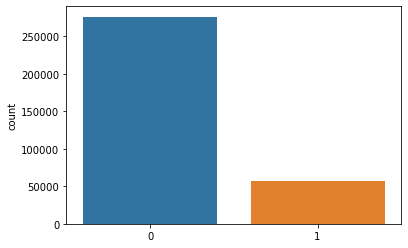

In [41]:
sns.countplot(x=y_binary_bagged)
print(sum(y_binary_bagged)/len(y_binary_bagged))

--- ignoring threshold ---


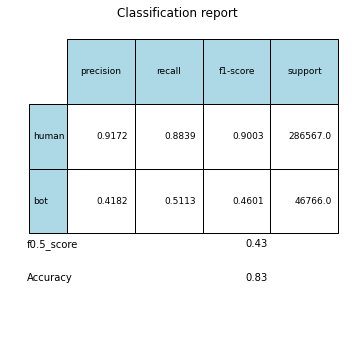

In [42]:
# exploration
beta=0.5
roc_auc, pr_auc, report, personalized_metrics = make_report(model = None,
                                                            y_prob_predicted = None,
                                                            y_pre_predicted = y_binary_bagged,
                                                            y_test = y_test, 
                                                            x_test = None,  
                                                            include = ['class_report'], 
                                                            pad=1,
                                                            scale=5,
                                                            personalized = {f'f{beta}_score':fbeta_score},
                                                            **{'beta':beta, 'pos_label':1})

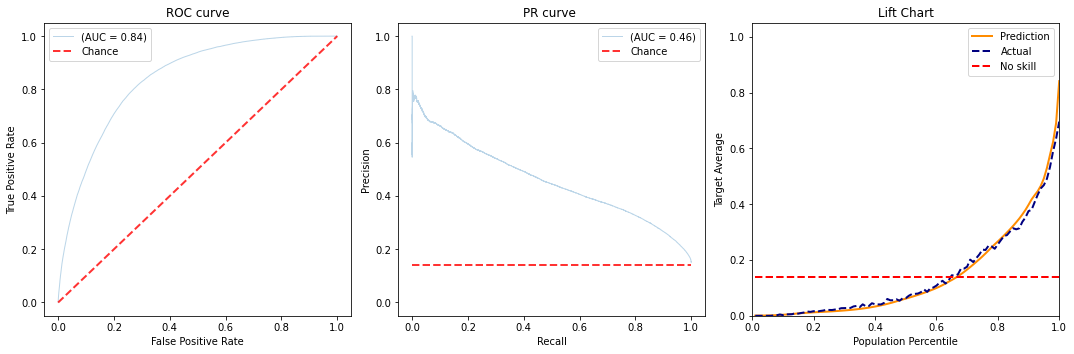

In [52]:
# exploration
beta=0.5
roc_auc, pr_auc, report, personalized_metrics = make_report(model = None,
                                                            y_prob_predicted = y_prob_bagged,                                                            y_test = y_test, 
                                                            x_test = None,  
                                                            include = ['roc', 'pr', 'lift'], 
                                                            pad=1,
                                                            scale=5,
                                                            personalized = {f'f{beta}_score':fbeta_score},
                                                            **{'beta':beta, 'pos_label':1})

In [5]:
ideal = len(y[y==0])/len(y[y==1])
print(ideal)

6.145766490642619


In [28]:
# cross_validation
cv = 1
tests = np.random.choice(X.index, size=(cv,int(X.shape[0]/5)), replace=False)
results = None
for i in tests:
    test_indices = X.index.isin(i)
    X_train = X.iloc[~test_indices].copy()
    y_train = y.iloc[~test_indices].copy()
    
    X_test = X.iloc[test_indices].copy()
    y_test = y.iloc[test_indices].copy()
    
    # user model
    X_train_user = X_train[user_based_features].copy()
    y_train_user = y_train.copy()

    X_test_user = X_test[user_based_features].copy()
    y_test_user = y_test.copy()
    
    # activity model
    X_train_activity = X_train[activity_based_features].copy()
    y_train_activity = y_train.copy()
    X_test_activity = X_test[activity_based_features].copy()
    y_test_activity = y_test.copy()

    cat_encoder = target_encoder.TargetEncoder(cols=categorical_features)
    cat_encoder.fit(X_train_activity, y_train_activity)

    X_train_activity_encode = cat_encoder.transform(X_train_activity)
    X_test_activity_encode = cat_encoder.transform(X_test_activity)
    
    # scaling user-activity
    for scaling_user in []:#np.arange(0.1,ideal + ideal*0.5,0.5):
        print(f'--- scale user: {scaling_user} ---')
        model_user = XGBClassifier(eval_metric='auc',
                                   scale_pos_weight=scaling_user)
        model_user.fit(X_train_user, y_train_user)
        for scaling_activity in +-np.arange(0.1,ideal + ideal*0.5,0.5):
            print(f'--- scale activity: {scaling_activity} ---')
            model_activity = XGBClassifier(eval_metric='auc',
                                           scale_pos_weight=scaling_activity)
            model_activity.fit(X_train_activity_encode, y_train_activity)
            
            # bagging
            y_prob_bagged, y_binary_bagged = bagging_models(models=(model_user, model_activity),
                                                    test_data=(X_test_user, X_test_activity_encode),
                                                    train_data=(X_train_user, X_train_activity_encode),
                                                    train_labels=y_train,
                                                    thresholds=(0.8, 0.4),
                                                    strategy='avg_positive',
                                                    **{'epochs': 50, 'verbose': 1})
            if y_prob_bagged is not None:
                roc_auc = roc_auc_score(y_test, y_prob_bagged)
            else:
                roc_auc = 0
                print('--- No ROC defined ---')
            if y_binary_bagged is not None:
                precision = precision_score(y_test, y_binary_bagged)
                recall = recall_score(y_test, y_binary_bagged)
                fbeta = fbeta_score(y_test, y_binary_bagged, beta=0.5, pos_label=1)
            else:
                precision = 0
                recall = 0
                fbeta = 0
                print('--- No binary metrics defined ---')
            
            temp_df = pd.DataFrame(data={'test_roc_auc':[roc_auc],
                                         'test_precision':[precision],
                                         'test_recall':[recall],
                                         'test_f0.5_score':[fbeta],
                                         'scale_user':[scaling_user],
                                         'scale_activity':[scaling_activity]})
            results = pd.concat([results,temp_df])
                

--- scale user: 0.1 ---
--- scale activity: 0.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---


C:\Users\alejo\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


--- scale activity: 0.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 1.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 1.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 2.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 2.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 3.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 3.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, n

--- scale activity: 9.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale user: 1.6 ---
--- scale activity: 0.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 0.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 1.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 1.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 2.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 2.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
-

--- No ROC defined ---
--- scale activity: 8.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 8.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 9.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale user: 3.1 ---
--- scale activity: 0.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 0.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 1.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 1.6 ---
--- sum_prob_voting ---
--- not

--- No ROC defined ---
--- scale activity: 7.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 7.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 8.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 8.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 9.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale user: 4.6 ---
--- scale activity: 0.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 0.6 ---
--- sum_prob_voting ---
--- not

--- No ROC defined ---
--- scale activity: 6.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 6.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 7.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 7.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 8.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 8.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 9.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--

--- scale activity: 5.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 5.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 6.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 6.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 7.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 7.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 8.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, n

--- No ROC defined ---
--- scale activity: 4.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 4.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 5.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 5.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 6.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 6.6 ---
--- sum_prob_voting ---
--- not using thresholds ---
--- for predicted prob, null is returned ---
--- No ROC defined ---
--- scale activity: 7.1 ---
--- sum_prob_voting ---
--- not using thresholds ---
--

In [27]:
tests[0].shape

(200000,)

In [29]:
results.to_csv('sum_prob_voting.csv')

In [30]:
results_median = results.copy()

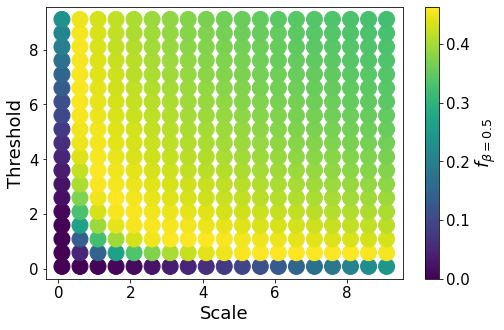

In [31]:
# interaction
plt.figure(figsize=(8,5))
ax=plt.subplot(111)
sc1 = ax.scatter(x = results_median.scale_activity,
                 y = results_median.scale_user,
                 c = results_median['test_f0.5_score'],
                 s = 255.5)
cbar = plt.colorbar(sc1)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
for t in ax.get_yticklabels():
     t.set_fontsize(15)
for t in ax.get_xticklabels():
     t.set_fontsize(15)
ax.set_ylabel('Threshold',fontsize=18)
ax.set_xlabel(r'Scale',fontsize=18)
cbar.set_label(r'$f_{\beta=0.5}$', rotation=90,fontsize=18)

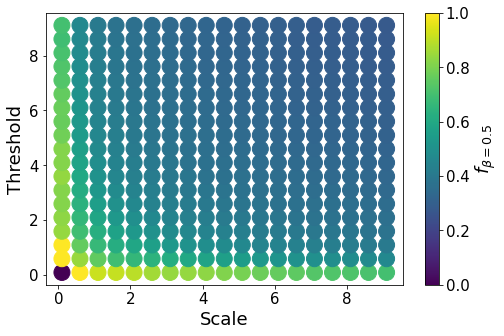

In [18]:
# interaction
plt.figure(figsize=(8,5))
ax=plt.subplot(111)
sc1 = ax.scatter(x = results_median.scale_activity,
                 y = results_median.scale_user,
                 c = results_median['test_precision'],
                 s = 255.5)
cbar = plt.colorbar(sc1)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(15)
for t in ax.get_yticklabels():
     t.set_fontsize(15)
for t in ax.get_xticklabels():
     t.set_fontsize(15)
ax.set_ylabel('Threshold',fontsize=18)
ax.set_xlabel(r'Scale',fontsize=18)
cbar.set_label(r'$f_{\beta=0.5}$', rotation=90,fontsize=18)

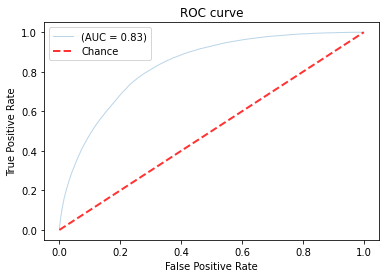

In [20]:
ax = plt.subplot(1, 1, 1)
fpr, tpr, thresholds = roc_curve(y_test, y_prob_bagged)
roc_auc = auc(fpr, tpr)
ax.plot(fpr, tpr, lw=1, alpha=0.3, label='(AUC = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve')
plt.legend()

In [14]:
results

test_roc_auc  test_precision  test_recall  test_f0.5_score  scale_user  \
0       0.83103             0.0          0.0              0.0         0.1   

   scale_activity  
0             0.1

In [25]:
# estimating performance
fpointfive_scorer = make_scorer(fbeta_score, beta=0.5, pos_label=1)
roc_auc_scorer = make_scorer(roc_auc_score)
precision_scorer = make_scorer(precision_score)
recall_scorer = make_scorer(recall_score)
accuracy_scorer = make_scorer(accuracy_score)
scaling_results = None
for scaling in np.arange(0.1,ideal + ideal*0.5,0.5):
    # user
    xgb_user = XGBClassifier(eval_metric='auc', 
                             scale_pos_weight=scaling)
    # activity
    xgb_activity = XGBClassifier(eval_metric='auc', 
                                 scale_pos_weight=scaling)
    
    
    temp_df = pd.DataFrame(data=cv_results)
    temp_df.loc[:,"scale"] = [scaling]*temp_df.shape[0]
    scaling_results = pd.concat([scaling_results,temp_df])
    del xgb, temp_df
    print(scaling)    

array([0.11920292, 0.88079708])

In [24]:
X.sample(frac=0.0001).index

aaa_total_number_mentions  aaa_number_tweets_sample  \
634014                      215.0                     195.0   
195404                      188.0                     154.0   
805187                      113.0                      95.0   
273351                       70.0                      53.0   
129305                        2.0                       1.0   
...                           ...                       ...   
997056                       70.0                     104.0   
900951                       62.0                      53.0   
837810                       -1.0                       0.0   
717051                       86.0                     107.0   
669034                       70.0                      77.0   

        aaa_number_tweets_with_mention  aaa_unique_number_mentions  \
634014                           146.0                       144.0   
195404                           137.0                        78.0   
805187                            95.0                        83.0   
273351                            53.0                        63.0   
129305                             1.0                         2.0   
...                                ...                         ...   
997056                            50.0                        51.0   
900951                            37.0                        39.0   
837810                            -1.0                        -1.0   
717051                            75.0                        68.0   
669034                            47.0                        31.0   

        aaa_avg_number_mentions_tweet  \
634014                       1.102564   
195404                       1.220779   
805187                       1.189474   
273351                       1.320755   
129305                       2.000000   
...                               ...   
997056                       0.673077   
900951                       1.169811   
837810                      -1.000000   
717051                       0.803738   
669034                       0.909091   

        aaa_avg_number_mentions_tweet_with_mention  \
634014                                    1.472603   
195404                                    1.372263   
805187                                    1.189474   
273351                                    1.320755   
129305                                    2.000000   
...                                            ...   
997056                                    1.400000   
900951                                    1.675676   
837810                                   -1.000000   
717051                                    1.146667   
669034                                    1.489362   

        aaa_avg_number_unique_mentions_tweet  \
634014                              0.738462   
195404                              0.506494   
805187                              0.873684   
273351                              1.188679   
129305                              2.000000   
...                                      ...   
997056                              0.490385   
900951                              0.735849   
837810                             -1.000000   
717051                              0.635514   
669034                              0.402597   

        aaa_avg_number_unique_mentions_tweet_with_mention  \
634014                                           0.986301   
195404                                           0.569343   
805187                                           0.873684   
273351                                           1.188679   
129305                                           2.000000   
...                                                   ...   
997056                                           1.020000   
900951                                           1.054054   
837810                                          -1.000000   
717051                                           0.906667   
669034              

In [68]:
b = np.array([[1,2], [1,1], [10, 10]])+np.array([[1,2], [1,2], [1,0]])
b

array([[ 2,  4],
       [ 2,  3],
       [11, 10]])

In [71]:
np.array([softmax(i) for i in b])[:,1]

array([0.88079708, 0.73105858, 0.26894142])

In [57]:
(1,) + (2,)

(1, 2)

In [82]:
xgb = XGBClassifier(eval_metric='auc', 
                        scale_pos_weight=1)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [87]:
y_pre = xgb.predict_proba(X_test)[:,1]
y_pre_bin = y_pre.copy()
y_true = y_test.copy()

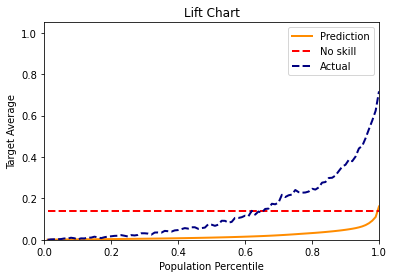

In [18]:
# lift chart
df_dict = {'actual': list(y_test), 'pred': list(y_prob_bagged)}
df = pd.DataFrame(df_dict)
pred_ranks = pd.qcut(df['pred'].rank(method='first'), 100, labels=False)
pred_percentiles = df.groupby(pred_ranks).mean()
ax2 = plt.subplot(1, 1, 1)
ax2.set_title('Lift Chart', y=1)
ax2.plot(np.arange(.01, 1.01, .01), 
         np.array(pred_percentiles['pred']),
         color='darkorange', 
         lw=2, 
         label='Prediction')
ax2.plot(np.arange(.01, 1.01, .01), 
         [np.mean(y_test)]*100,
         color='red', 
         lw=2, 
         linestyle='--', 
         label='No skill')
ax2.plot(np.arange(.01, 1.01, .01), 
         np.array(pred_percentiles['actual']),
         color='navy', 
         lw=2, 
         linestyle='--', 
         label='Actual')
ax2.set_ylabel('Target Average')
ax2.set_xlabel('Population Percentile')
ax2.set_xlim([0.0, 1])
ax2.set_ylim([0, 0.05 + 1])
ax2.legend(loc="best")

In [81]:
np.array([1,2,3]).shape == (3,)

True

In [ ]:
# weighting the classes to account for imbalancing
rf = RandomForestClassifier()

# PCA to reduce dimentionality 

In [ ]:
# scale before PCA
# try with_mean = False
sc = StandardScaler(with_mean=True)
sc.fit(X_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)
for j_features in [34, 24, 14, 4]:
    xgb = XGBClassifier()
    pca = PCA(n_components = j_features)
    X_train_scaled_pca = pca.fit_transform(X_train_scaled)
    xgb.fit(X_train_scaled_pca, y_train)
    X_test_scaled_transformed = pca.transform(X_test_scaled)
    predicted = xgb.predict(X_test_scaled_transformed)
    del xgb, pca
    print(j_features)
    print(classification_report(y_test,predicted))

In [ ]:
X_test_scaled = sc.transform(X_test)

In [ ]:
predicted = xgb.predict(X_test_scaled)
classification_report(y_Tes)

In [ ]:
print(classification_report(y_test,predicted))